[Link to excel-file with KPIs](https://docs.google.com/spreadsheets/d/1ZTmkZ-Q7vRvtAuev4pOpeZ5ZIRnzZOHA/edit#gid=421233089)

# 08. Data Analytics - Geographically Weighted Regression

References:

Gregori, E., & Reyes Valenzuela, P. (2021). Urbana [Python / Jupyter Notebook; GitHub Repository]. Barcelona Supercomputing Center. https://github.com/egregorimar/urbana 

Rey, S. J., Arribas-Bel, D., & Wolf, L. J. (2020). Spatial Regression. In Geographic Data Science with Python. https://geographicdata.science/book/notebooks/11_regression.html

In [1]:
import os
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pysal.model import mgwr
from scipy.stats import pearsonr
import sklearn.metrics as metrics
from sklearn.preprocessing import PowerTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

/root/venv/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_716/3062270294.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  im

In [2]:
# papermill parameters cell

OUTPUT_WARNINGS = False
SAVE_TABLES = True
SAVE_FIGS = True
SAVE_MODEL = True
FIT_INTERCEPT = False
DROP_VARIABLE = False

VARIABLE_TO_PREDICT =  "CCI"
VARIABLE_TO_DROP = []
AREA_TO_PREDICT = "Spain" # "Spain" # "Iberian Pensinula"

In [3]:
if OUTPUT_WARNINGS is False:
    import warnings

    warnings.filterwarnings("ignore")

In [4]:
AREA_TO_PREDICT_dict = {
    "Andalusia": "01", 
    "Aragon": "02",
    "Asturias": "03", 
    "Balearic Islands": "04",
    "Canarias": "05", 
    "Cantabria": "06",
    "Castile and Leon": "07", 
    "Castille-La Mancha": "08",
    "Catalonia": "09", 
    "Valencia": "10",
    "Extremadura": "11", 
    "Galicia": "12",
    "Madrid": "13", 
    "Murcia": "14",
    "Navarre": "15", 
    "Basque Country": "16",
    "La Rioja": "17",
    "Ceuta": "18",
    "Melilla": "19",
    "Minor Plazas de Soberanía": "20",
    }

In [5]:
CCI_list = ["D_level_w", "ECR_level_w", "M_level_w", "W_level_w", "CCI"]

## Parameter Check

In [6]:
# Create folders to store the data
DIR_DATA = "data/"
DIR_VAR = DIR_DATA + "processed/{}/{}/".format(VARIABLE_TO_PREDICT, AREA_TO_PREDICT)
DIR_GWR = DIR_VAR + "08_gwr/"

if SAVE_FIGS is True or SAVE_MODEL is True:
    folder_list = [
        DIR_GWR,
        DIR_GWR + "coefficients",
    ]

    for folder in folder_list:
        if not os.path.exists(folder):
            os.makedirs(folder)

In [7]:
PATH_TO_FILE = DIR_DATA + "interim/demographic_interimdata/merged_demographic_interimdata/Spatial_demographic_interimdata.csv"
if os.path.isfile(PATH_TO_FILE) is False:
    raise Exception(
        'Please run first the notebooks with the same area and "SAVE_DATA" set to True: /n"00acquisition.ipynb", /n"01datamanagement.ipynb", /n"02dataspatialization.ipynb", /n"03index.ipynb"'
    )

In [8]:
PATH_TO_FILE = DIR_VAR + "07_linear/coefficients.csv"
if os.path.isfile(PATH_TO_FILE) is False:
    raise Exception(
        'Please run first the notebook "07linear.ipynb" with the same date and "SAVE_MODEL" set to True'
    )

## Target variable

### Dependent variable

In [9]:
# Read CCI results
CCI = pd.read_csv('data/processed/CCI/03_index/CCI_Index.csv')

# Add extra digit to dataset['CTOT'] - if it contains less than 7 characters
CCI['CTOT'] = CCI['CTOT'].apply(lambda x: '{0:0>7}'.format(x))

# Choose Study Area
if AREA_TO_PREDICT in AREA_TO_PREDICT_dict:
    CCI = CCI[CCI["CTOT"].astype(str).str.contains(r'^' + AREA_TO_PREDICT_dict[AREA_TO_PREDICT])]
elif AREA_TO_PREDICT == "Iberian Pensinula":
    CCI = CCI[~CCI.CTOT.str.contains(r'^04')] # --> DROP BALEARIC ISLANDS
    CCI = CCI[~CCI.CTOT.str.contains(r'^05')] # --> DROP CANARIAS
    CCI = CCI[~CCI.CTOT.str.contains(r'^18')] # --> DROP CEUTA
    CCI = CCI[~CCI.CTOT.str.contains(r'^19')] # --> DROP MELILLA
    CCI = CCI[~CCI.CTOT.str.contains(r'^20')] # --> DROP MINOR PLAZAS DE SOBERINIA
elif AREA_TO_PREDICT == "Spain":
    pass

CCI.set_index("CTOT", inplace=True)

### Independent variables

In [10]:
# Read variables dataset into DataFrame
sect = pd.read_csv(DIR_DATA + "interim/demographic_interimdata/merged_demographic_interimdata/Spatial_demographic_interimdata.csv")

# Add extra digit to dataset['CTOT'] - if it contains less than 7 characters
sect['CTOT'] = sect['CTOT'].apply(lambda x: '{0:0>7}'.format(x))

# Choose Study Area
if AREA_TO_PREDICT in AREA_TO_PREDICT_dict:
    sect = sect[sect["CTOT"].astype(str).str.contains(r'^' + AREA_TO_PREDICT_dict[AREA_TO_PREDICT])]
elif AREA_TO_PREDICT == "Iberian Pensinula":
    sect = sect[~sect.CTOT.str.contains(r'^04')] # --> DROP BALEARIC ISLANDS
    sect = sect[~sect.CTOT.str.contains(r'^05')] # --> DROP CANARIAS
    sect = sect[~sect.CTOT.str.contains(r'^18')] # --> DROP CEUTA
    sect = sect[~sect.CTOT.str.contains(r'^19')] # --> DROP MELILLA
    sect = sect[~sect.CTOT.str.contains(r'^20')] # --> DROP MINOR PLAZAS DE SOBERINIA
elif AREA_TO_PREDICT == "Spain":
    pass

sect.set_index("CTOT", inplace=True)

# Drop columns with not needed information
sect.drop(["geometry"], axis=1, inplace=True)

if DROP_VARIABLE is True:
    sect.drop(VARIABLE_TO_DROP, axis=1, inplace=True)

In [11]:
# Read spatial dataset into GeoDataFrame
geo_info = gpd.read_file(DIR_DATA + "interim/AdmBound_interimdata/AdmBound_interimdata.gpkg")

# Choose Study Area
if AREA_TO_PREDICT in AREA_TO_PREDICT_dict:
    geo_info = geo_info[geo_info["CTOT"].astype(str).str.contains(r'^' + AREA_TO_PREDICT_dict[AREA_TO_PREDICT])]
elif AREA_TO_PREDICT == "Iberian Pensinula":
    geo_info = geo_info[~geo_info.CTOT.str.contains(r'^04')] # --> DROP BALEARIC ISLANDS
    geo_info = geo_info[~geo_info.CTOT.str.contains(r'^05')] # --> DROP CANARIAS
    geo_info = geo_info[~geo_info.CTOT.str.contains(r'^18')] # --> DROP CEUTA
    geo_info = geo_info[~geo_info.CTOT.str.contains(r'^19')] # --> DROP MELILLA
    geo_info = geo_info[~geo_info.CTOT.str.contains(r'^20')] # --> DROP MINOR PLAZAS DE SOBERINIA
elif AREA_TO_PREDICT == "Spain":
    pass

geo_info.set_index("CTOT", inplace=True)
geo_info = geo_info.drop(["Municipality"], axis=1,)

In [12]:
# Merge datasets to get same shape
geo_info = pd.merge(geo_info, sect, left_index=True, right_index=True)
geo_info = geo_info['geometry']
geo_info = gpd.GeoDataFrame(geo_info)

CCI = pd.merge(CCI, sect, left_index=True, right_index=True)

In [13]:
geo_coefs = geo_info.copy()
geo_tvals = geo_info.copy()
geo_nans = geo_info.copy()

In [14]:
# Add dependent variable column to spatial dataset
# Select data of dependent variable (VARIABLE_TO_PREDICT) and transform to numpy array
y = np.array(CCI[VARIABLE_TO_PREDICT]).reshape((-1, 1))

# Select data of independent variables, drop other columns
X = sect

# Stack 1-D arrays as columns into a 2-D array by centroids of geometry
coords = np.column_stack(
    [geo_info["geometry"].centroid.x, geo_info["geometry"].centroid.y]
)

geo_info["centroid"] = geo_info["geometry"].centroid

In [15]:
# Add dependent variable column to spatial dataset
geo_info[VARIABLE_TO_PREDICT] = CCI[VARIABLE_TO_PREDICT]

id_max_KPI = geo_info[VARIABLE_TO_PREDICT].idxmax()

# Define area with maximum value of dependent variable
print("Area with maximum value: " + str(id_max_KPI))

Area with maximum value: 0724089


### Plot target variable

In [16]:
# Define line colors
def line_color(area):
    if area == "Spain" or area == "Iberian Pensinula": color = 'face'
    else: color = "black"
    return color

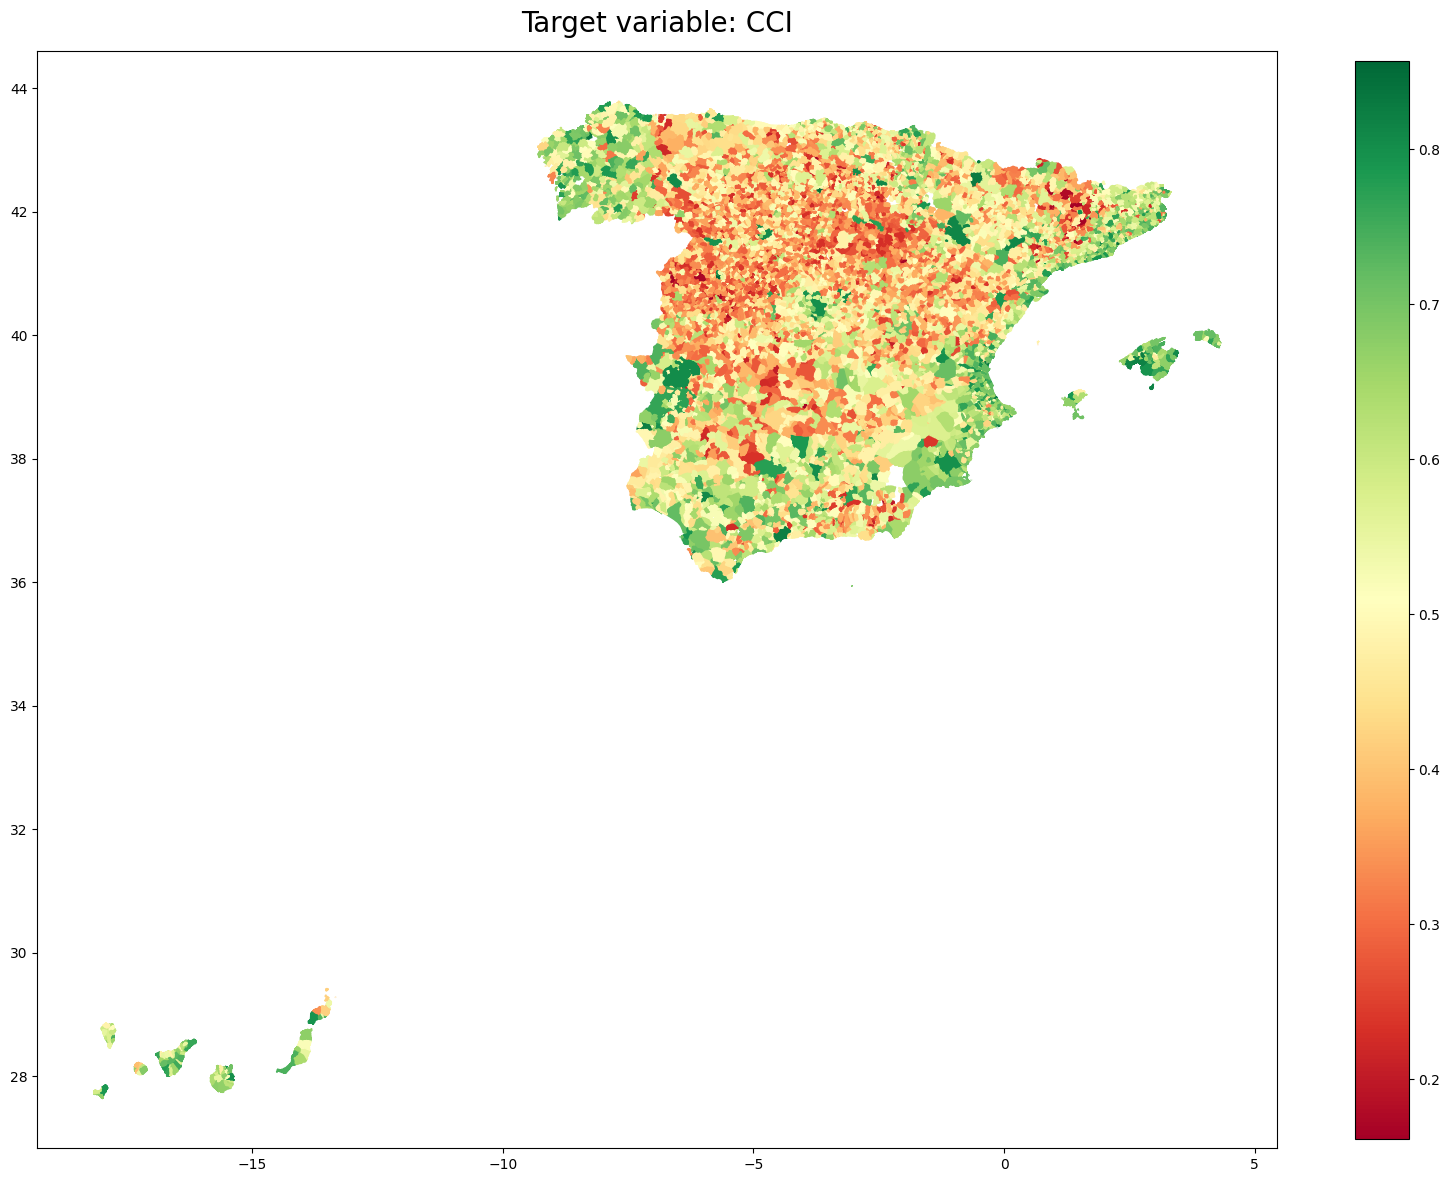

In [17]:
# Plot dependent variable (target variable)
fig, ax = plt.subplots(figsize=(20, 20))

geo_info.plot(
    ax=ax,
    column=VARIABLE_TO_PREDICT,
    edgecolor=line_color(AREA_TO_PREDICT),
    legend=True,
    figsize=(20, 20),
    cmap="RdYlGn",
    legend_kwds={"shrink": 0.7},
)

ax.set_title("Target variable: " + str(VARIABLE_TO_PREDICT), fontsize=20, y=1.01)

plt.show()

## NaNs

In [18]:
# Check for missing values of defined features
pd.isnull(X).sum(0)

POPULATION_2020                                                0
POPULATION_DENSITY_KM2_2020                                    0
POPULATION_PERC_NATURAL_GROWTH_2020                            0
GENDER_PERC_POP_FEMALE_2020                                    0
AGE_AVERAGE_2020                                               0
AGE_PERC_POP_BELOW_18_2020                                     0
AGE_PERC_POP_ABOVE_65_2020                                     0
NATIONALITY_PERC_NONSPANISH_2020                               0
HOUSING_AVERAGE_HOUSEHOLD_SIZE_2020                            0
HOUSING_PERC_SINGLEPERSON_HOUSEHOLD_2020                       0
HOUSING_RESIDENT_BUILDINGS_PER_CAPITA_2011                     0
INCOME_PER_CAPITA_2020                                      1568
INCOME_PER_HOUSEHOLD_2020                                      8
INCOME_PERC_UNEMPLOYMENT_BENEFITS_OF_AVERAGE_SALARY_2020    1798
WEALTH_GINI_2020                                               0
DEBT_MUNICIPALITY_PER_CAP

In [19]:
# Check for percentage of missing values of defined features
pd.isnull(X).sum(0) / len(X) * 100

POPULATION_2020                                              0.000000
POPULATION_DENSITY_KM2_2020                                  0.000000
POPULATION_PERC_NATURAL_GROWTH_2020                          0.000000
GENDER_PERC_POP_FEMALE_2020                                  0.000000
AGE_AVERAGE_2020                                             0.000000
AGE_PERC_POP_BELOW_18_2020                                   0.000000
AGE_PERC_POP_ABOVE_65_2020                                   0.000000
NATIONALITY_PERC_NONSPANISH_2020                             0.000000
HOUSING_AVERAGE_HOUSEHOLD_SIZE_2020                          0.000000
HOUSING_PERC_SINGLEPERSON_HOUSEHOLD_2020                     0.000000
HOUSING_RESIDENT_BUILDINGS_PER_CAPITA_2011                   0.000000
INCOME_PER_CAPITA_2020                                      19.389143
INCOME_PER_HOUSEHOLD_2020                                    0.098924
INCOME_PERC_UNEMPLOYMENT_BENEFITS_OF_AVERAGE_SALARY_2020    22.233214
WEALTH_GINI_2020    

In [20]:
# define the colormap
cmap = plt.cm.YlOrRd # plt.cm.Accent_r
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
# cmaplist[0] = (0.5, 0.5, 0.5, 1.0)
cmaplist[0] = "0.8"
# define the bins and normalize
bounds = np.linspace(0, 8, 9)
my_norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

my_cmap = mpl.colors.LinearSegmentedColormap.from_list("Custom cmap", cmaplist, cmap.N)

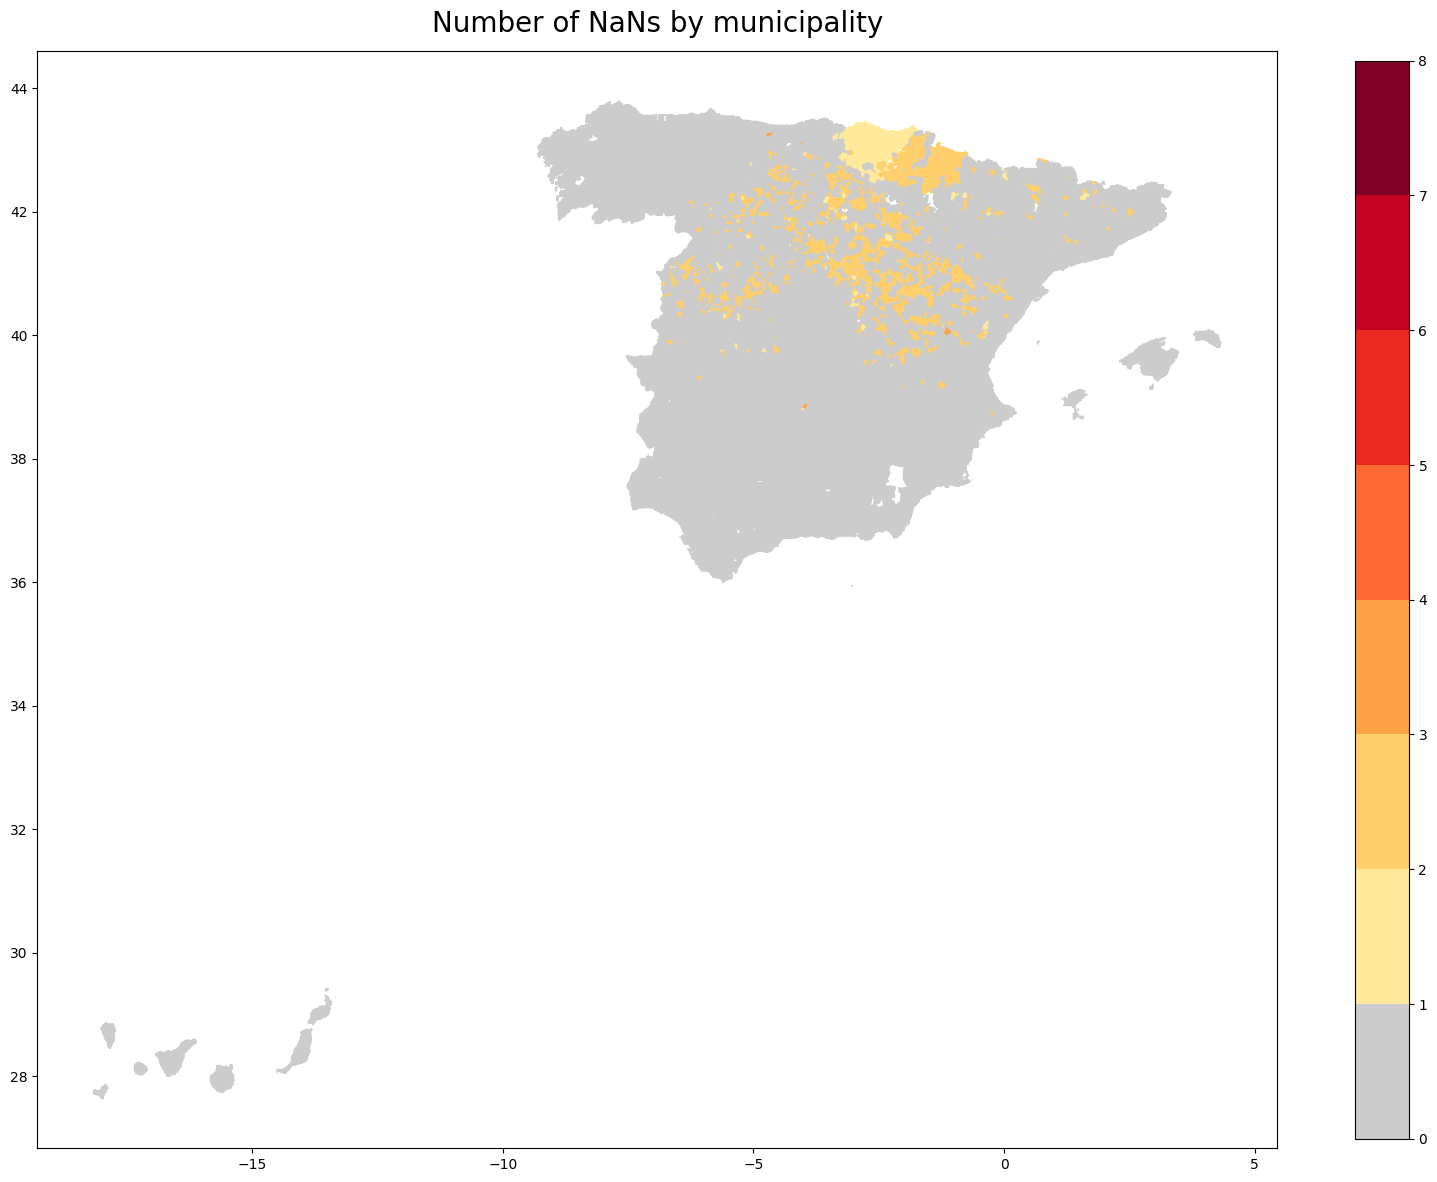

In [21]:
# Plot NaN values
geo_nans["NaNs"] = pd.isnull(sect).sum(axis=1)

fig, ax = plt.subplots(figsize=(20, 20))

geo_nans.plot(
    ax=ax,
    column="NaNs",
    edgecolor=line_color(AREA_TO_PREDICT),
    legend=True,
    norm=my_norm,
    cmap=my_cmap,
    figsize=(20, 20),
    legend_kwds={"shrink": 0.7},
)

ax.set_title("Number of NaNs by municipality", fontsize=20, y=1.01)

plt.show()

## GWR Model

### Feature Selection

In [22]:
# Load best model dataset from 07_linear notebook
linear_coefs = pd.read_csv(DIR_VAR + "07_linear/coefficients.csv", index_col=0)
best_model = linear_coefs.drop(["Intercept"], axis=1).columns

print(best_model)

Index(['POPULATION_2020', 'INCOME_PER_HOUSEHOLD_2020', 'WEALTH_GINI_2020',
       'HOUSING_RESIDENT_BUILDINGS_PER_CAPITA_2011',
       'AGRI_CATTLEFARMS_DENSITY_KM2_2020', 'GENDER_PERC_POP_FEMALE_2020',
       'TOURISM_HOUSES_PER_CAPITA_2022', 'NATIONALITY_PERC_NONSPANISH_2020',
       'DEBT_MUNICIPALITY_PER_CAPITA_2021', 'AGE_AVERAGE_2020',
       'ECONOMY_COMPANIES_PER_CAPITA_2020'],
      dtype='object')


In [23]:
# Define features based on best model 
X_chosen = sect[best_model]
y_chosen = np.array(CCI[VARIABLE_TO_PREDICT]).reshape((-1, 1))

In [24]:
# Check for missing values of defined features
pd.isnull(X_chosen).sum(0)

POPULATION_2020                               0
INCOME_PER_HOUSEHOLD_2020                     8
WEALTH_GINI_2020                              0
HOUSING_RESIDENT_BUILDINGS_PER_CAPITA_2011    0
AGRI_CATTLEFARMS_DENSITY_KM2_2020             0
GENDER_PERC_POP_FEMALE_2020                   0
TOURISM_HOUSES_PER_CAPITA_2022                0
NATIONALITY_PERC_NONSPANISH_2020              0
DEBT_MUNICIPALITY_PER_CAPITA_2021             0
AGE_AVERAGE_2020                              0
ECONOMY_COMPANIES_PER_CAPITA_2020             0
dtype: int64

### Preprocessing

In [25]:
# Create new dataframes by coping X and y
X_transformed = X_chosen.copy()
y_transformed = y_chosen.copy()

# Data Imputation by the k-nearest neighbour method
if pd.isnull(X_chosen).sum().sum() != 0:
    knn_X = KNNImputer()
    knn_X.fit(X_transformed)
    X_transformed = knn_X.transform(X_transformed)

if pd.isnull(y_chosen).sum().sum() != 0:
    knn_y = KNNImputer()
    knn_y.fit(y_transformed)
    y_transformed = knn_y.transform(y_transformed)

# Data Normalization by using the Yeo-Johnson power transformation function
pw_X = PowerTransformer()
pw_X.fit(X_transformed)
X_transformed = pw_X.transform(X_transformed)

pw_y = PowerTransformer()
pw_y.fit(y_transformed)
y_transformed = pw_y.transform(y_chosen)

In [26]:
# Extra check: if y_transformed still contains NaN-values, then replace with 'mean' value
if pd.isnull(y_transformed).sum().sum() != 0:
    simple_y = SimpleImputer(missing_values=np.nan, strategy='mean')
    simple_y.fit(y_transformed)
    y_transformed = simple_y.transform(y_transformed)

pd.isnull(y_transformed).sum().sum()

0

### Multicollinearity Test

In [27]:
# Calculate variance inflation factor (VIF) and measure multicollinearity
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X_transformed, i) for i in range(X_transformed.shape[1])]
vif["variable"] = X_chosen.columns

if SAVE_TABLES is True:
    vif.sort_values(by=['VIF']).to_csv(DIR_GWR + "VIF_GWR_model.csv")

vif.sort_values(by=['VIF'], ascending=False)

VIF                                    variable
0   4.877366                             POPULATION_2020
3   4.258707  HOUSING_RESIDENT_BUILDINGS_PER_CAPITA_2011
9   3.612553                            AGE_AVERAGE_2020
2   1.740952                            WEALTH_GINI_2020
10  1.617288           ECONOMY_COMPANIES_PER_CAPITA_2020
5   1.557129                 GENDER_PERC_POP_FEMALE_2020
7   1.454941            NATIONALITY_PERC_NONSPANISH_2020
1   1.426627                   INCOME_PER_HOUSEHOLD_2020
8   1.179824           DEBT_MUNICIPALITY_PER_CAPITA_2021
6   1.163554              TOURISM_HOUSES_PER_CAPITA_2022
4   1.138759           AGRI_CATTLEFARMS_DENSITY_KM2_2020

In [28]:
def corrfunc(x, y, **kwds):
    cmap = kwds["cmap"]
    norm = kwds["norm"]
    ax = plt.gca()
    ax.tick_params(bottom=False, top=False, left=False, right=False)
    sns.despine(ax=ax, bottom=True, top=True, left=True, right=True)
    r, _ = pearsonr(x, y)
    facecolor = cmap(norm(r))
    ax.set_facecolor(facecolor)
    lightness = (max(facecolor[:3]) + min(facecolor[:3])) / 2
    ax.annotate(
        f"r={r:.2f}",
        xy=(0.5, 0.5),
        xycoords=ax.transAxes,
        color="white" if lightness < 0.7 else "black",
        size=26,
        ha="center",
        va="center",
    )

def scattfunc(x, y, **kwds):
    cmap = kwds["cmap"]
    norm = kwds["norm"]
    ax = plt.gca()
    r, _ = pearsonr(x, y)
    facecolor = cmap(norm(r))
    lightness = (max(facecolor[:3]) + min(facecolor[:3])) / 2
    myColor = "white" if lightness < 0.7 else "black"
    lineColor = "black" if lightness < 0.7 else "white"
    ax.set_facecolor(facecolor)
    sns.regplot(x, y, ax=ax, color=myColor, line_kws={"color": lineColor}, ci=None)

In [29]:
# Plot pairwise relationships of dataset
#g = sns.PairGrid(pd.DataFrame(X_transformed, columns=X_chosen.columns))
#g.map_lower(scattfunc, cmap=plt.get_cmap("coolwarm"), norm=plt.Normalize(vmin=-0.8, vmax=0.8))
#g.map_diag(sns.histplot, color="gray", kde=False)
#g.map_upper(corrfunc, cmap=plt.get_cmap("coolwarm"), norm=plt.Normalize(vmin=-0.8, vmax=0.8))
#g.fig.subplots_adjust(wspace=0.06, hspace=0.06) 
#if SAVE_FIGS:
#    plt.savefig(DIR_GWR + "bivariate_correlations_GWR_model.svg", format="svg")

## Model training

### Bandwidth selection for GWR

In [30]:
# Select bandwidth for GWR with adaptive bandwidth
gwr_chosen_selector = mgwr.sel_bw.Sel_BW(
    coords, y_transformed, X_transformed, fixed=False, spherical=True, multi=False
)

# define gwr_bw to speed up process --> #451 for spain, 492 for catalonia
def gwr_bandwidth(area):
    if area == "Spain": 
        bandwidth = 451
    elif area == "Catalonia": 
        bandwidth = 492
    else: 
        bandwidth = gwr_chosen_selector.search()
    return bandwidth

#gwr_bw = gwr_chosen_selector.search()
gwr_bw = gwr_bandwidth(AREA_TO_PREDICT)
print("GWR with chosen and transformed features")
print("Bandwith (KNN): " + str(int(gwr_bw)))

GWR with chosen and transformed features
Bandwith (KNN): 451


### Fit the model

In [31]:
# Perform GWR and fit model
gwr_model = mgwr.gwr.GWR(
    coords, y_transformed, X_transformed, gwr_bw, constant=FIT_INTERCEPT 
)
gwr_results = gwr_model.fit()

#if SAVE_TABLES is True:
    #gwr_results.summary().to_csv(DIR_GWR + "GWR_model_summary.csv")

gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                8087
Number of covariates:                                                    11

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           4246.830
Log-likelihood:                                                   -8870.598
AIC:                                                              17763.197
AICc:                                                             17765.235
BIC:                                                             -68421.124
R2:                                                                   0.475
Adj. R2:                                                              0.474

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [32]:
# Results of R2, AIC, and AICc
print('Mean R2 =', gwr_results.R2)
print('AIC =', gwr_results.aic)

Mean R2 = 0.5977308811016446
AIC = 16587.711980967935


## Model predictions

In [33]:
# Predict the model outcomes 
gwr_model.predict(coords, X_transformed)
y_predicted = gwr_results.predictions

In [34]:
# Create class to calculate accuracy of model predictions
class PredictedAccuracy:
    def __init__(self, y_series, yhat_series):
        if isinstance(yhat_series, np.ndarray):
            yhat_series = pd.Series(yhat_series, name=f"predicted {y_series.name}")
            yhat_series.index = y_series.index

        self.y_series = y_series
        self.yhat_series = yhat_series
        self.eps = self.y_series - self.yhat_series

    def regression_accuracy_metrics(y, yhat):
        mse = metrics.mean_squared_error(y, yhat)

        metrics_dict = {
            "MAE": metrics.mean_absolute_error(y, yhat),
            "MSE": mse,
            "RMSE": np.sqrt(mse),
            "r2": metrics.r2_score(y, yhat),
        }

        return metrics_dict

    def metrics(self):
        return PredictedAccuracy.regression_accuracy_metrics(
            self.y_series, self.yhat_series
        )

    def pretty_metrics(self, decimals: int = 2, separation_string: str = ", "):
        return separation_string.join(
            [
                f"{k}: {round(v, decimals):.{decimals}f}"
                for k, v in self.metrics().items()
            ]
        )

    def plot_scatter(self, save_fig=False, root_name="generic_figure"):
        plt.close()
        plt.figure(figsize=(15, 15))
        y_max0 = self.y_series.max()
        y_min0 = self.y_series.min()
        x_max0 = self.yhat_series.max()
        x_min0 = self.yhat_series.min()
        x_max_min0 = x_max0 - x_min0
        y_max_min0 = y_max0 - y_min0
        x_padding0 = 0.1 * x_max_min0
        y_padding0 = 0.1 * y_max_min0

        axis_min0 = min(x_min0 - x_padding0, y_min0 - y_padding0)
        axis_max0 = max(x_max0 + x_padding0, y_max0 + y_padding0)
        plt.axis("square")
        plt.rcParams["axes.grid"] = False

        plt.xlim([axis_min0, axis_max0])
        plt.ylim([axis_min0, axis_max0])
        plt.xlabel("Predicted value")
        plt.ylabel("Real value")
        plt.title(
            str(self.y_series.name) + "\n" + str(self.pretty_metrics()), fontsize=15
        )
        plt.scatter(self.yhat_series, self.y_series)
        plt.plot([axis_min0, axis_max0], [axis_min0, axis_max0], color="c")

        if save_fig is True:
            plt.savefig(str(root_name) + "0.svg", format="svg")

        plt.show()

    def plot_errors(self, save_fig=False, root_name="generic_figure"):
        plt.close()
        plt.figure(figsize=(15, 15))
        x_max1 = self.yhat_series.max()
        x_min1 = self.yhat_series.min()
        y_max1 = self.eps.max()
        y_min1 = self.eps.min()
        x_max_min1 = x_max1 - x_min1
        y_max_min1 = y_max1 - y_min1
        x_padding1 = 0.1 * x_max_min1
        y_padding1 = 0.1 * y_max_min1

        axis_min1 = min(x_min1 - x_padding1, y_min1 - y_padding1)
        axis_max1 = max(x_max1 + x_padding1, y_max1 + y_padding1)

        plt.rcParams["axes.grid"] = False

        plt.scatter(self.yhat_series, self.eps)
        plt.plot([axis_min1, axis_max1], [0, 0], "c--")

        plt.xlim([x_min1 - x_padding1, x_max1 + x_padding1])
        plt.ylim([-axis_max1, axis_max1])
        plt.xlabel("Predicted value")
        plt.ylabel("Error")
        plt.title(self.y_series.name, fontsize=15)

        if save_fig is True:
            plt.savefig(str(root_name) + "1.svg", format="svg")

        plt.show()

### GWR Model

In [35]:
# Define predicted accuracy for model
y_predicted_transformed = y_predicted.copy()
y_predicted = pw_y.inverse_transform(y_predicted).round().flatten()
y_predicted = pd.Series(y_predicted, name="GWR")
y_truth = pd.Series(y.flatten(), name="True Data")
pa_gwr = PredictedAccuracy(y_truth, y_predicted)

### Model fit

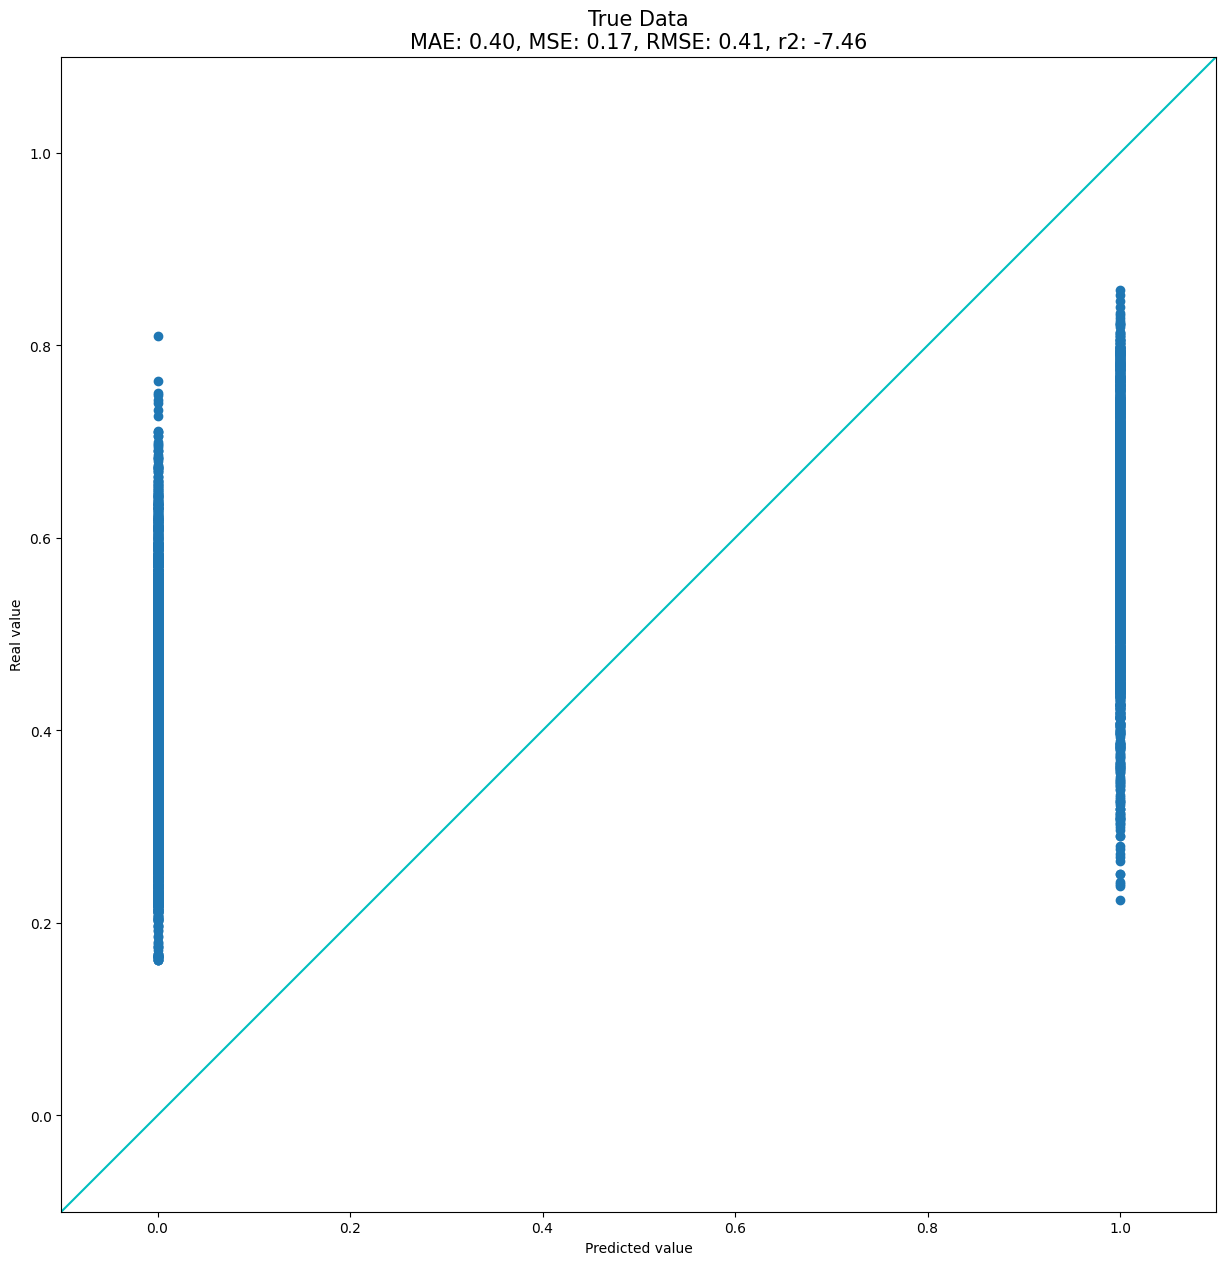

In [36]:
# Plot predicted accuracy for GWR (scatter plot)
pa_gwr.plot_scatter(save_fig=SAVE_FIGS, root_name=DIR_GWR + "gwr_model")

### Model Residuals

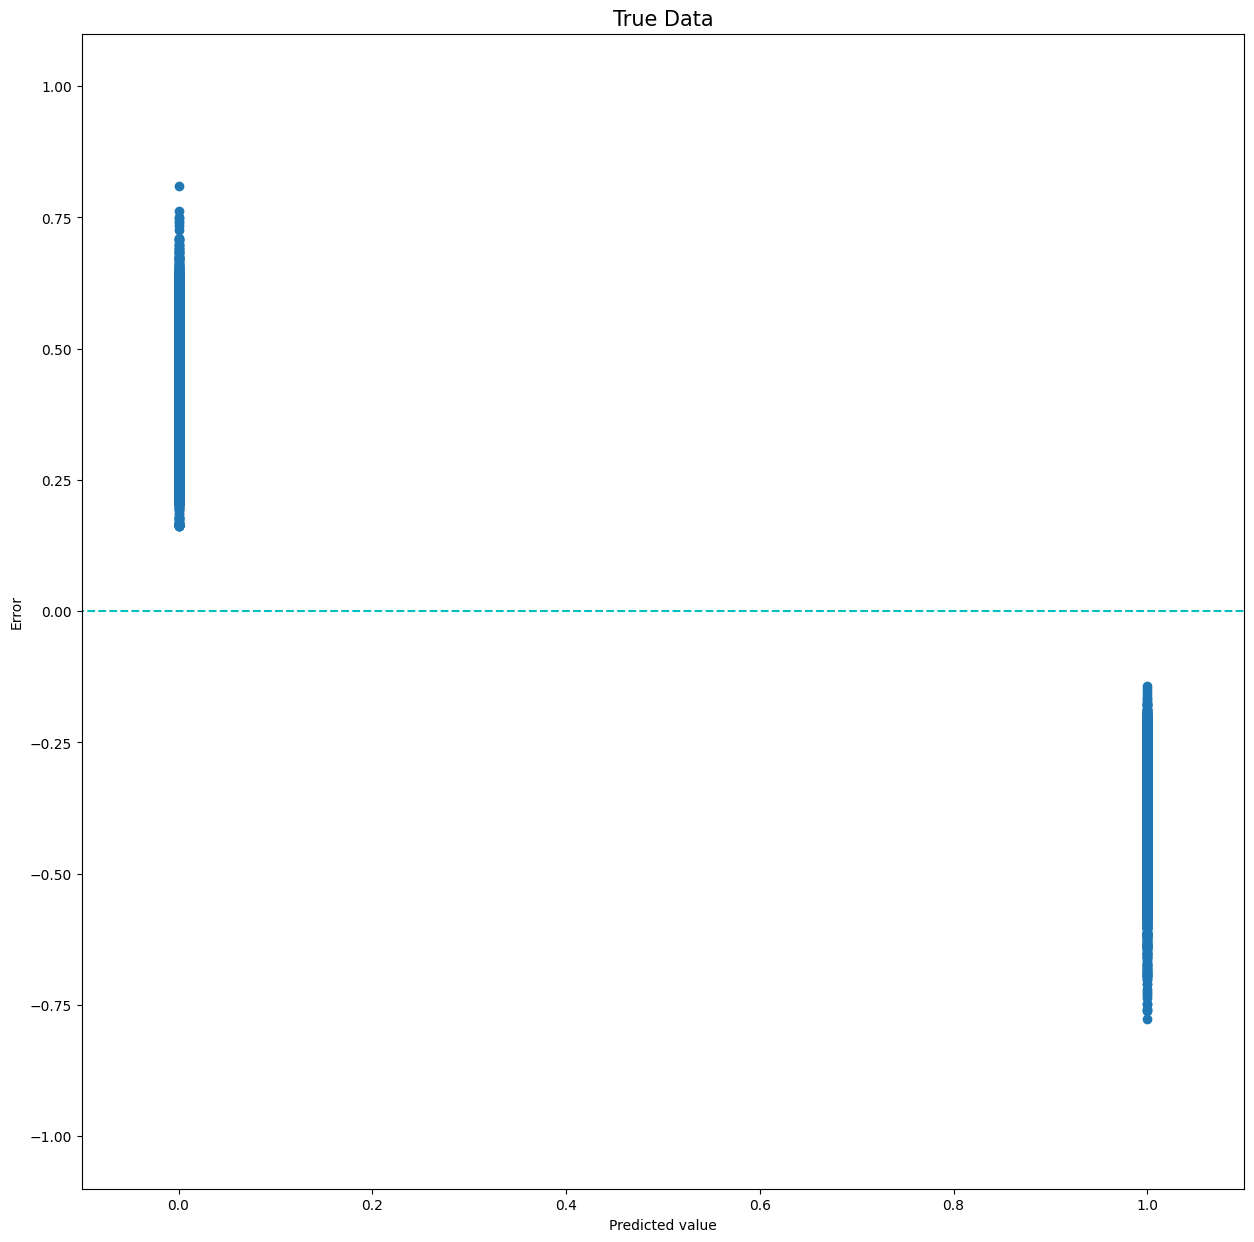

In [37]:
# Plot predicted accuracy for GWR (errors)
pa_gwr.plot_errors(save_fig=SAVE_FIGS, root_name=DIR_GWR + "gwr_model")

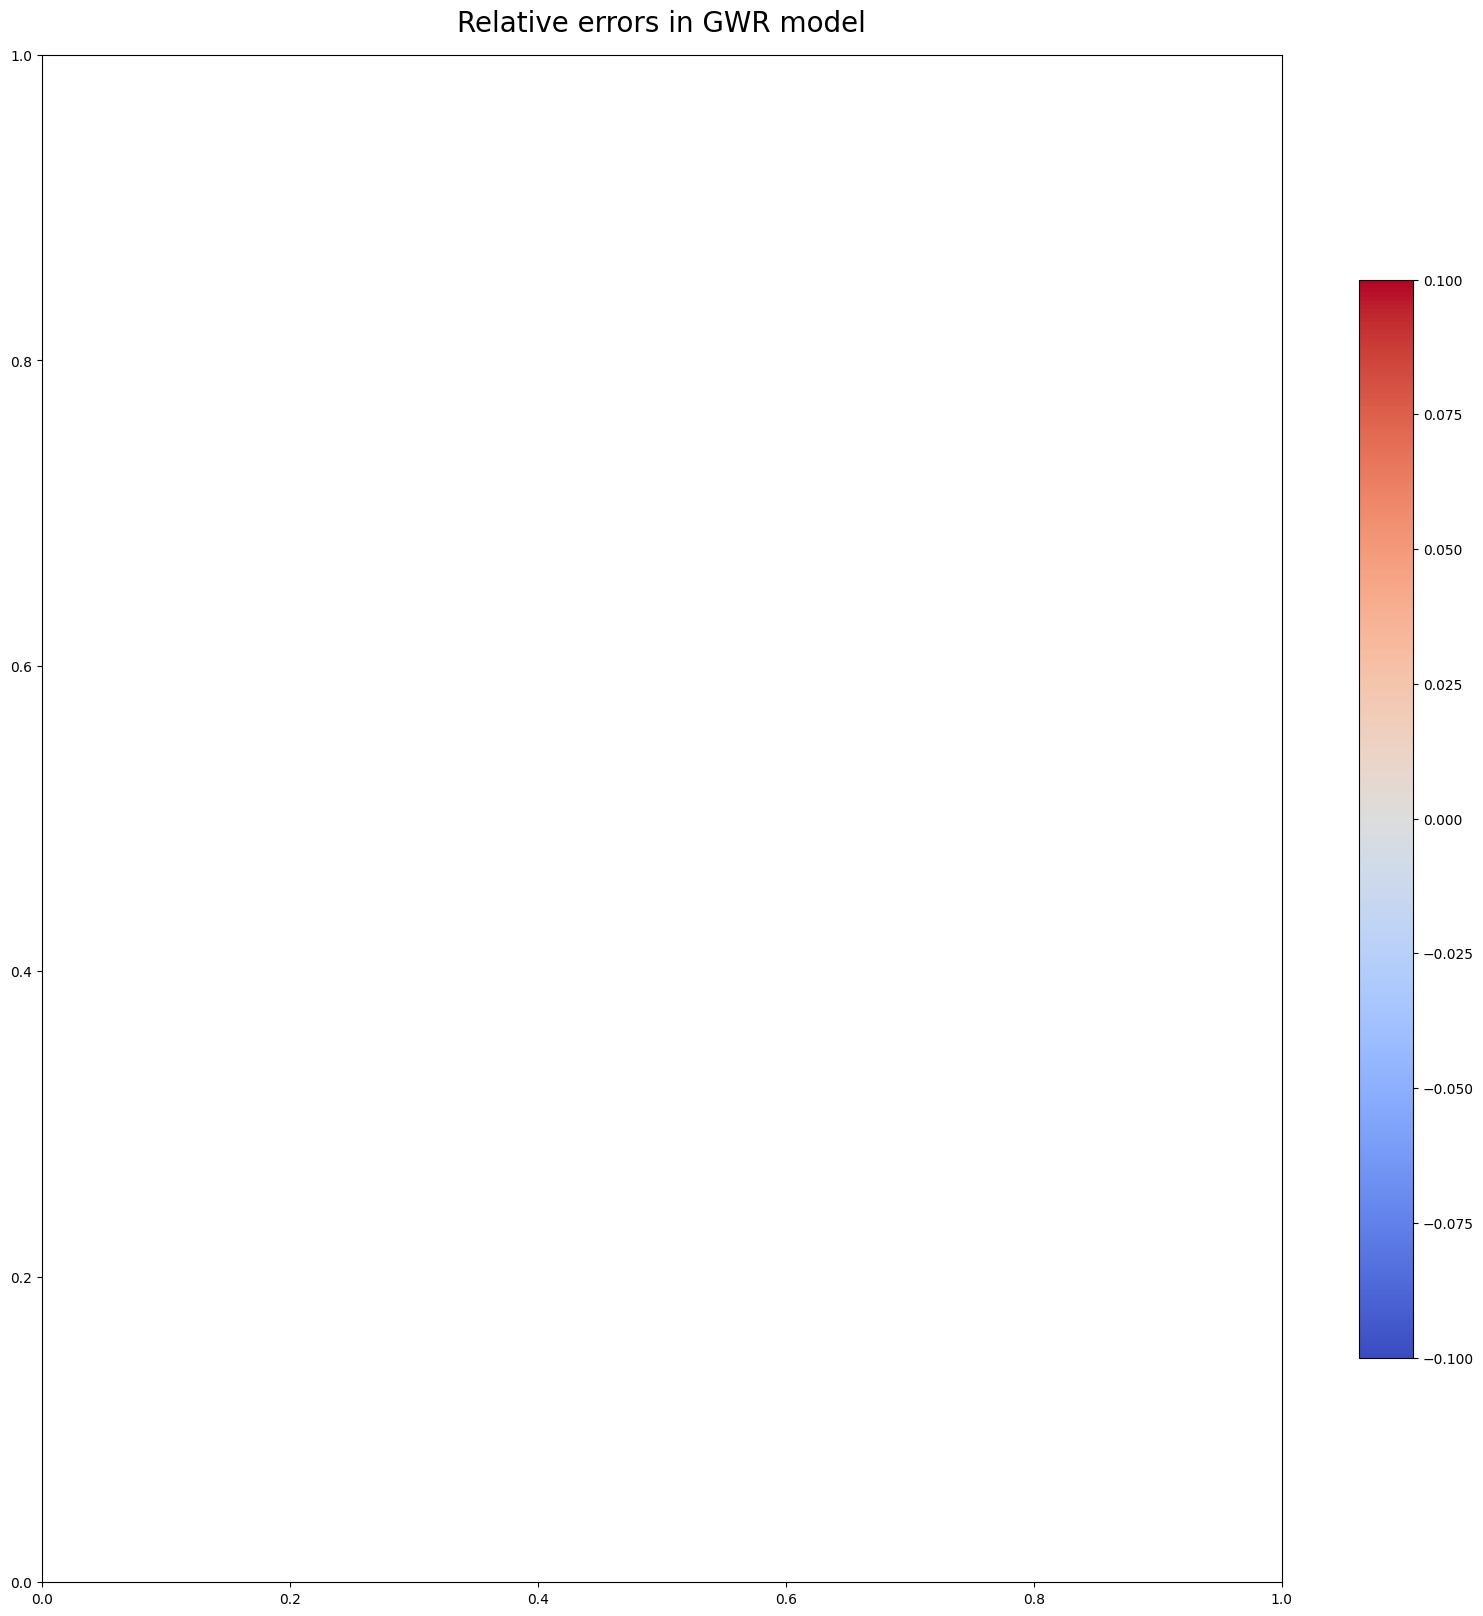

In [38]:
# Plot relative errors in linear model on map
geo_info["Chosen_Error"] = 2 * (y_truth - y_predicted) / (abs(y_truth) + abs(y_predicted))

col_lim = max(abs(geo_info["Chosen_Error"].min()), abs(geo_info["Chosen_Error"].max()))

fig, ax = plt.subplots(figsize=(20, 20))

geo_info.plot(
    ax=ax,
    column="Chosen_Error",
    edgecolor=line_color(AREA_TO_PREDICT),
    legend=True,
    figsize=(20, 20),
    cmap="coolwarm",
    vmin=-col_lim,
    vmax=col_lim,
    legend_kwds={"shrink": 0.7},
)

ax.set_title("Relative errors in GWR model", fontsize=20, y=1.01)


if SAVE_FIGS is True:
    plt.savefig(DIR_GWR + "relative_errors.svg", format="svg")

plt.show()

## Transformed GWR Model

In [39]:
# Define predicted accuracy for model with transformed GWR
y_predicted_transformed = pd.Series(y_predicted_transformed.flatten(), name="GWR_predicted_transformed")
y_transformed = pd.Series(y_transformed.flatten(), name="GWR_transformed")
pa_gwr_tf = PredictedAccuracy(y_transformed, y_predicted_transformed)

### Model Fit

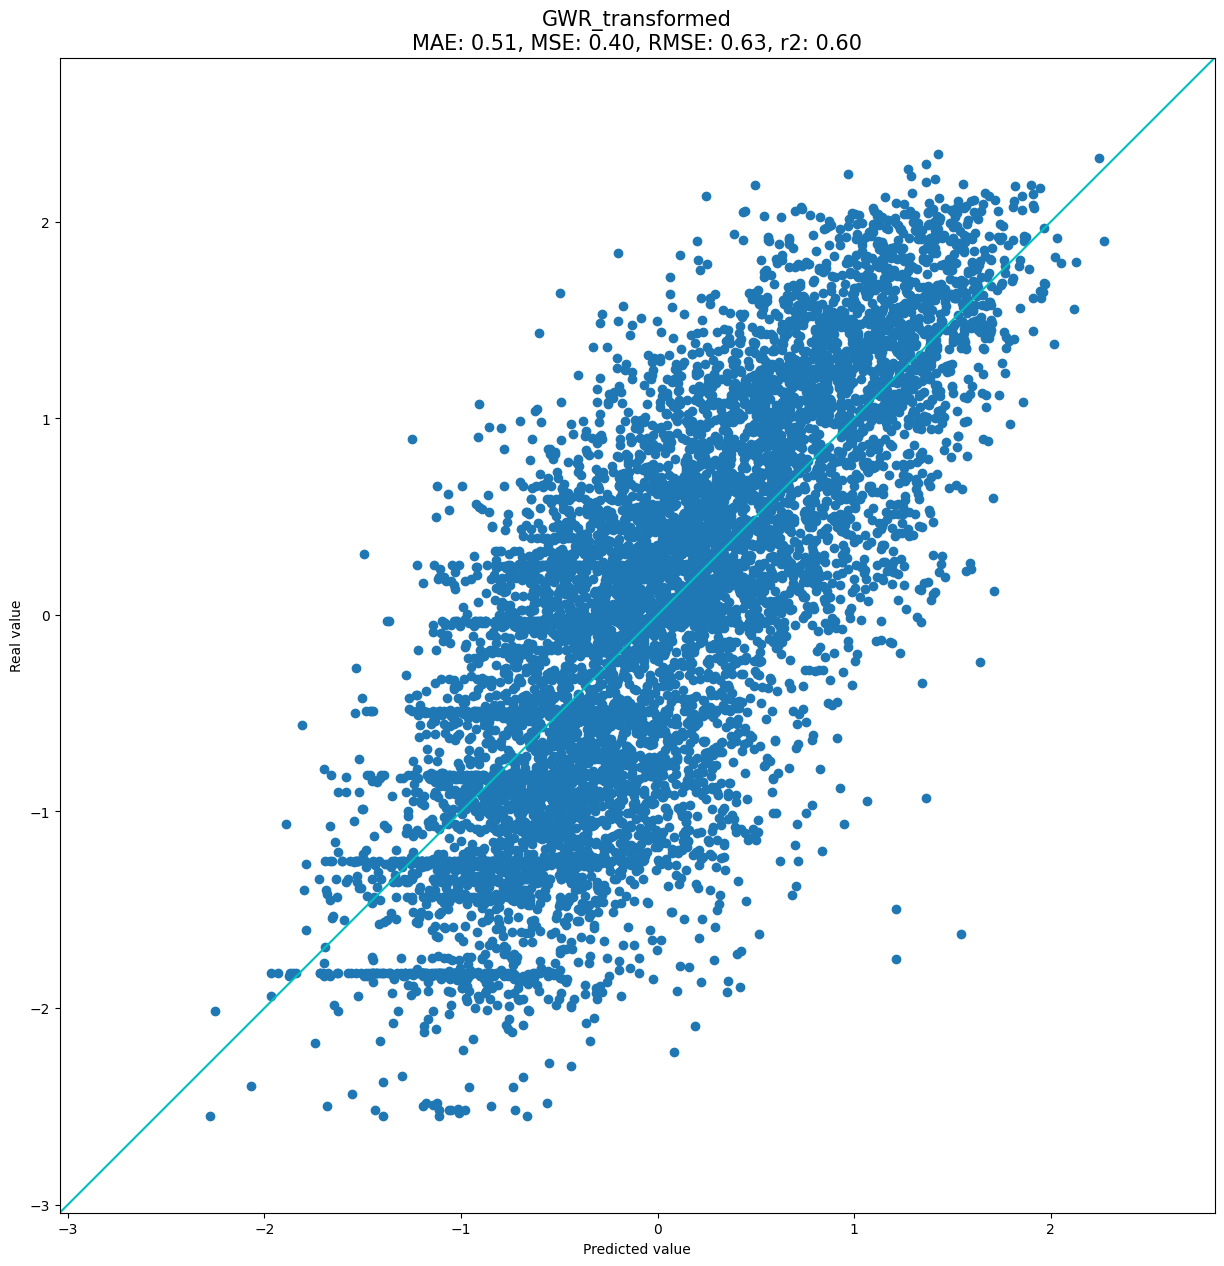

In [40]:
# Plot predicted accuracy for transformed GWR (scatter plot)
pa_gwr_tf.plot_scatter(save_fig=SAVE_FIGS, root_name=DIR_GWR + "gwr_transformed")

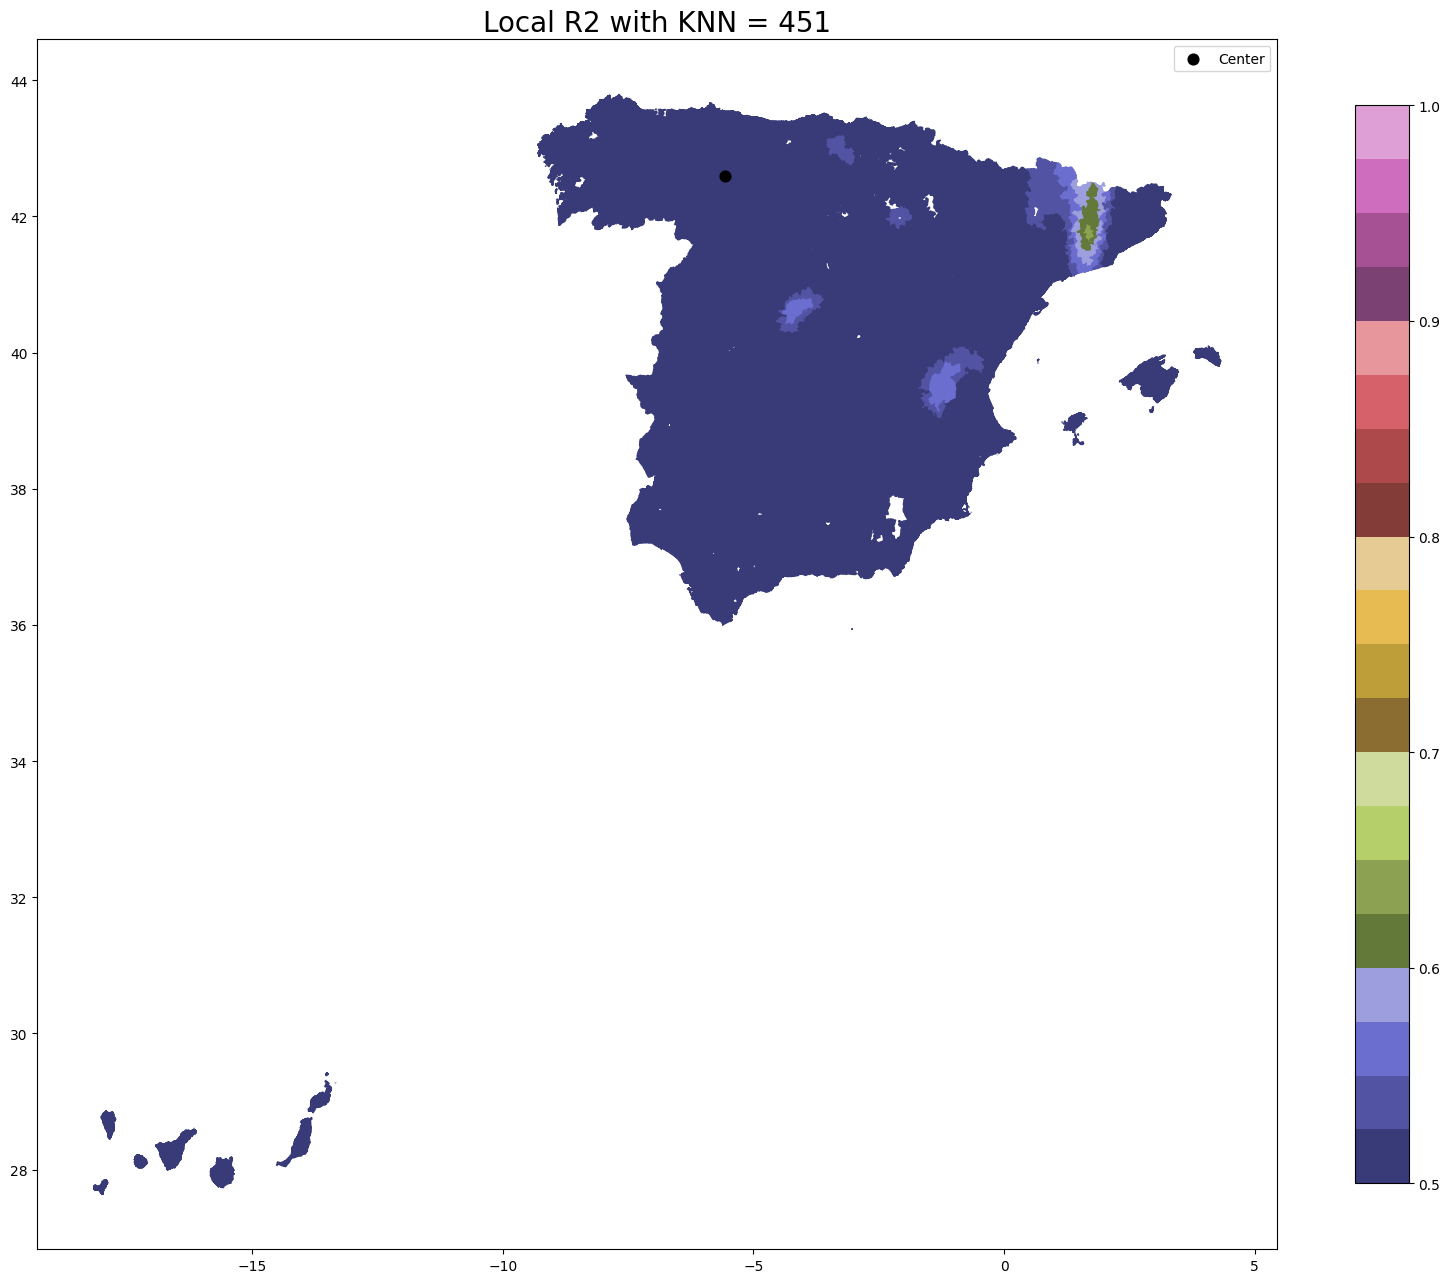

In [41]:
# Define and plot Local R2
geo_info["Chosen_Local_R2"] = gwr_results.localR2

fig, ax = plt.subplots(figsize=(20, 20))
geo_info.plot(
    ax=ax,
    edgecolor=line_color(AREA_TO_PREDICT),
    column="Chosen_Local_R2",
    legend=True,
    vmin=0.5,
    vmax=1,
    cmap="tab20b",
    legend_kwds={"shrink": 0.7},
)
geo_info[geo_info.index == id_max_KPI].centroid.plot(
    ax=ax, color="black", markersize=60, label="Center"
)

plt.legend()

ax.set_title(
    "Local R2 with KNN = {}".format(int(gwr_bw)),
    fontsize=20,
)

if SAVE_FIGS:
    plt.savefig(DIR_GWR + "local_r2.svg", format="svg")

plt.show()

### Model Residuals

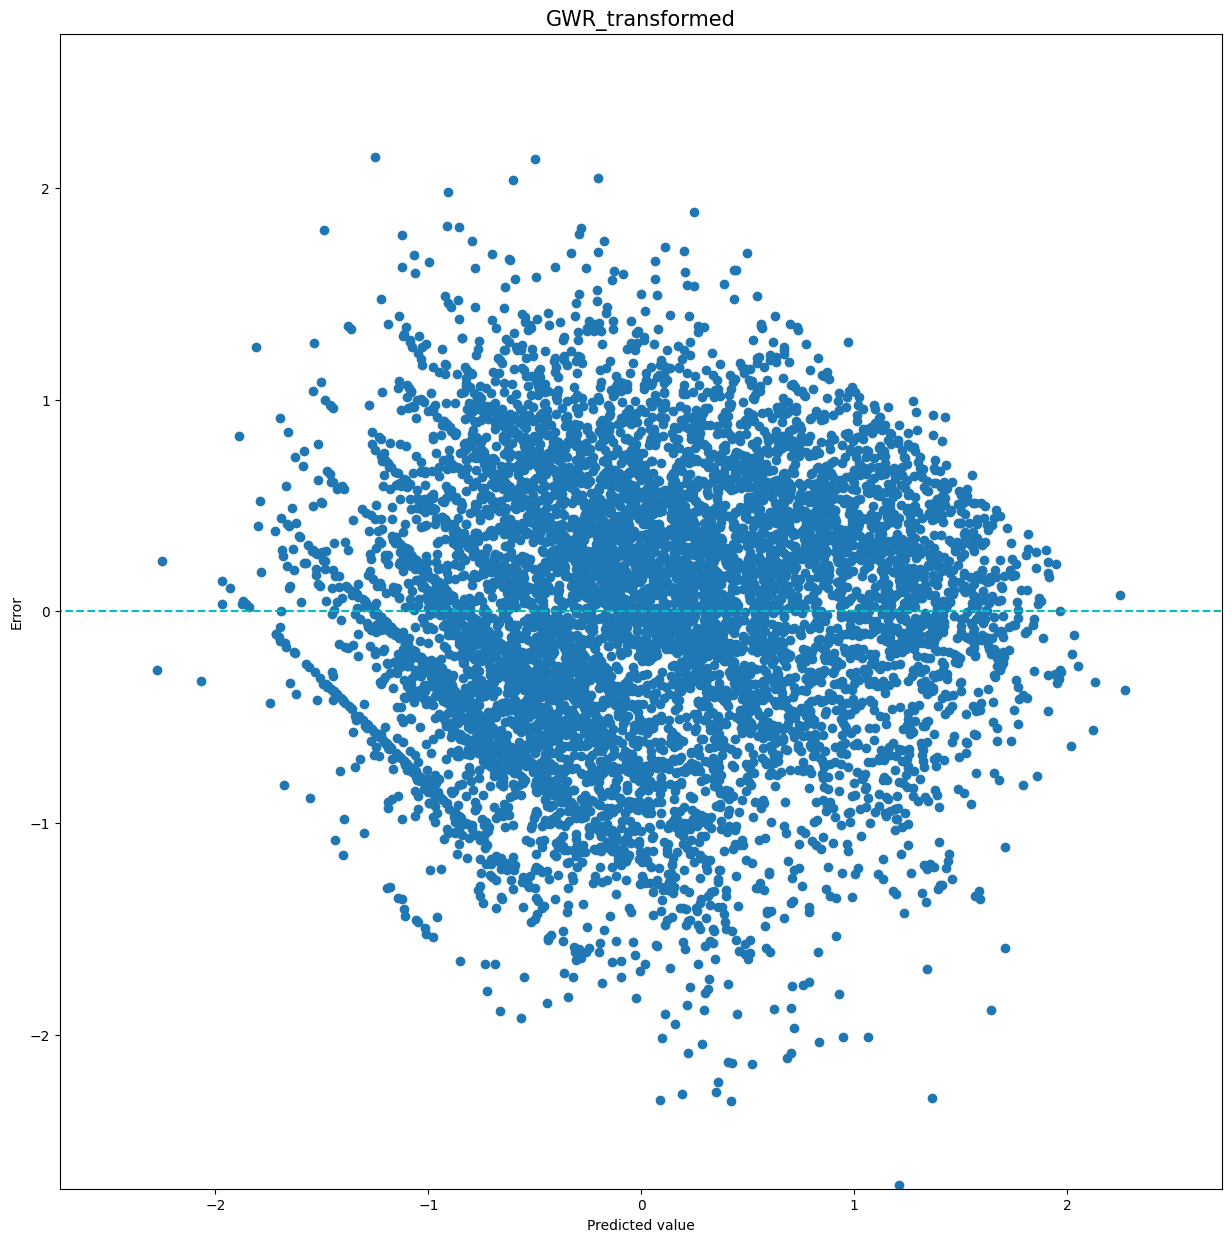

In [42]:
# Plot predicted accuracy for transformed GWR (errors)
pa_gwr_tf.plot_errors(save_fig=SAVE_FIGS, root_name=DIR_GWR + "gwr_transformed")

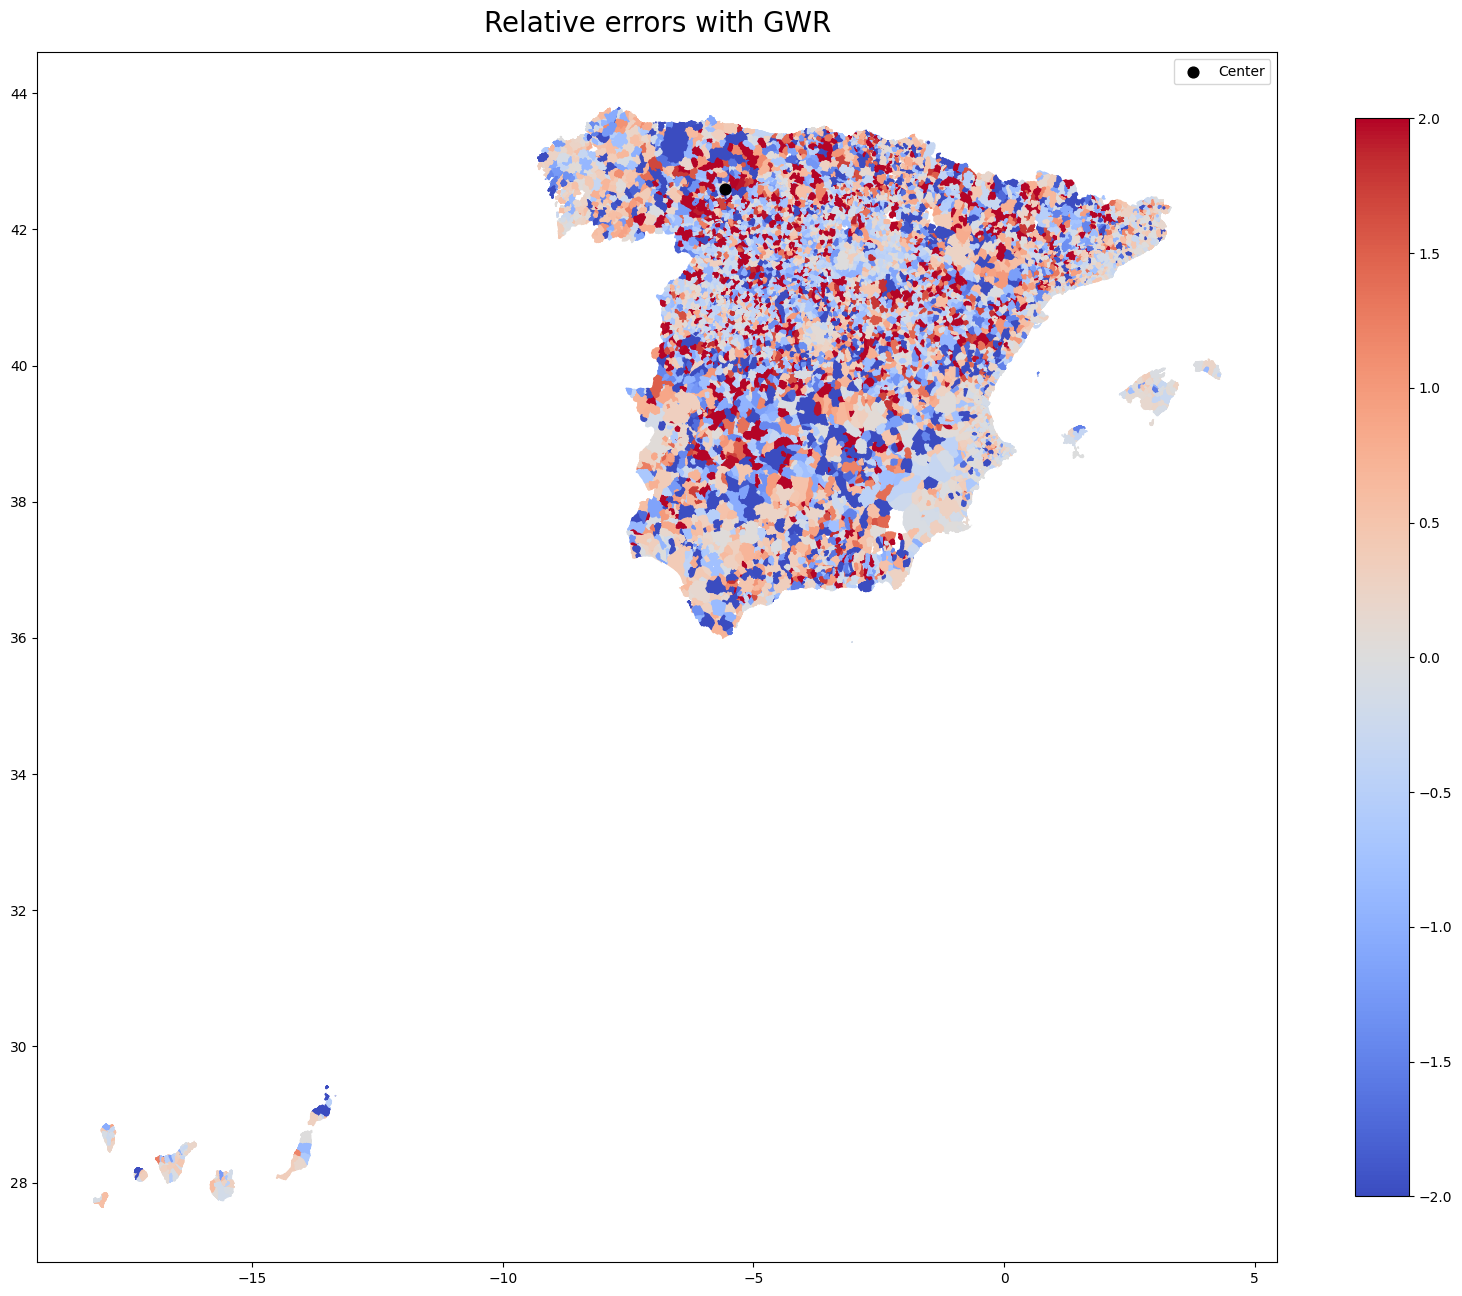

In [43]:
# Define relative errors of model
geo_info["Chosen_Error"] = (
    2
    * (y_transformed.values - y_predicted_transformed.values)
    / (abs(y_transformed.values) + abs(y_predicted_transformed.values))
)

col_lim = max(abs(geo_info["Chosen_Error"].min()), abs(geo_info["Chosen_Error"].max()))

# Plot relative errors of model
fig, ax = plt.subplots(figsize=(20, 20))
geo_info.plot(
    ax=ax,
    column="Chosen_Error",
    edgecolor=line_color(AREA_TO_PREDICT),
    legend=True,
    vmin=-col_lim,
    vmax=col_lim,
    cmap="coolwarm",
    legend_kwds={"shrink": 0.7},
)

geo_info[geo_info.index == id_max_KPI].centroid.plot(
    ax=ax, color="black", markersize=60, label="Center"
)

plt.legend()

ax.set_title("Relative errors with GWR", fontsize=20, y=1.01)

if SAVE_FIGS:
    plt.savefig(DIR_GWR + "relative_errors.svg", format="svg")

plt.show()

### Areas of importance of each feature

In [44]:
# Define areas of importance of each feature in model
gwr_columns = best_model.copy()
if FIT_INTERCEPT:
    gwr_columns = gwr_columns.insert(0, "Intercept")
coefs_gwr = pd.DataFrame(gwr_results.params, columns=gwr_columns)

# Define median 
medians_gwr = coefs_gwr.median()
medians_gwr = medians_gwr.reindex(medians_gwr.abs().sort_values(ascending=False).index)
coefs_gwr = coefs_gwr[medians_gwr.index]

limit_value = (
    max(abs(coefs_gwr.to_numpy().min()), abs(coefs_gwr.to_numpy().max())) * 1.05
)

In [45]:
limit_value.shape

()

In [46]:
# Copy coefficients in geodataframe to plot
for col in coefs_gwr.columns:
    #     if col != "Intercept":
    #     if True:
    geo_coefs[col] = coefs_gwr[col].values

In [47]:
# Define t-values of coefficientes
gwr_filtered_t = pd.DataFrame(gwr_results.filter_tvals(), columns=gwr_columns)
gwr_filtered_t.index = geo_info.index

# Copy coefficients in new dataframe
geo_significant_coefs = geo_coefs.copy()

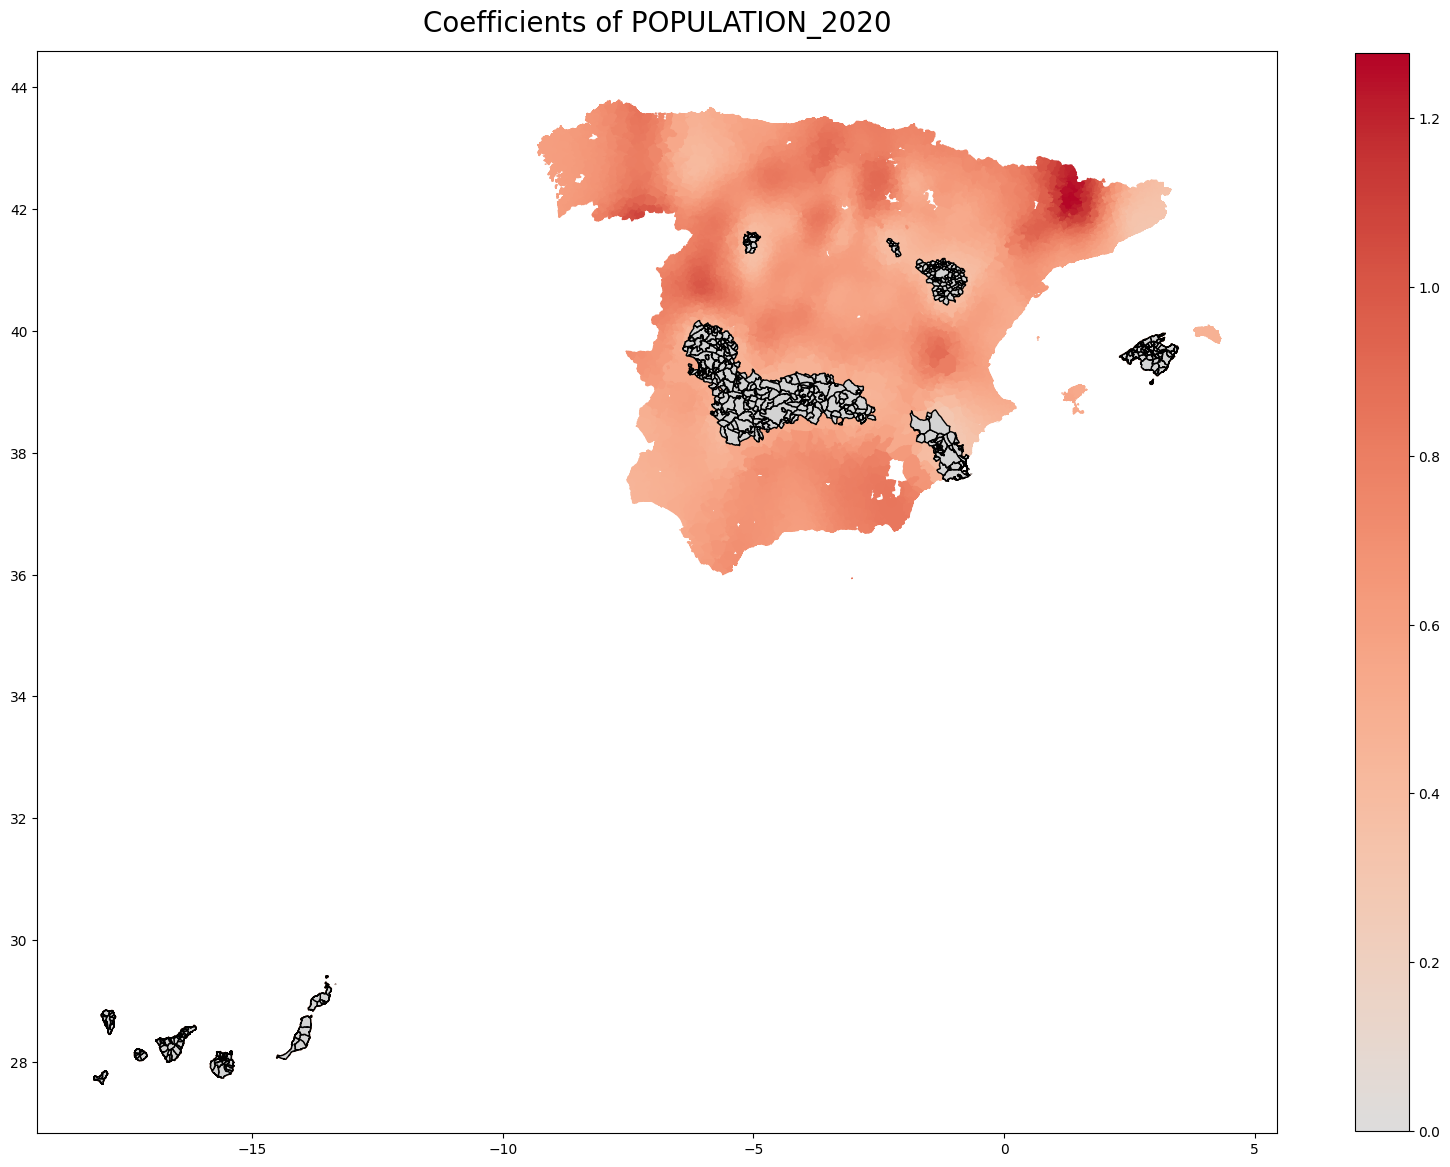

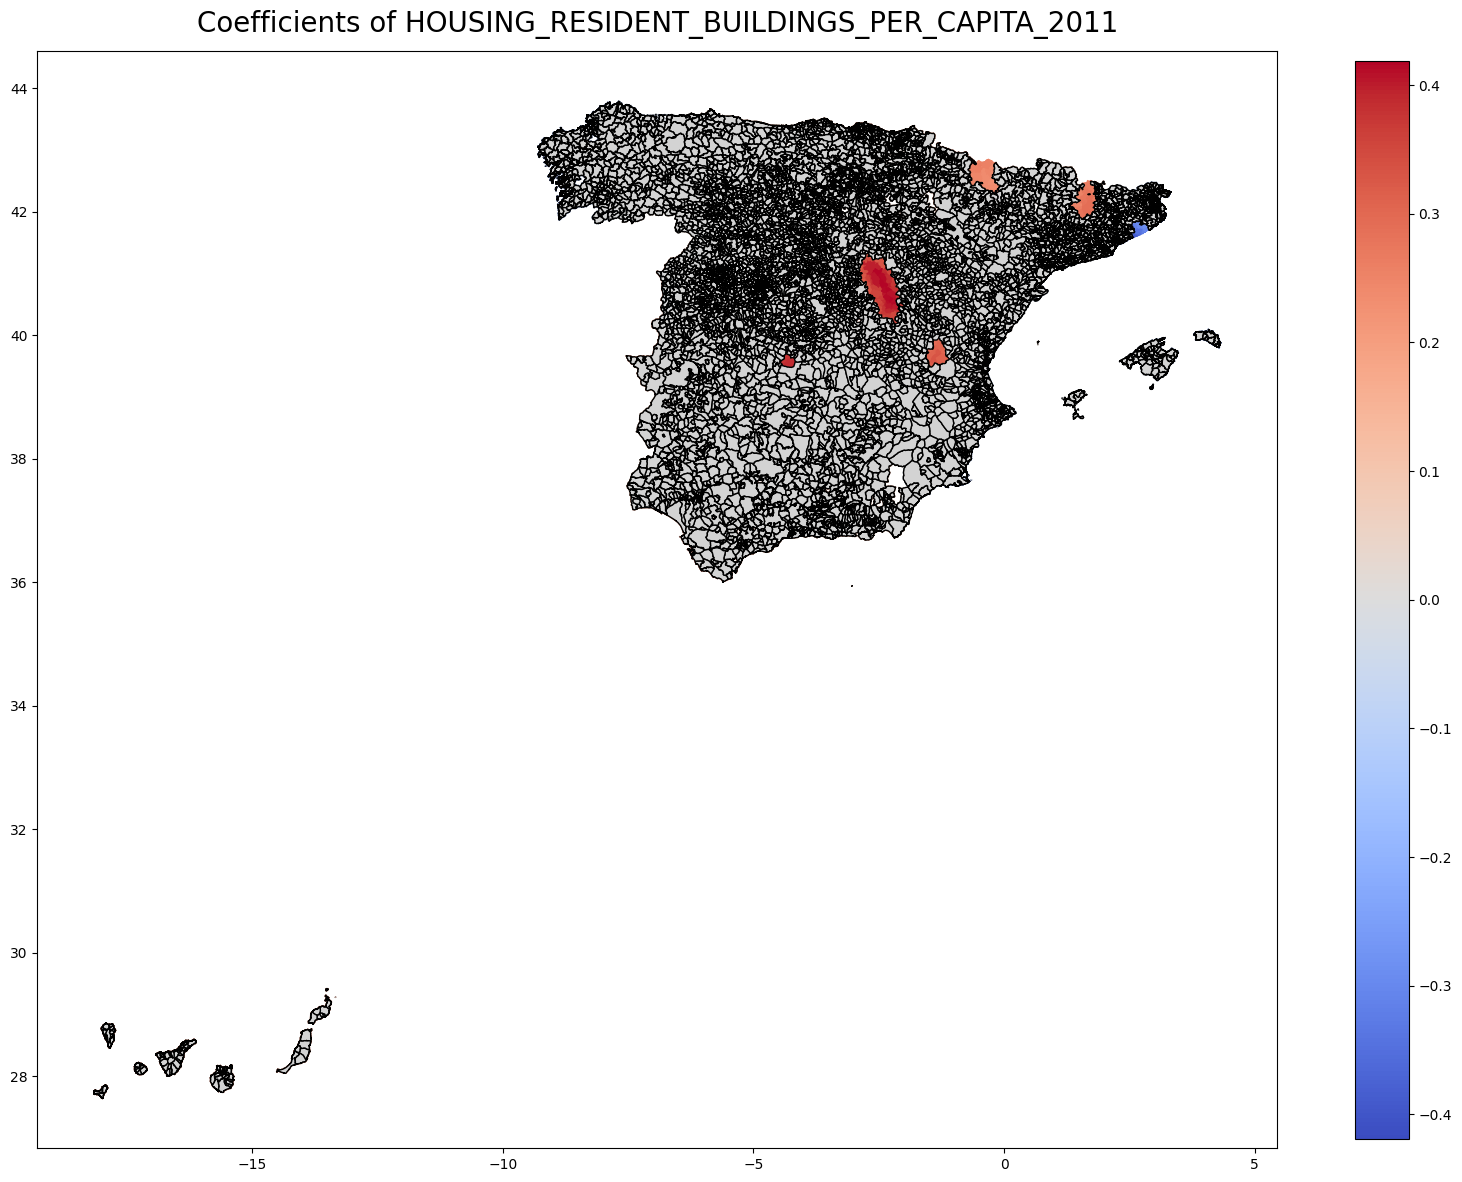

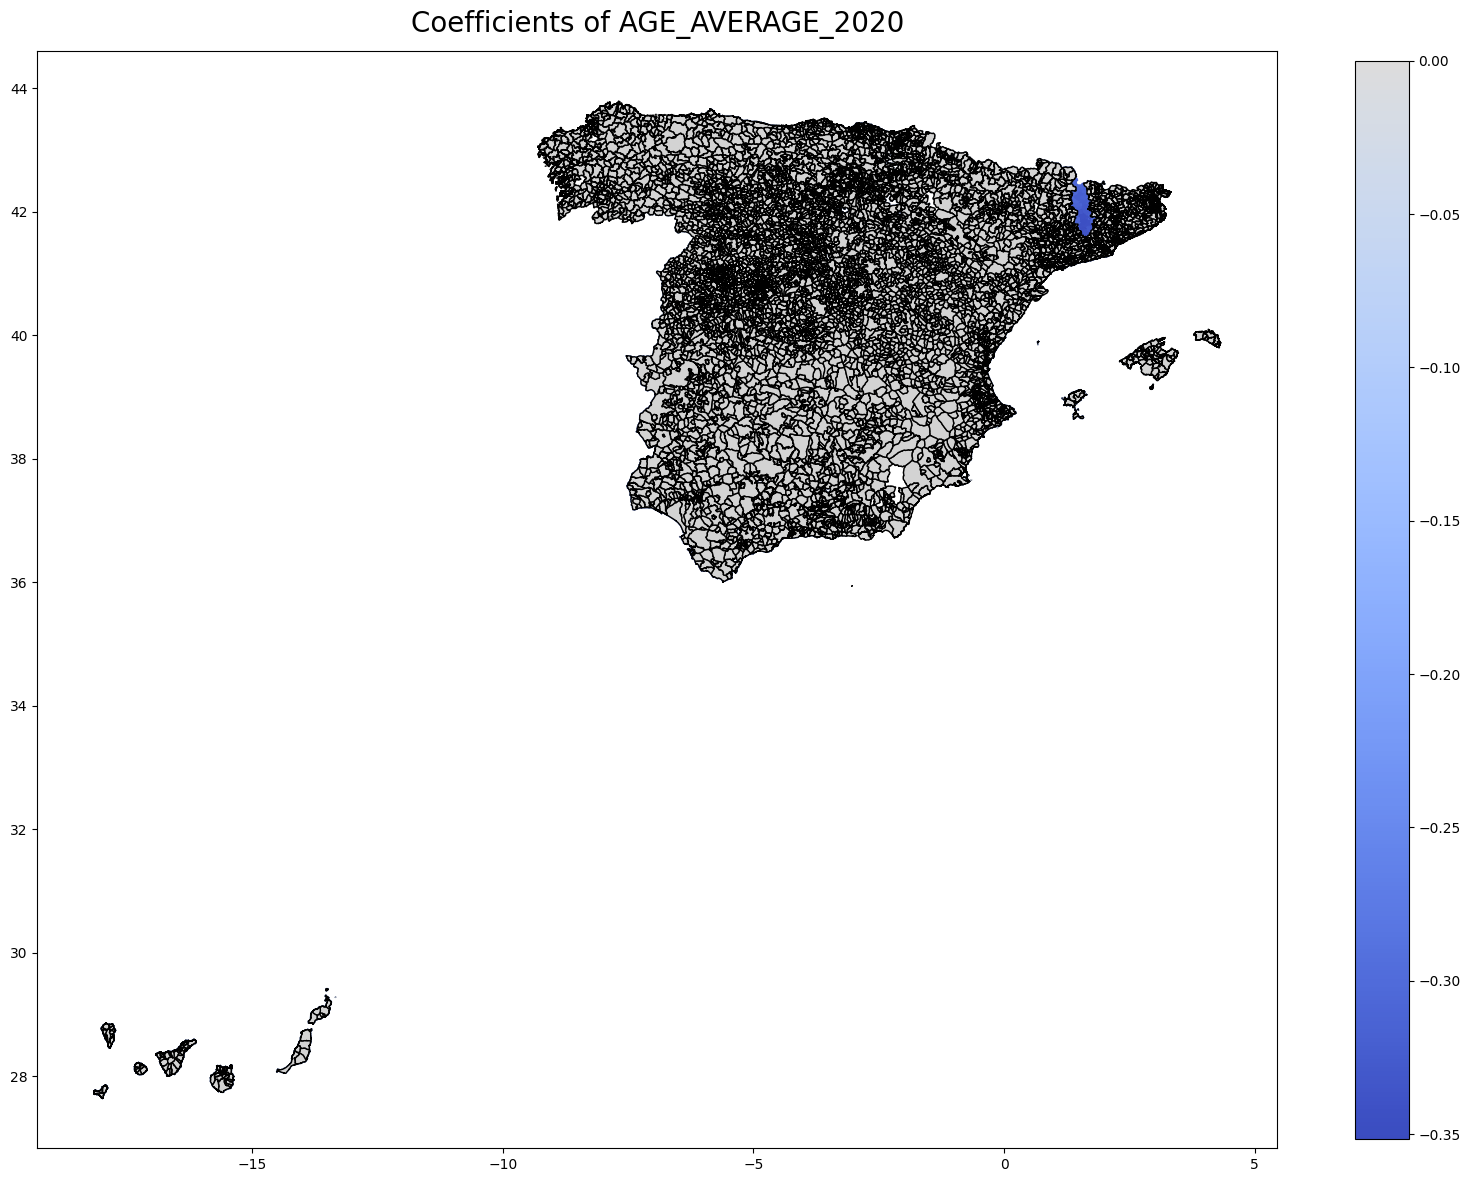

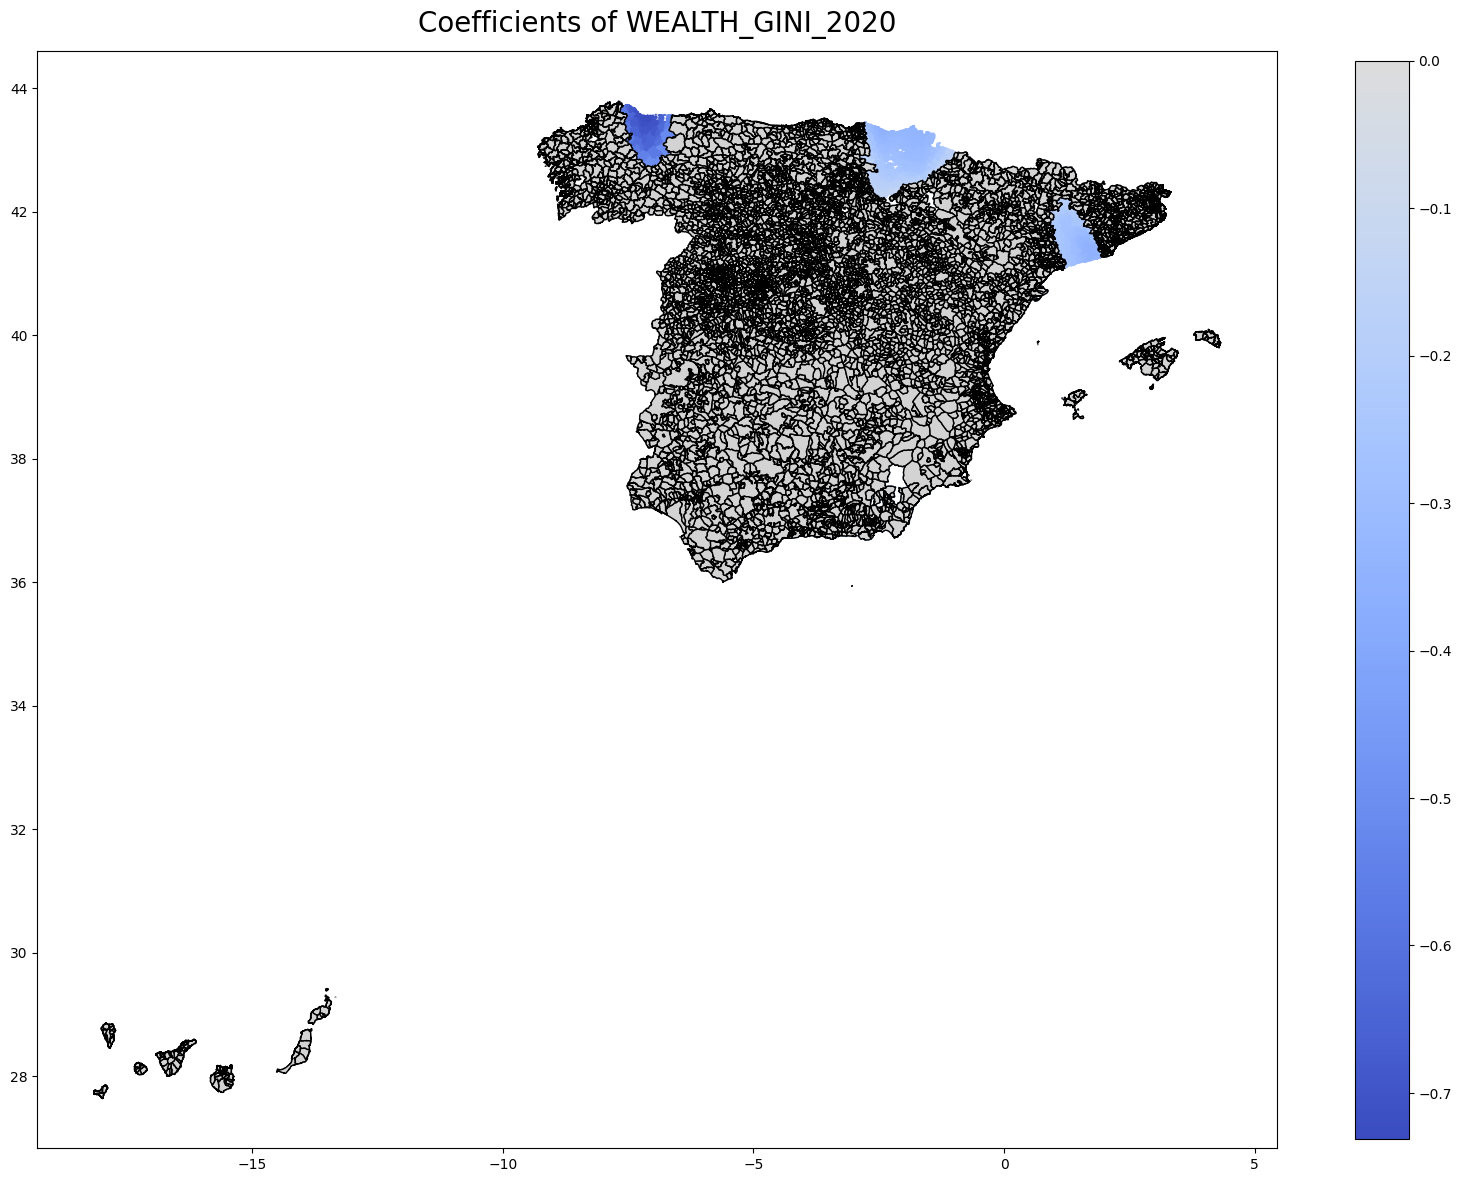

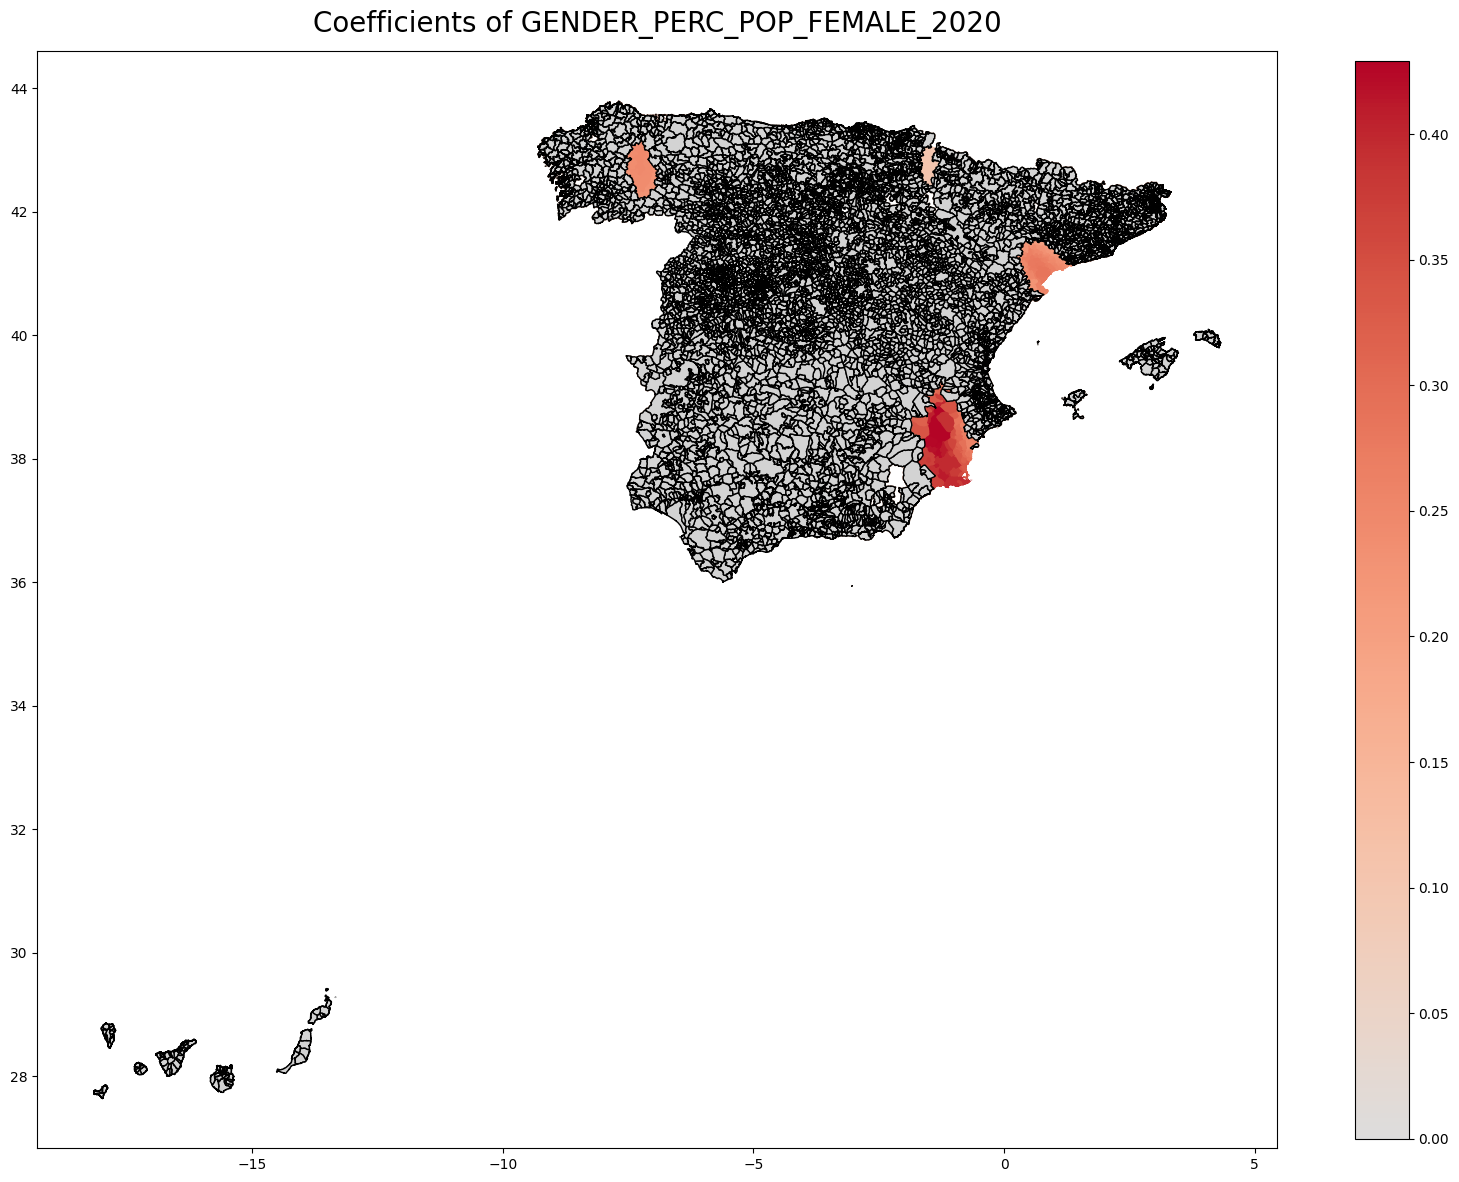

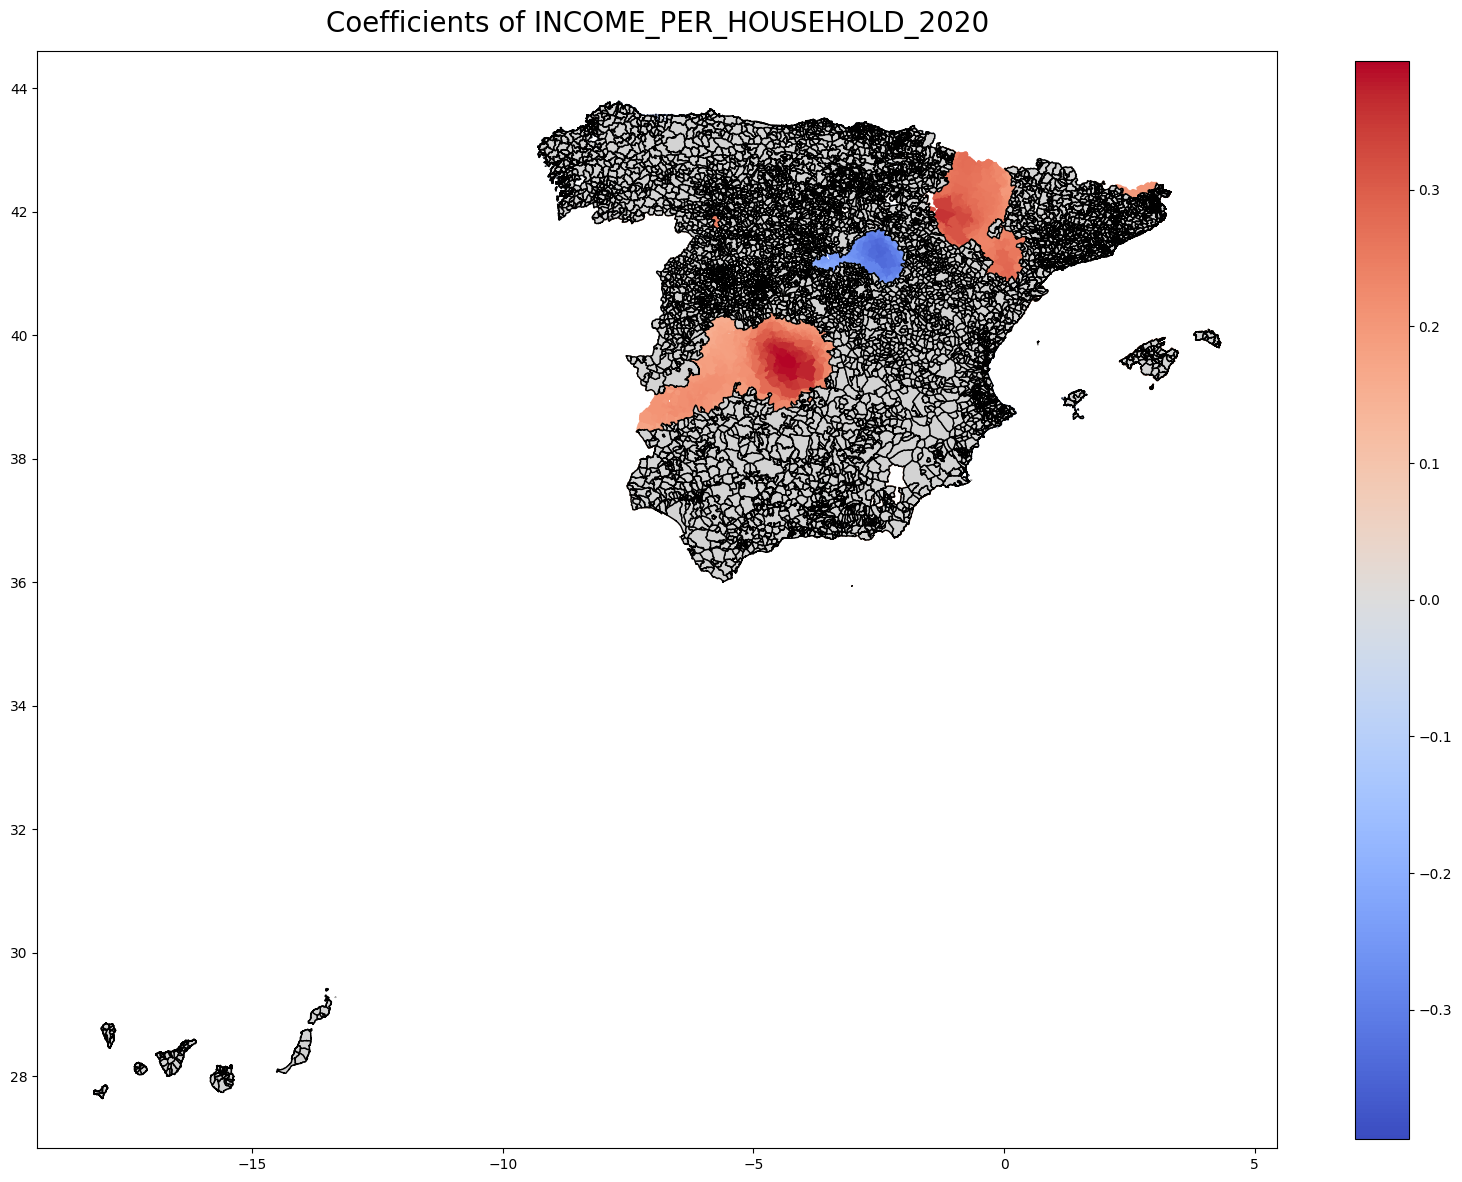

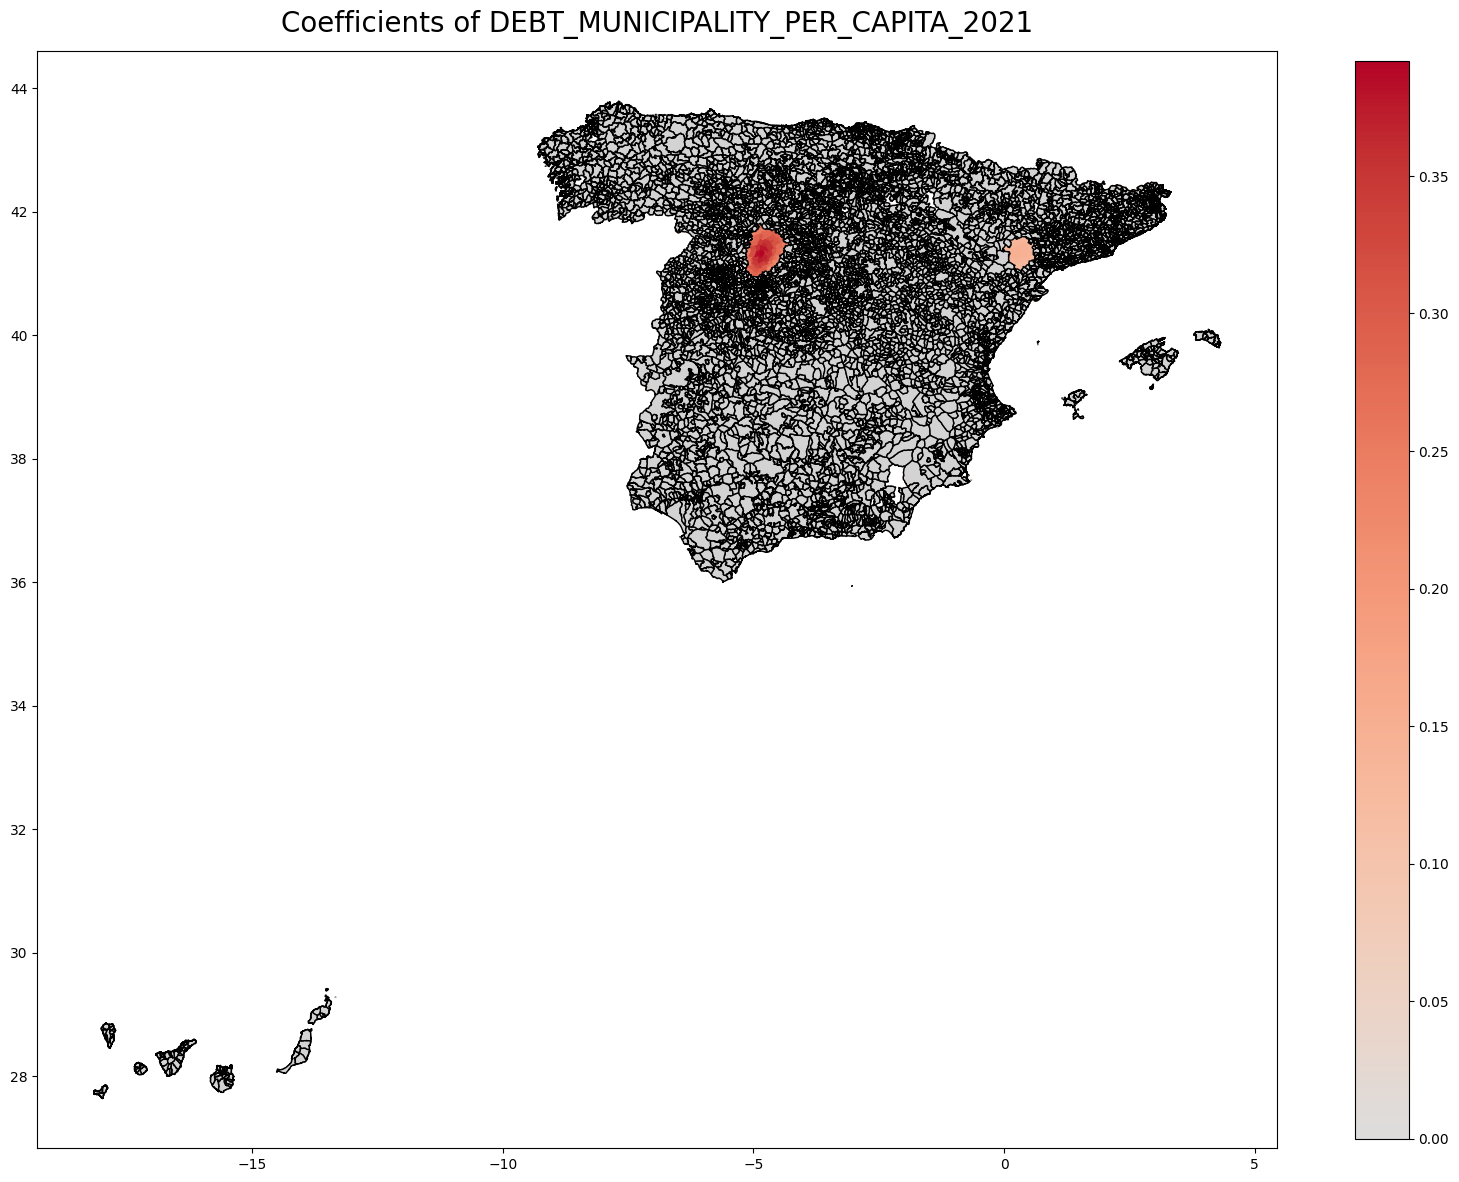

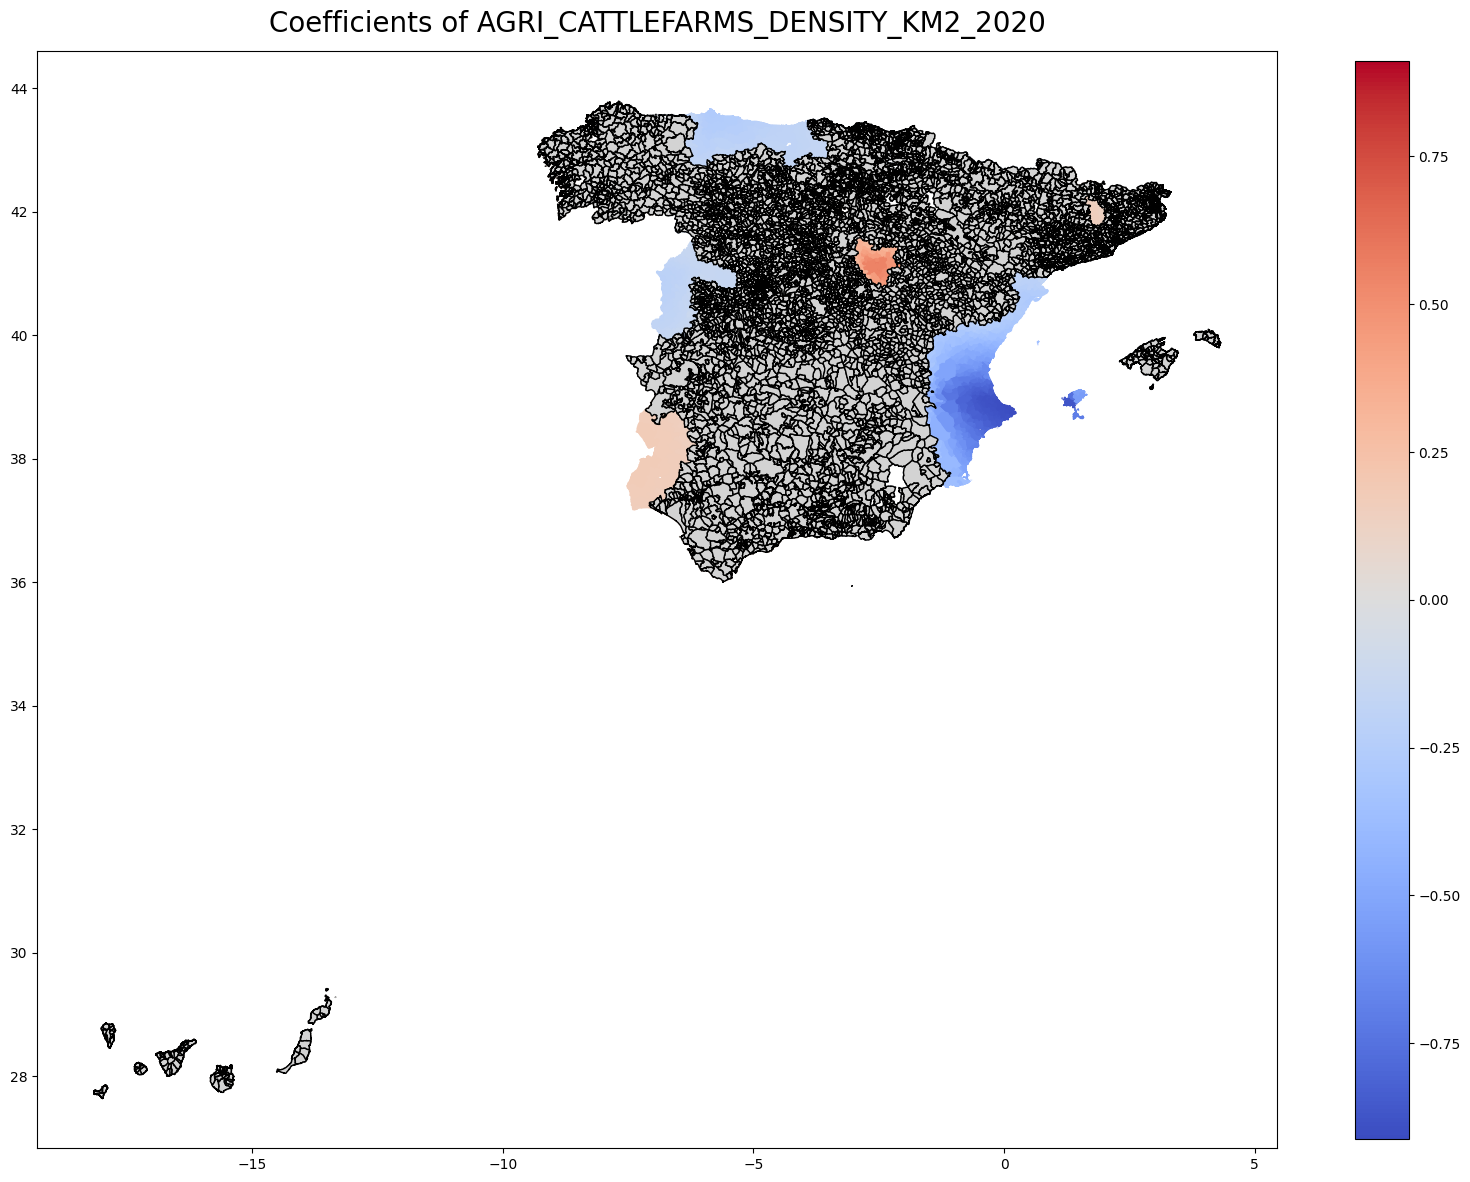

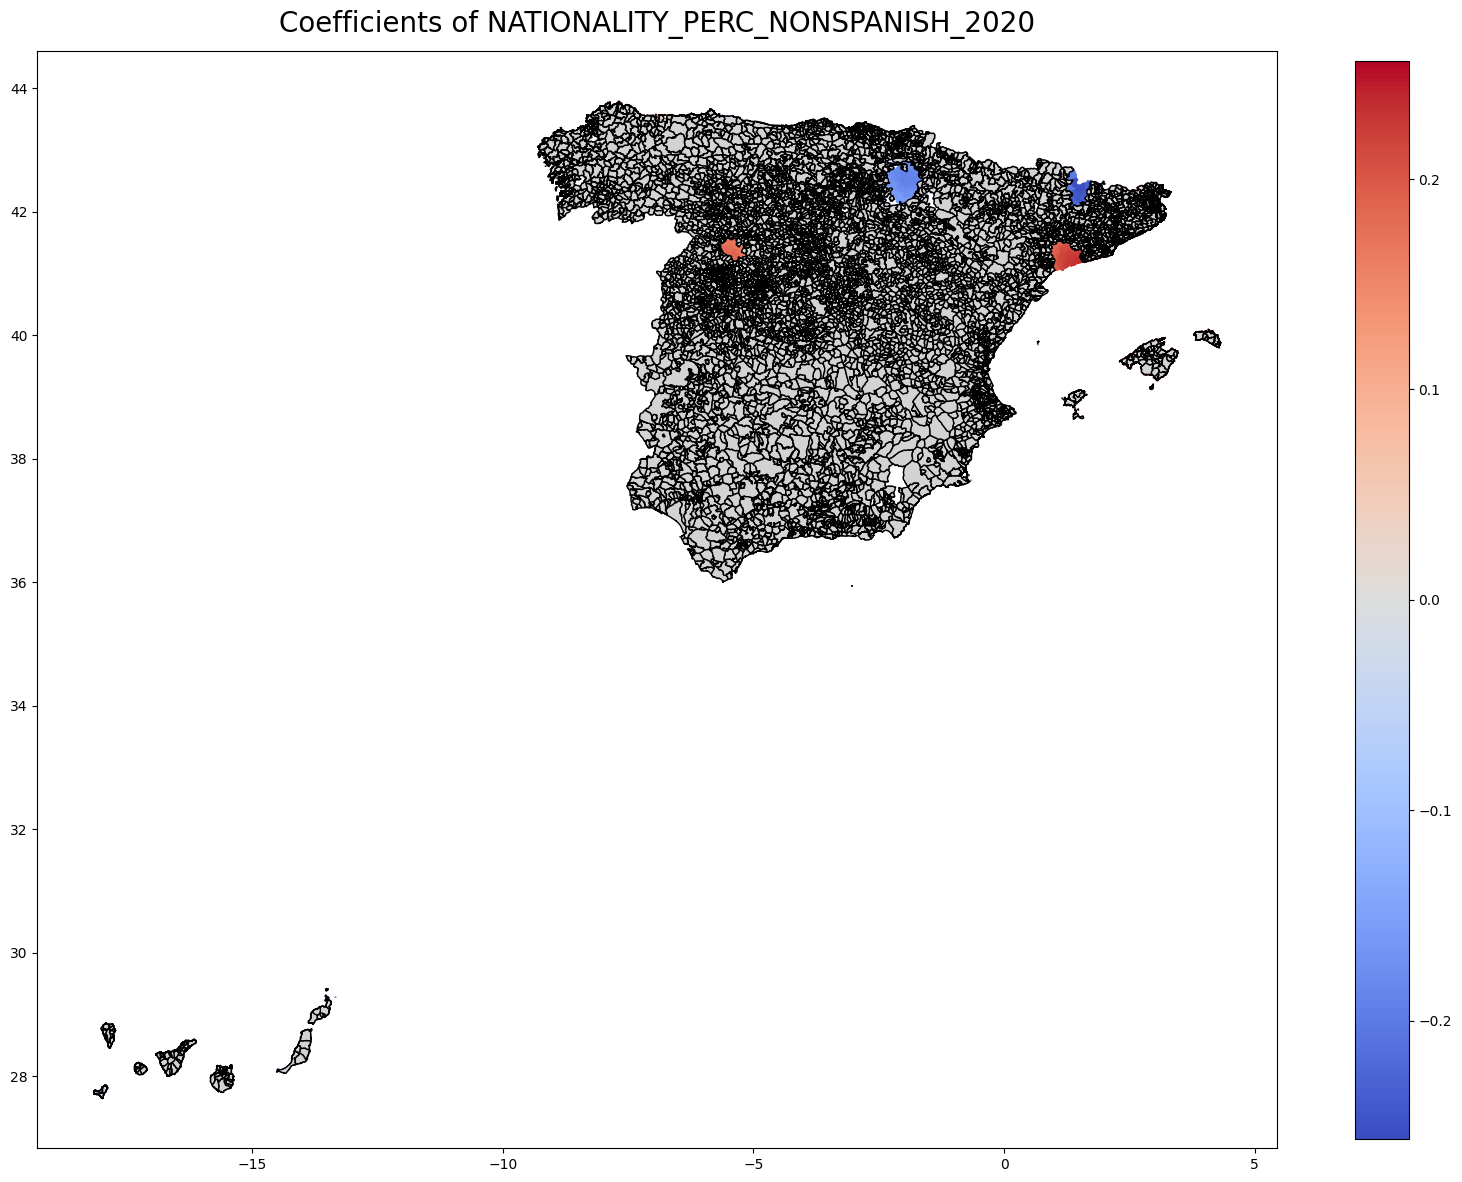

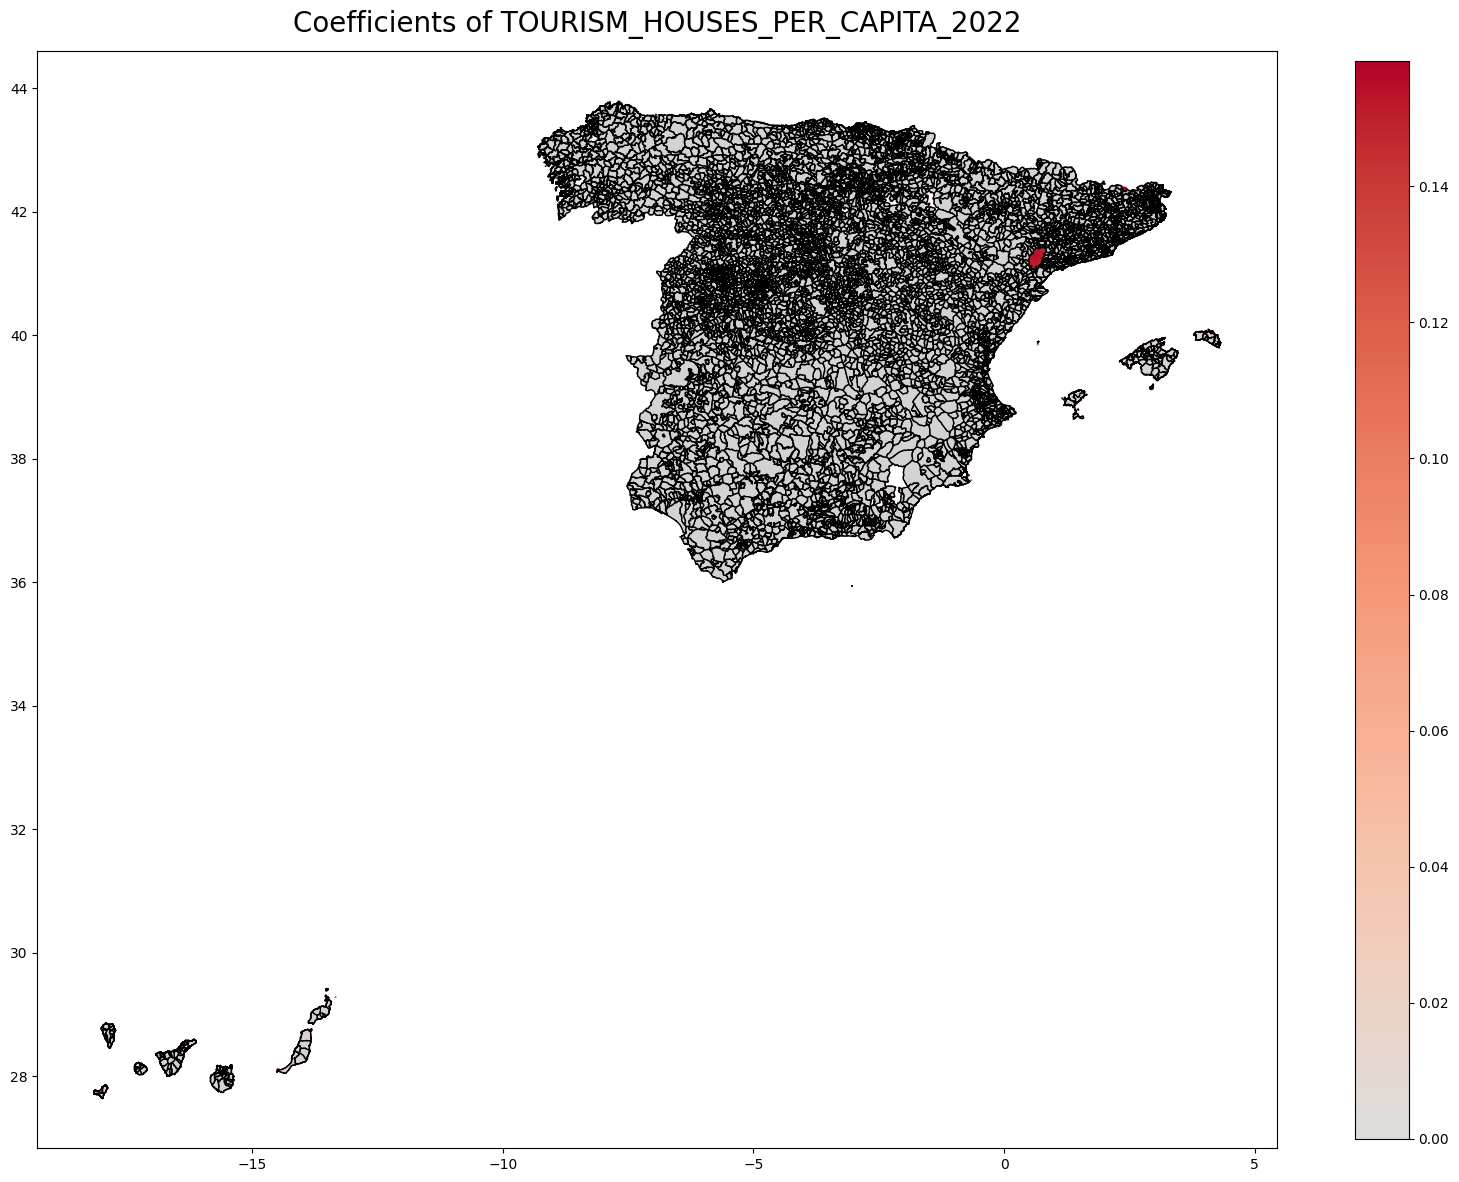

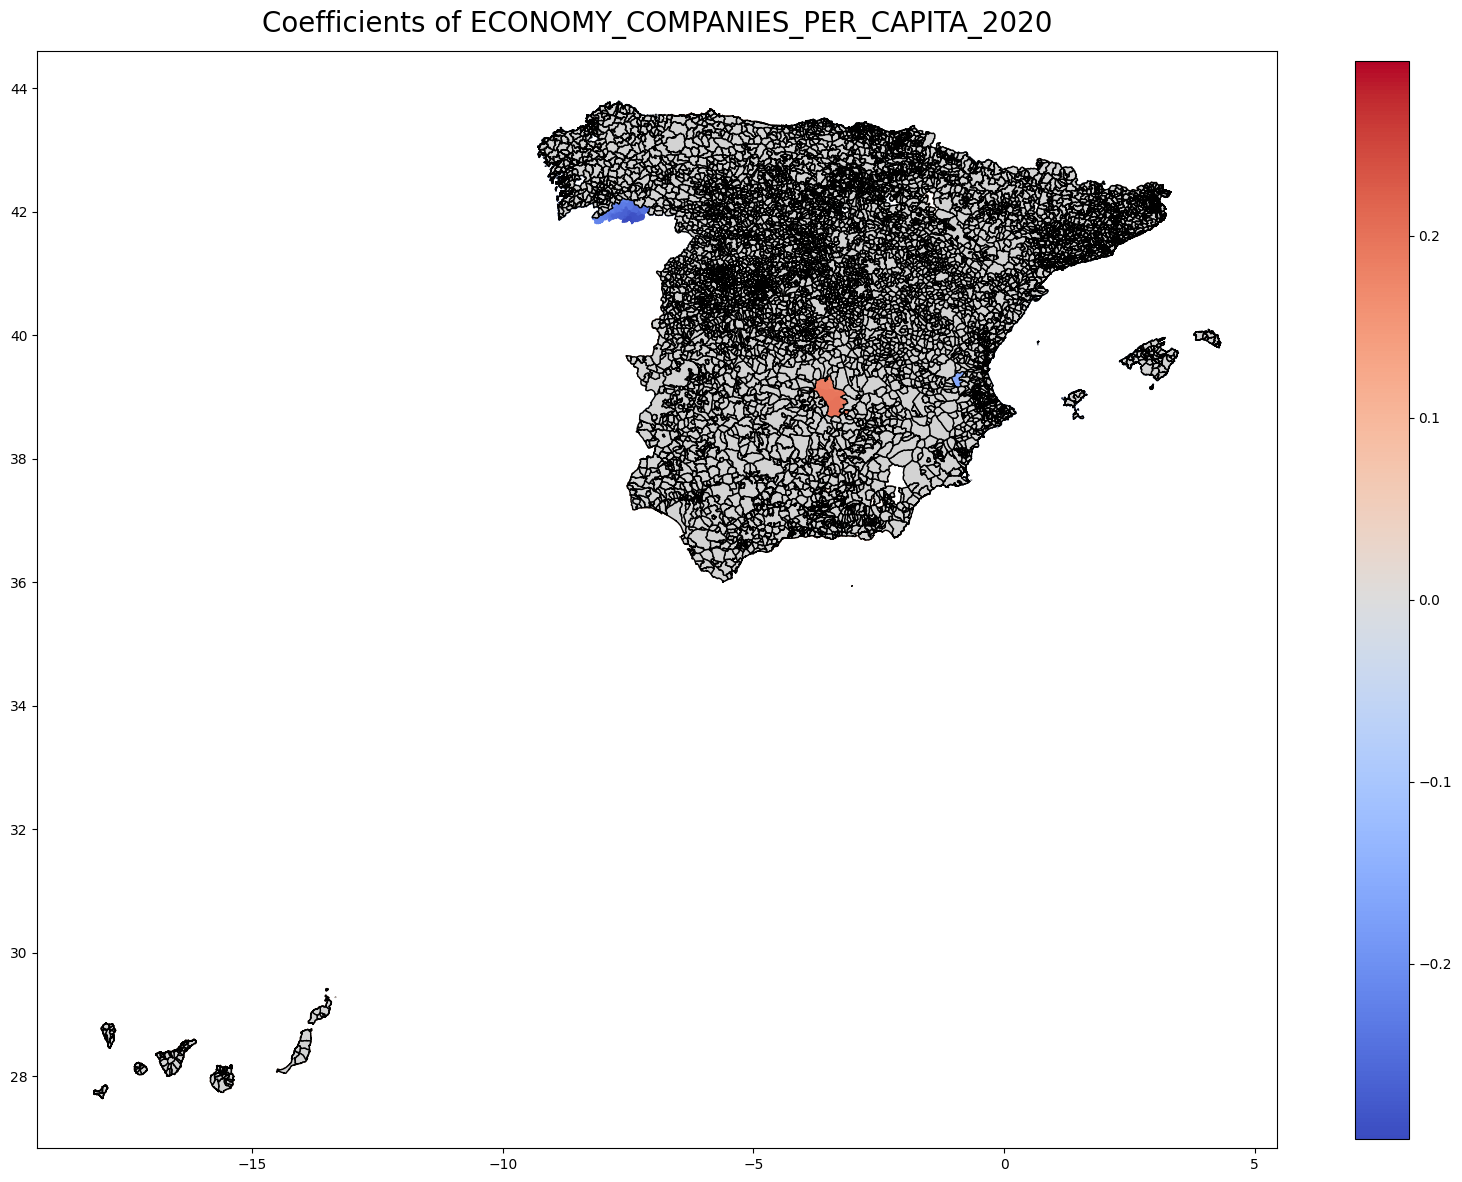

In [48]:
# Define and plot coefficients for each independent variable
for col in coefs_gwr.columns:
    fig, ax = plt.subplots(figsize=(20, 20))
    min_coef = geo_coefs[gwr_filtered_t.loc[:, col] != 0][col].min()
    max_coef = geo_coefs[gwr_filtered_t.loc[:, col] != 0][col].max()

    cool_warm_cmap = plt.cm.coolwarm

    if min_coef < 0 and max_coef < 0:
        interval = np.linspace(0, 0.5)
        colors = cool_warm_cmap(interval)
        cool_warm_cmap = mpl.colors.LinearSegmentedColormap.from_list("name", colors)
        vmin = min_coef
        vmax = 0
    elif min_coef > 0 and max_coef > 0:
        interval = np.linspace(0.5, 1)
        colors = cool_warm_cmap(interval)
        cool_warm_cmap = mpl.colors.LinearSegmentedColormap.from_list("name", colors)
        vmin = 0
        vmax = max_coef
    else:
        vmax = max(abs(min_coef), abs(max_coef))
        vmin = -vmax

    geo_coefs.plot(
        ax=ax,
        edgecolor=line_color(AREA_TO_PREDICT),
        column=col,
        legend=True,
        vmin=vmin,
        vmax=vmax,
        cmap=cool_warm_cmap,
        legend_kwds={"shrink": 0.7},
    )
    if (gwr_filtered_t.loc[:, col] == 0).any():
        geo_info[gwr_filtered_t.loc[:, col] == 0].plot(
            color="lightgrey", ax=ax, **{"edgecolor": "black"}
        )
        temp = geo_significant_coefs[[col]]
        temp[gwr_filtered_t.loc[:, col] == 0] = np.nan
        geo_significant_coefs[col] = temp[col]

    ax.set_title("Coefficients of {}".format(col), fontsize=20, y=1.01)

    #if SAVE_FIGS:
    #    plt.savefig(
    #        DIR_GWR + "coefficients/{}.svg".format(col),
    #        format="svg",
    #    )

    plt.show()

## Spatial stationarity

In [49]:
%%time
# Monte Carlo test of spatial variability: 500 iterations 
#gwr_p_values_stationarity = gwr_results.spatial_variability(gwr_chosen_selector, 1) #500

# Print (intercept is first p-value)
#gwr_p_values_stationarity

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 4.29 µs


## Local multicollinearity

In [50]:
# Calculate variance inflation factor (VIF) and measure multicollinearity per KPI
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X_transformed, i) for i in range(X_transformed.shape[1])]
vif["variable"] = X_chosen.columns

if SAVE_TABLES is True:
    vif.sort_values(by=['VIF']).to_csv(DIR_GWR + "VIF_GWR.csv")

vif.sort_values(by=['VIF'], ascending=False)

VIF                                    variable
0   4.877366                             POPULATION_2020
3   4.258707  HOUSING_RESIDENT_BUILDINGS_PER_CAPITA_2011
9   3.612553                            AGE_AVERAGE_2020
2   1.740952                            WEALTH_GINI_2020
10  1.617288           ECONOMY_COMPANIES_PER_CAPITA_2020
5   1.557129                 GENDER_PERC_POP_FEMALE_2020
7   1.454941            NATIONALITY_PERC_NONSPANISH_2020
1   1.426627                   INCOME_PER_HOUSEHOLD_2020
8   1.179824           DEBT_MUNICIPALITY_PER_CAPITA_2021
6   1.163554              TOURISM_HOUSES_PER_CAPITA_2022
4   1.138759           AGRI_CATTLEFARMS_DENSITY_KM2_2020

In [51]:
# Calculate multicollinearity per Municipality
LCC, VIF, CN, VDP = gwr_results.local_collinearity()

In [52]:
geo_info['gwr_VIF'] = VIF.mean(axis=1)
geo_info['gwr_CN'] = CN

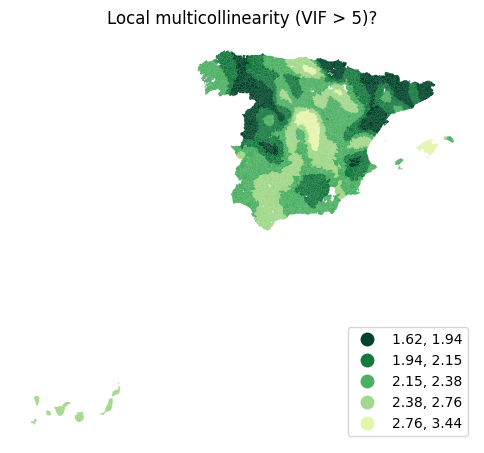

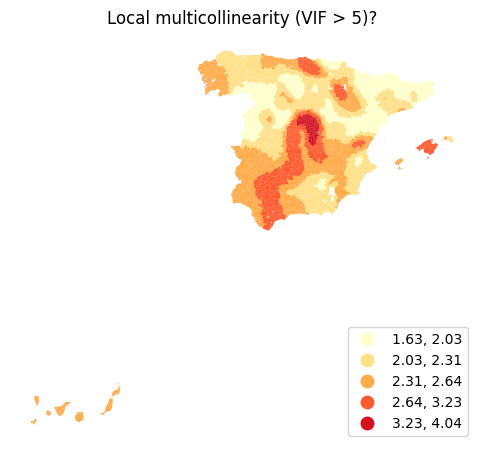

In [53]:
# Plot Multicollinearity - VIF
fig, ax = plt.subplots(figsize=(6, 6))
geo_info.plot(
    column='gwr_VIF', 
    cmap = 'YlOrRd', 
    linewidth=0.1, 
    edgecolor=line_color(AREA_TO_PREDICT),
    scheme = 'FisherJenks',
    vmin=0,
    vmax=5,
    k=5,
    legend=True, 
    legend_kwds={'loc':'lower right'},
    ax=ax
    )
ax.set_title('Local multicollinearity (VIF > 5)?', fontsize=12)
ax.axis("off")
cmap.set_over('r')

if SAVE_FIGS:
    plt.savefig(DIR_GWR + "local_multicollinearity_VIF.svg", dpi=150, format="svg", bbox_inches='tight')

plt.show()

## Statistical information of each feature and section

In [54]:
# Calculate statistical information of each feature / section
significant_coefs_gwr = geo_significant_coefs.drop(["geometry"], axis=1)

limit_value = (
    max(
        np.nanmin(abs(significant_coefs_gwr.to_numpy())),
        np.nanmax(abs(significant_coefs_gwr.to_numpy())),
    )
    * 1.05
)

if FIT_INTERCEPT:
    medians_gwr = significant_coefs_gwr.drop(["Intercept"], axis=1).median()
else:
    medians_gwr = significant_coefs_gwr.median()

medians_gwr = medians_gwr.reindex(medians_gwr.abs().sort_values(ascending=False).index)

if FIT_INTERCEPT:
    medians_gwr = medians_gwr.append(pd.Series({"Intercept": 0}, index=["Intercept"]))

significant_coefs_gwr = significant_coefs_gwr[medians_gwr.index]

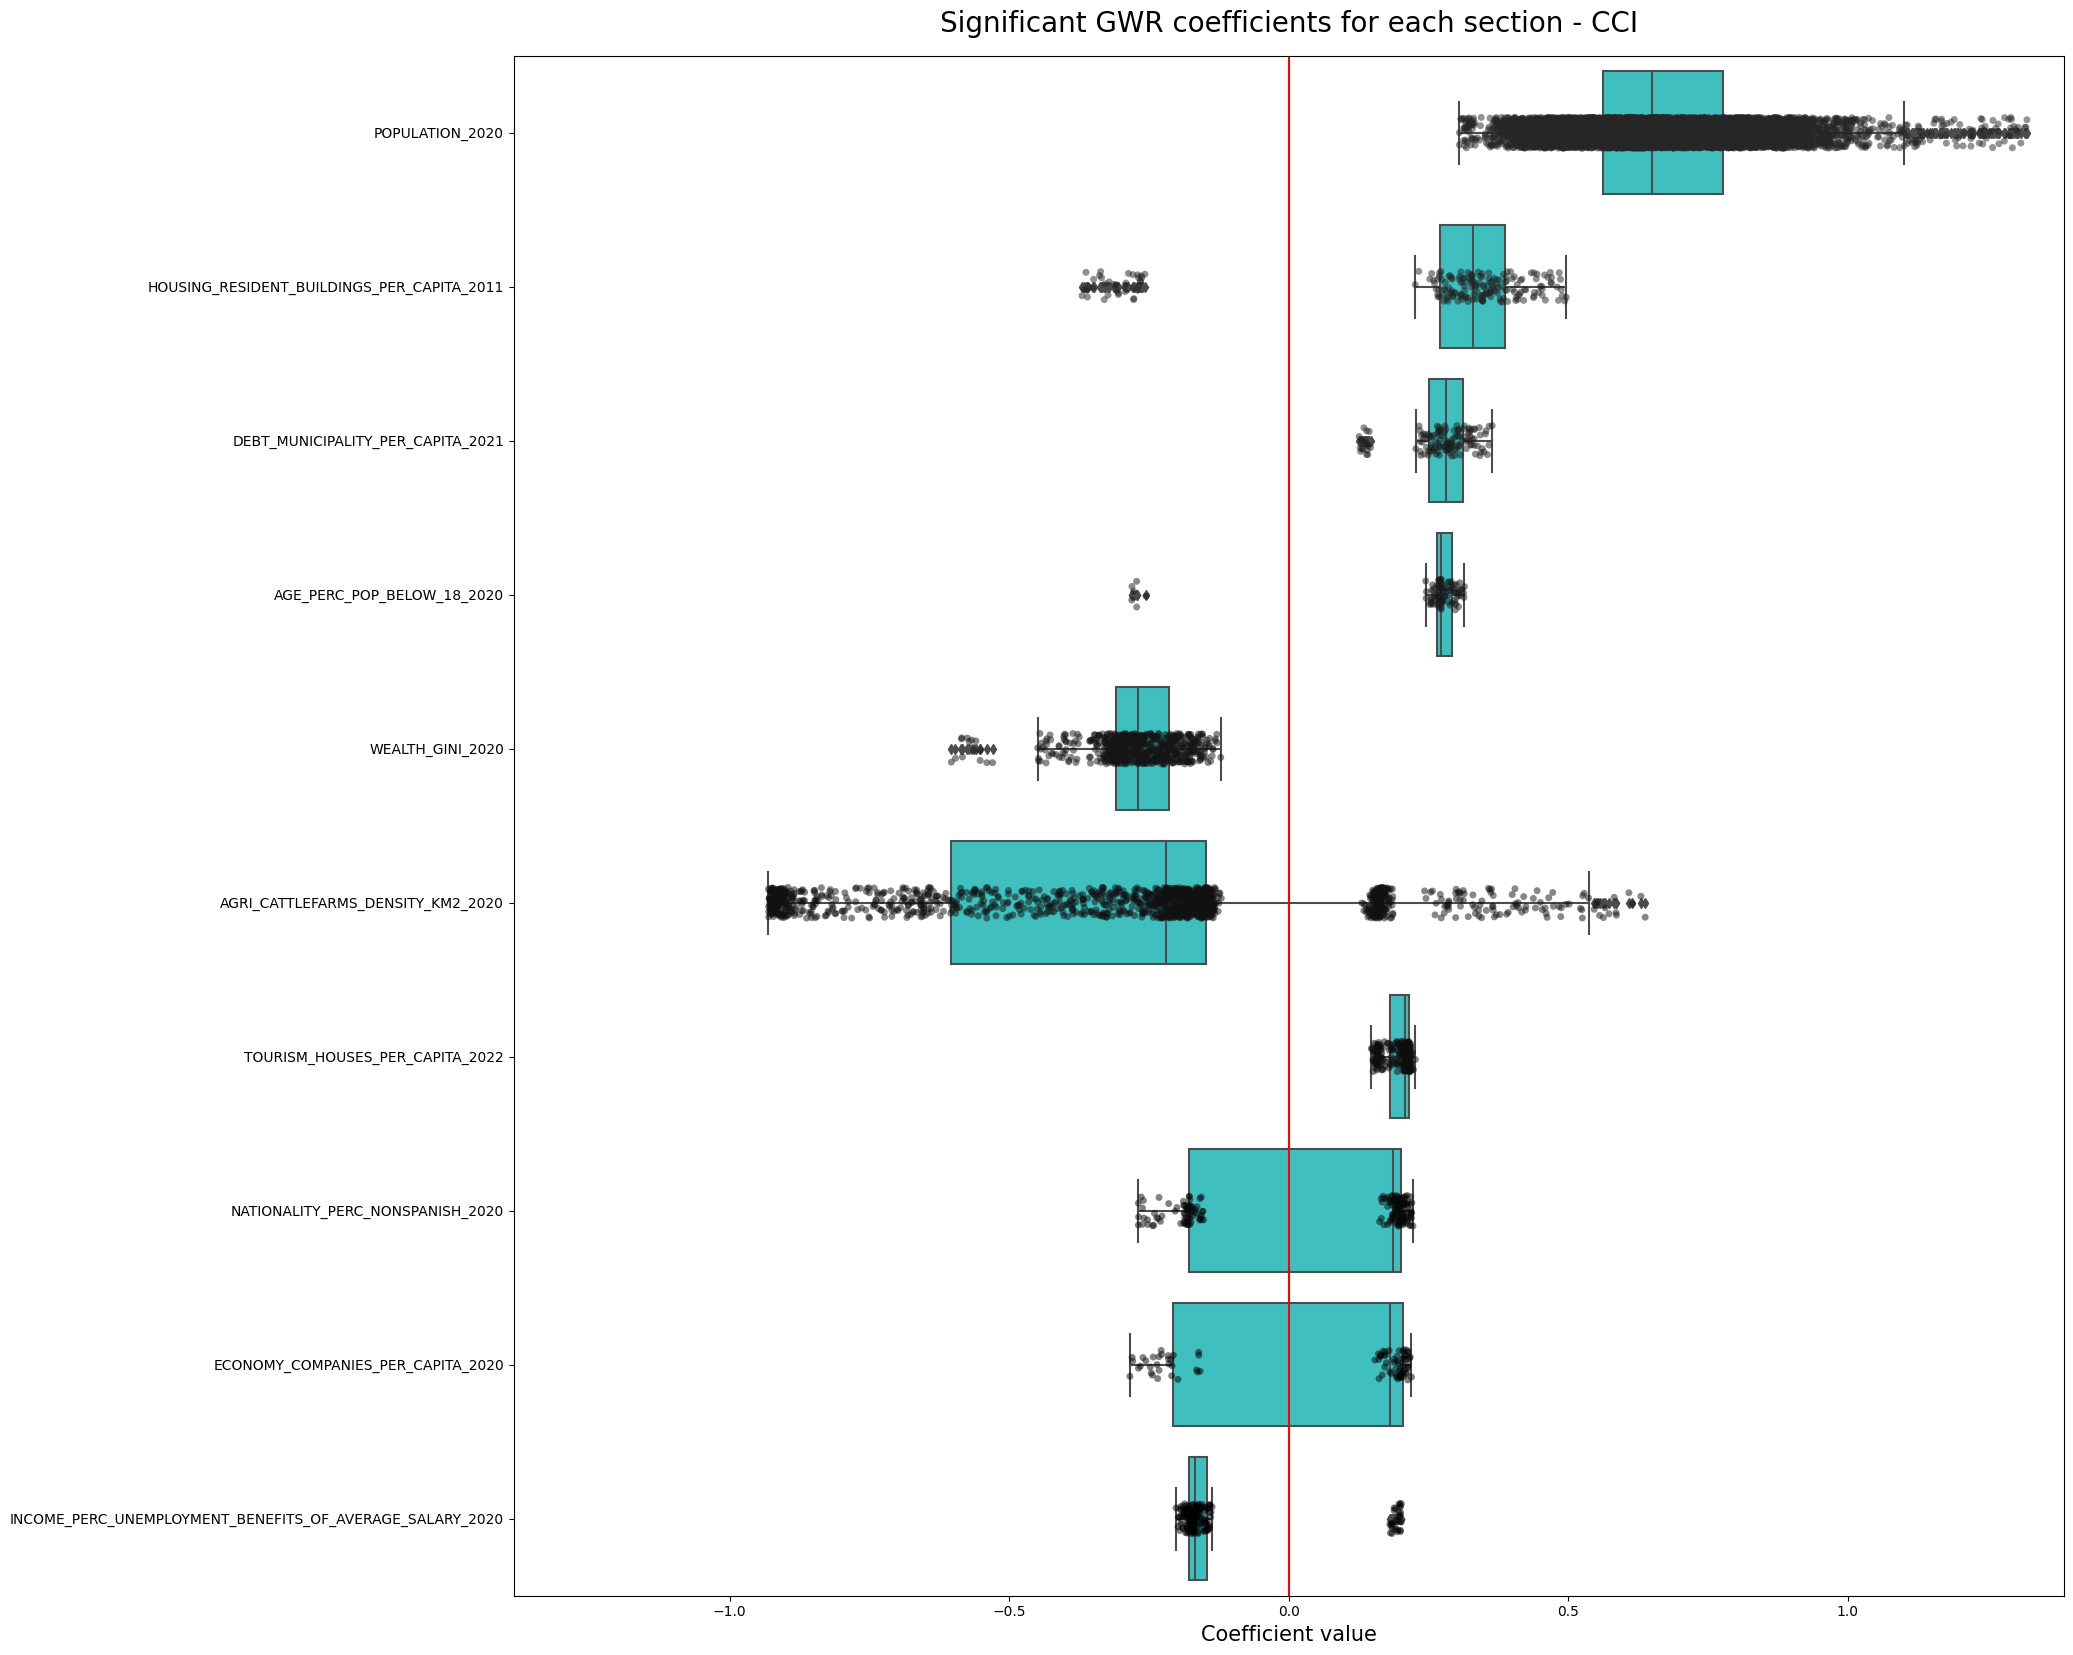

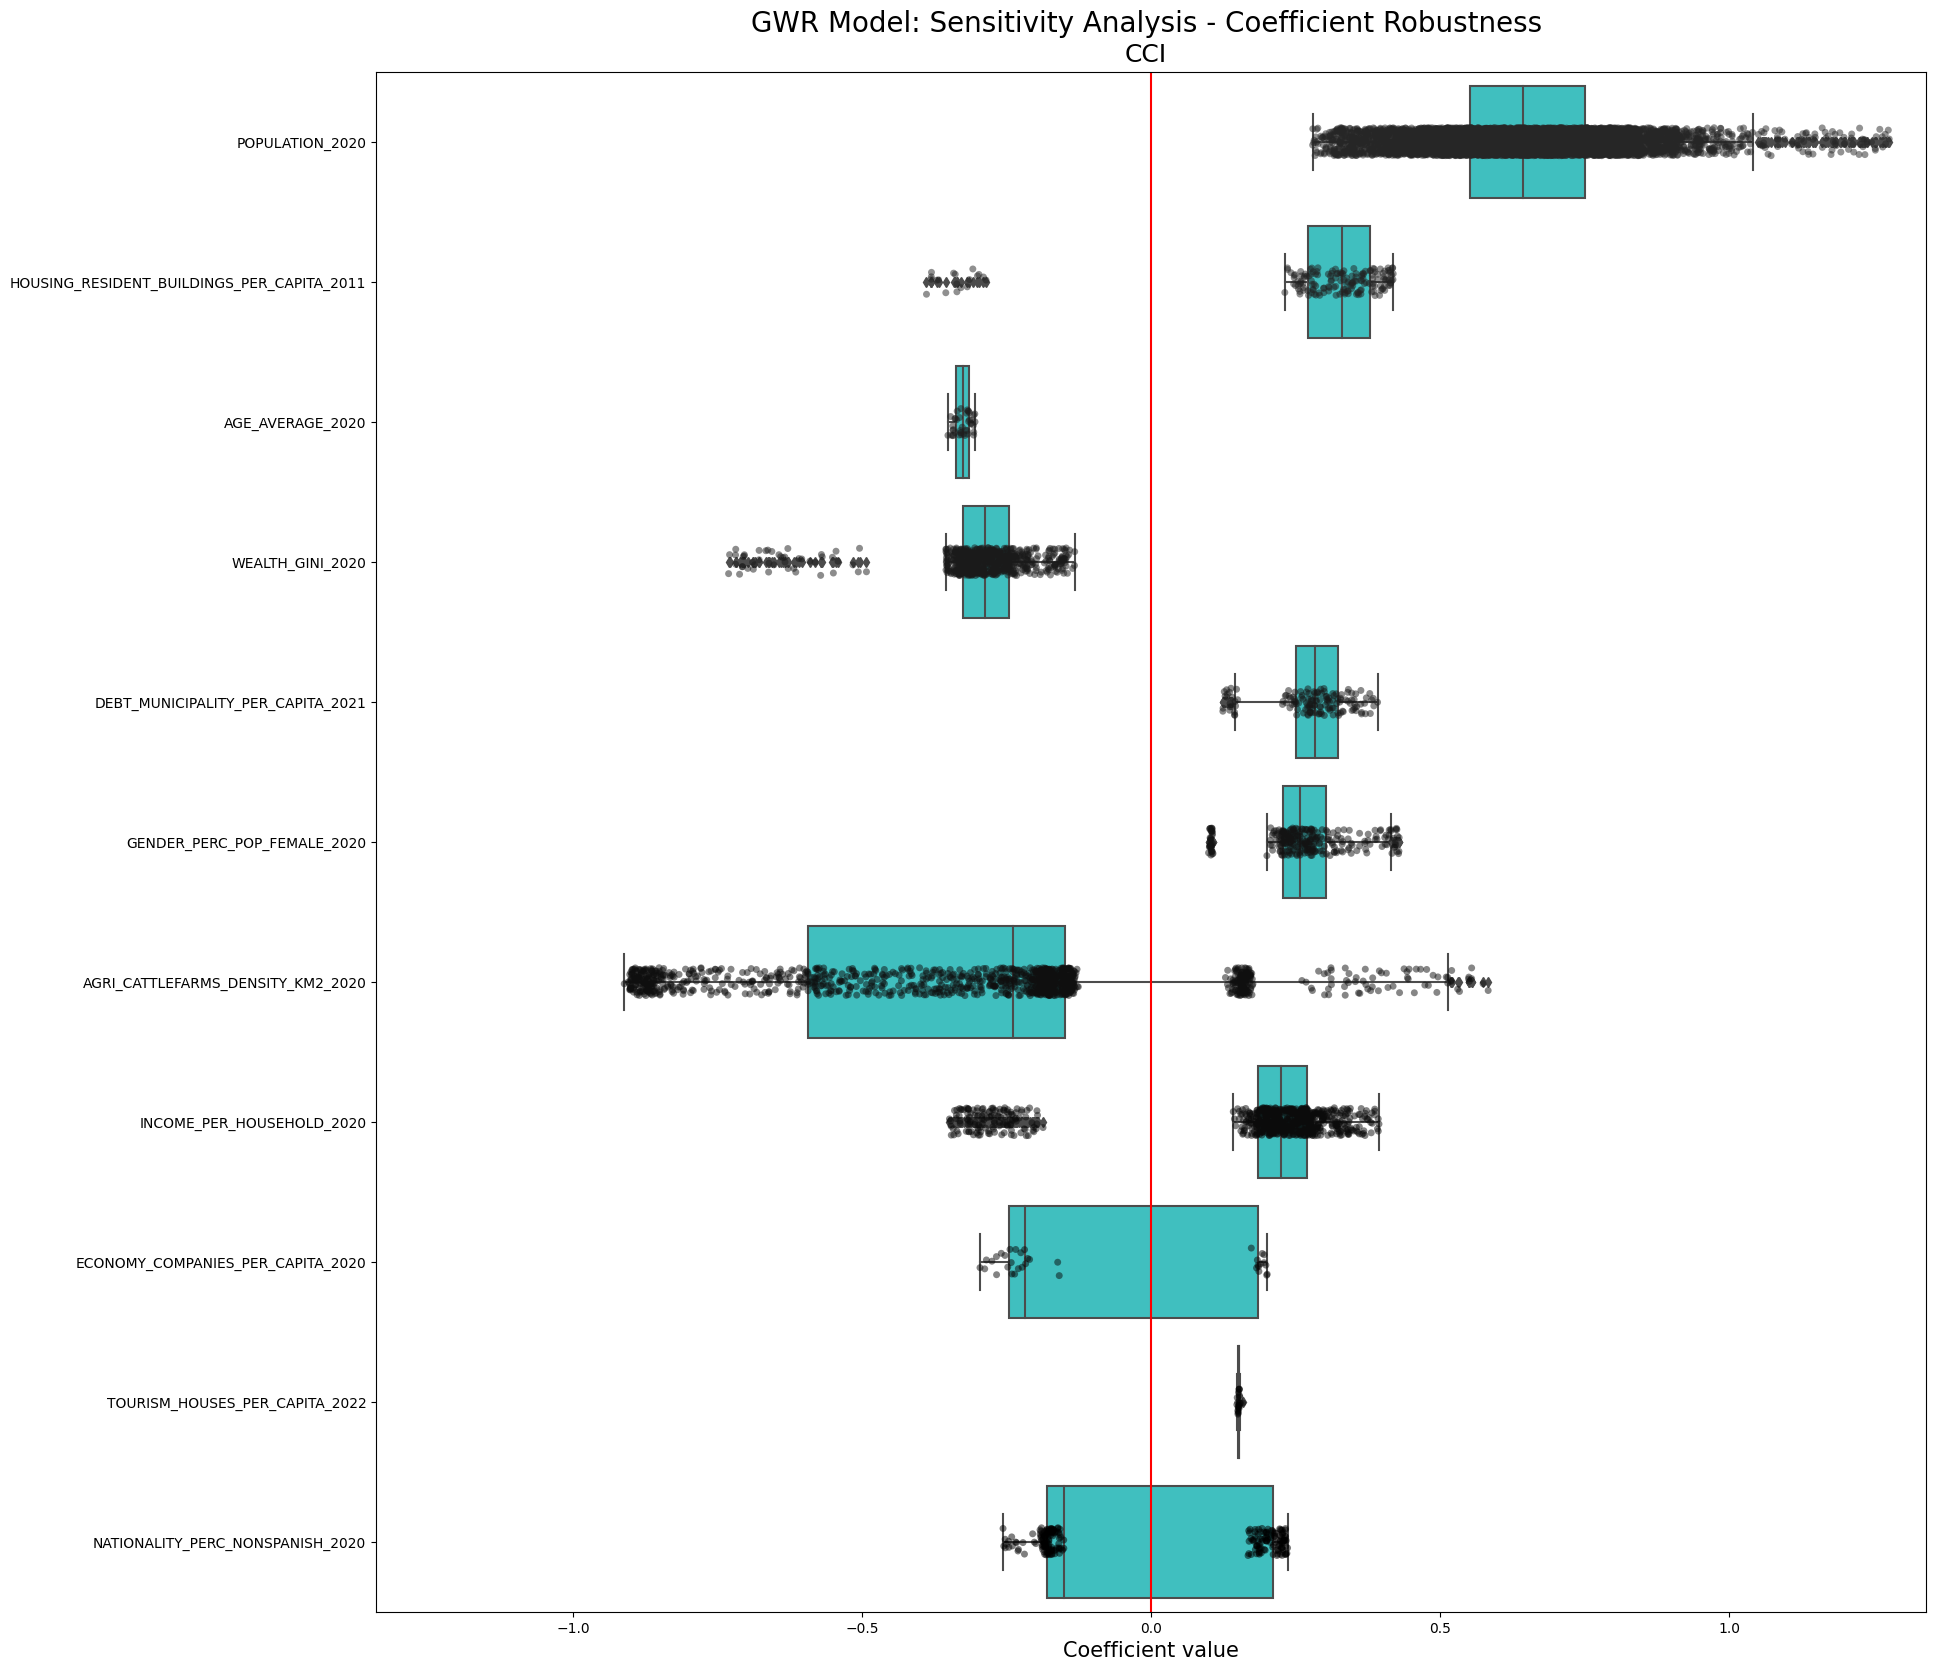

In [55]:
# Plot sensitivity analysis
fig, ax = plt.subplots(figsize=(20, 20))

sns.stripplot(ax=ax,data=significant_coefs_gwr,orient="h", color="k", alpha=0.5)
sns.boxplot(ax=ax,data=significant_coefs_gwr,orient="h", color="cyan",saturation=0.5)
plt.axvline(x=0, color="red")

plt.figtext(0.51, 0.9, "GWR Model: Sensitivity Analysis - Coefficient Robustness", fontsize=20, ha="center")
plt.figtext(0.51, 
    0.885,
    VARIABLE_TO_PREDICT,
    fontsize=18,
    ha="center",
)

ax.set_xlim(-limit_value, limit_value)
ax.set_xlabel("Coefficient value", fontsize=15)

if SAVE_FIGS:
    plt.savefig(DIR_GWR + "sensitivity_gwr_model.svg", format="svg")

plt.show()

In [56]:
if SAVE_MODEL is True:
    significant_coefs_gwr.to_csv(DIR_GWR + "coefficients.csv")
    significant_coefs_gwr.to_csv(
        DIR_VAR + "08_gwr/coefficients_{}.csv".format(VARIABLE_TO_PREDICT)
    )

In [57]:
# Count significant features 
significant_count = pd.DataFrame(
    [significant_coefs_gwr.count().index, significant_coefs_gwr.count().values]
).T
significant_count.columns = ["Features", "Percentage"]

# Calculate percentage of areas where each feature is significant
significant_count["Percentage"] = significant_count["Percentage"] / X.shape[0]
significant_count.sort_values(by=["Percentage"], ascending=False, inplace=True)

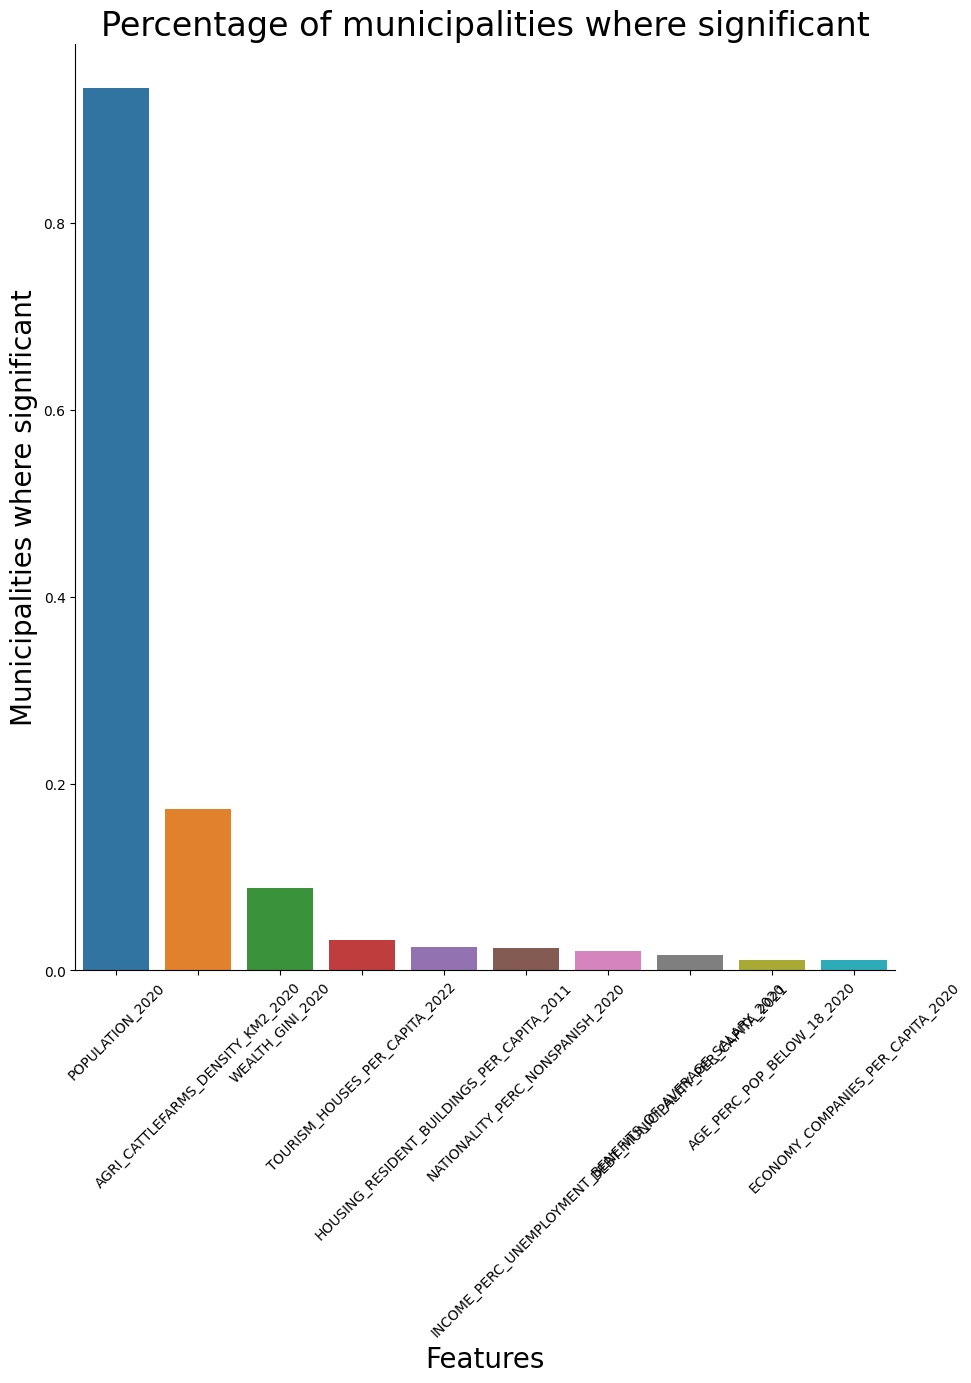

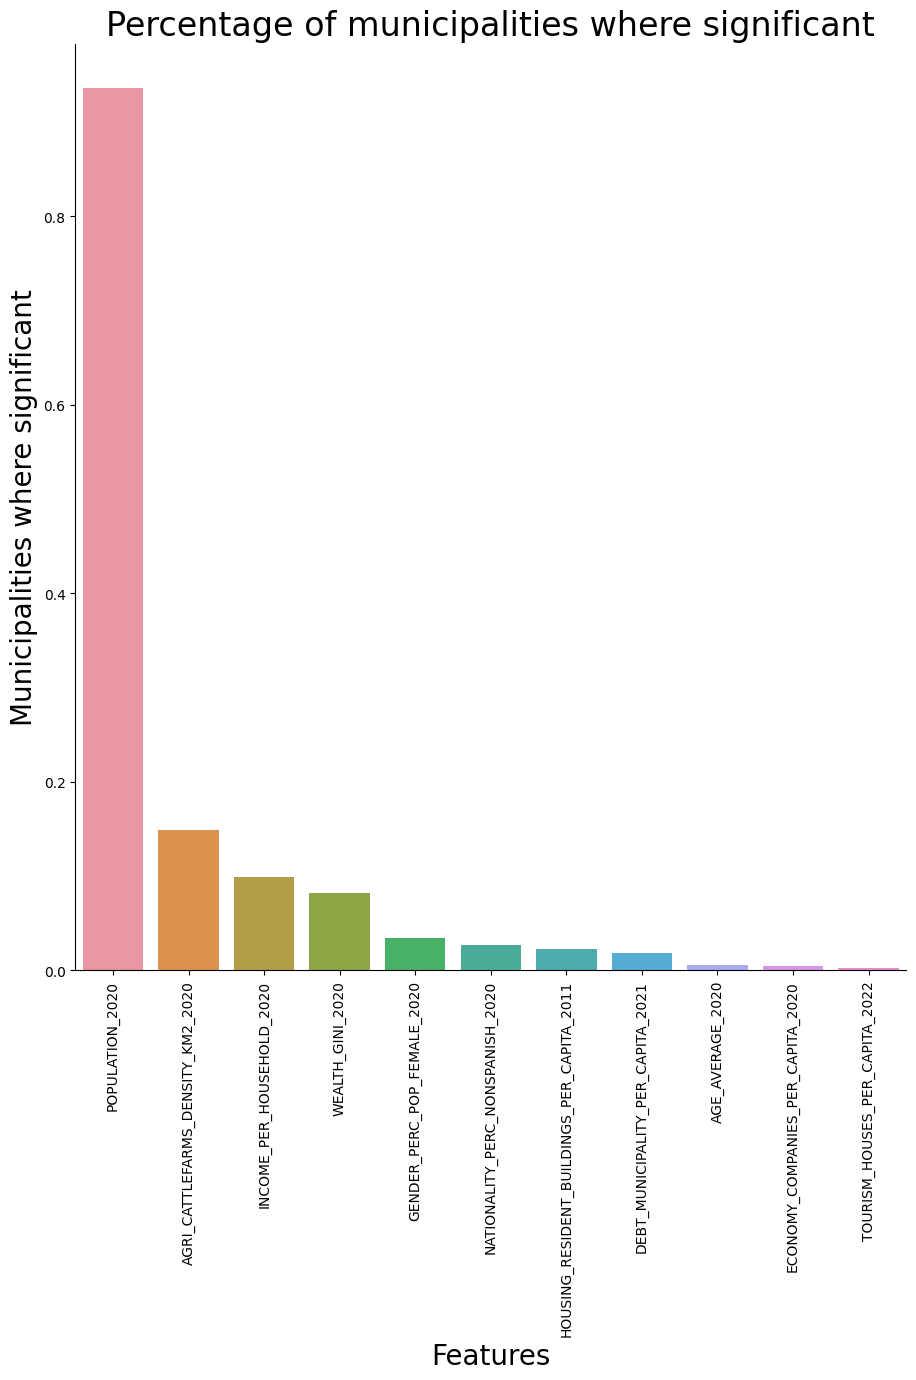

In [58]:
# Plot percentage of areas where each feature is significant
g = sns.catplot(
    ax=ax,
    x="Features",
    y="Percentage",
    kind="bar",
    data=significant_count,
    height=10,
    aspect=1,
)

# g.set_title("Significancy of features", fontsize=50)
plt.xlabel("Features", fontsize=20)
plt.ylabel("Municipalities where significant", fontsize=20)
plt.xticks(rotation=90)
plt.title("Percentage of municipalities where significant", size=24)

if SAVE_FIGS:
    g.savefig(DIR_GWR + "significant_counts.svg", format="svg")

plt.show()

In [59]:
# Count significant features per area
area_count = pd.DataFrame([significant_coefs_gwr.index, significant_coefs_gwr.T.count().values]).T
area_count.columns = ["Area", "Count"]
area_count.set_index("Area", inplace=True)
geo_info["Area_Count"] = area_count["Count"]

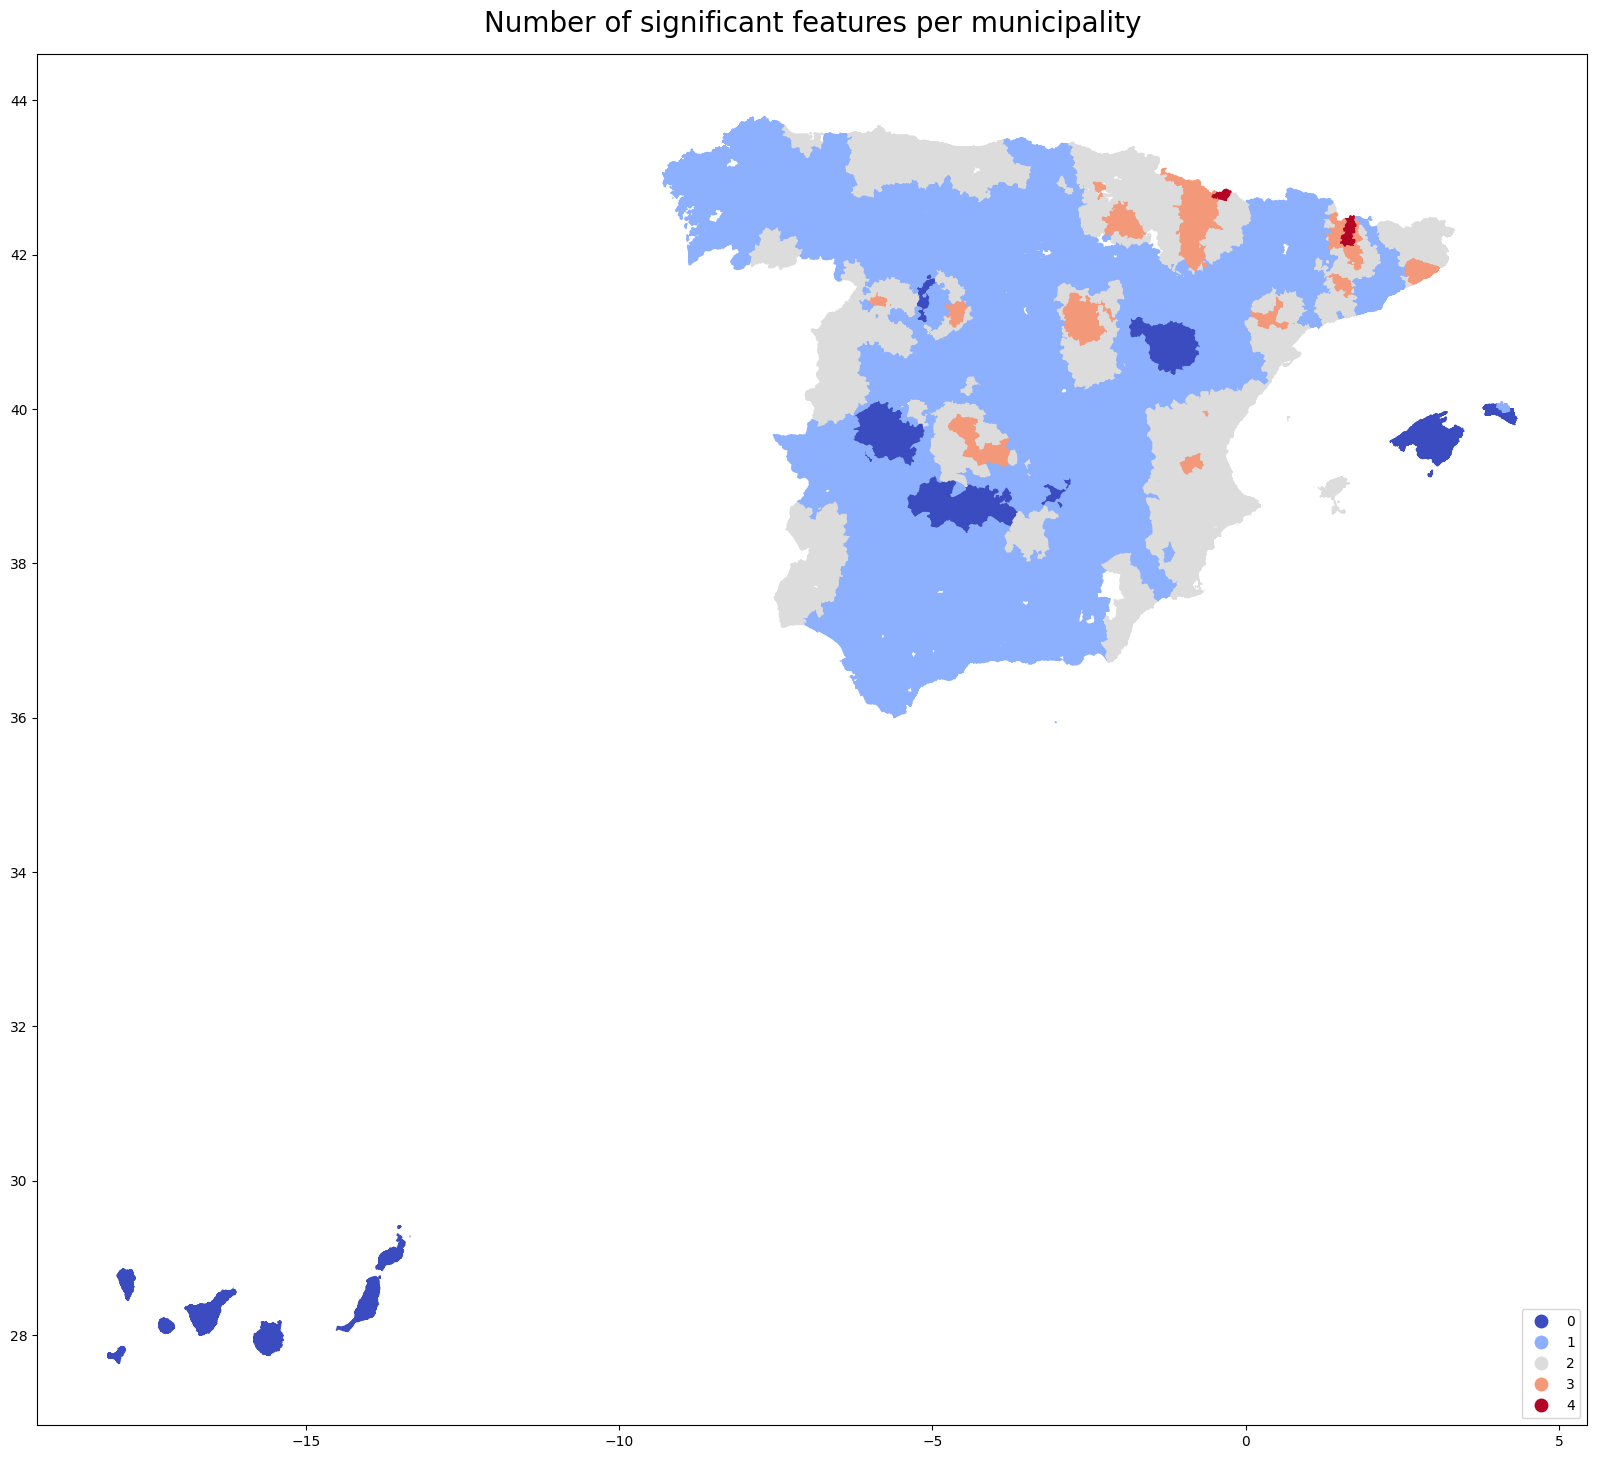

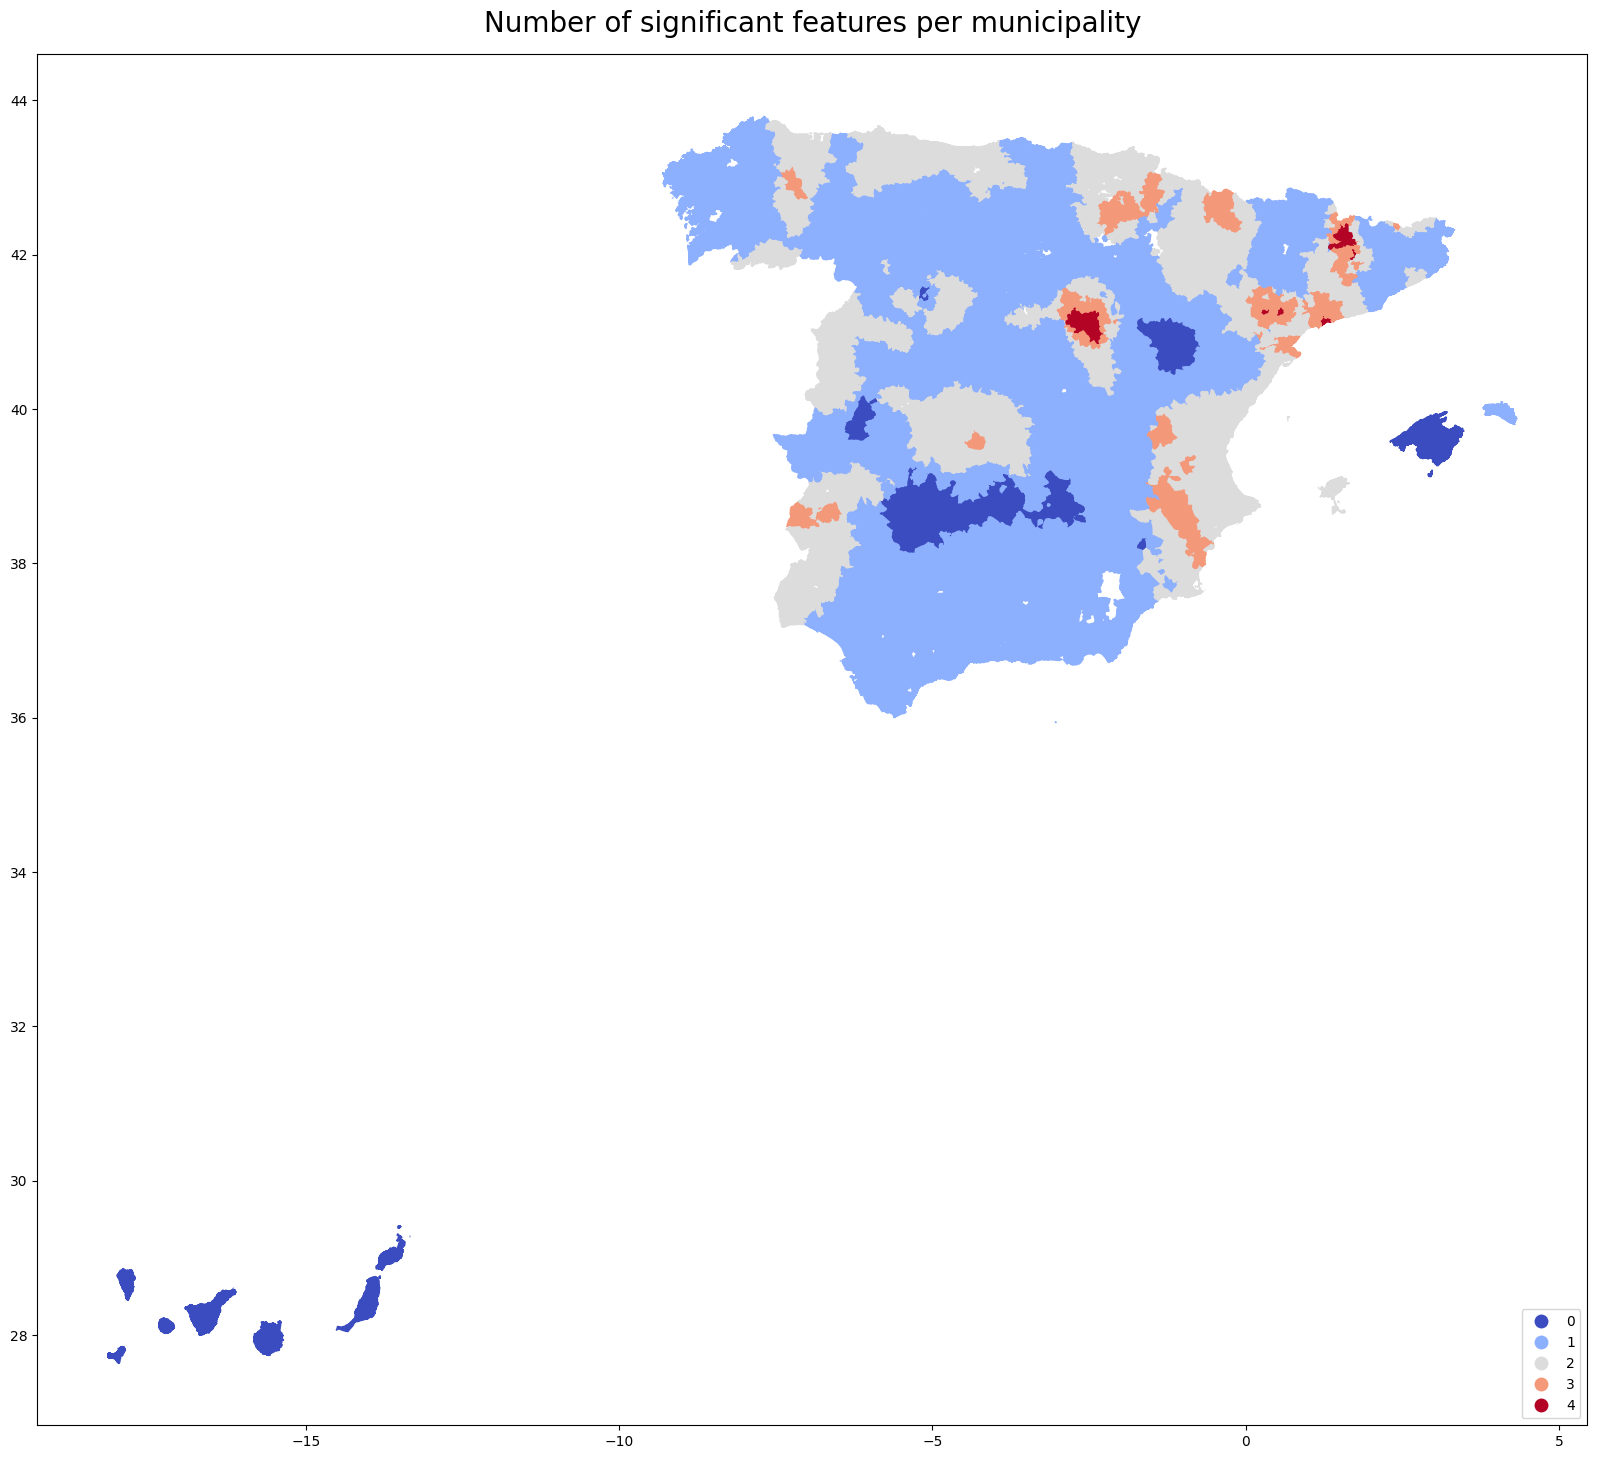

In [60]:
# Plot counted significant features per area

fig, ax = plt.subplots(figsize=(20, 20))
geo_info.plot(
    ax=ax,
    edgecolor=line_color(AREA_TO_PREDICT),
    column="Area_Count",
    legend=True,
    legend_kwds={'loc':'lower right'},
    #     vmin=0.5,
    #     vmax=1,
    cmap="coolwarm", #tab10
    #     legend_kwds={"shrink": 0.7},
)

ax.set_title("Number of significant features per municipality", fontsize=20, y=1.01)

# geo_info[geo_info[VARIABLE_TO_PREDICT] == 0].centroid.plot(ax=ax, color="red")

if SAVE_FIGS:
    plt.savefig(DIR_GWR + "number_features.svg", format="svg")

plt.show()

In [ ]:
# Plot counted significant features per area

fig, ax = plt.subplots(figsize=(20, 20))
geo_info.plot(
    ax=ax,
    edgecolor=line_color(AREA_TO_PREDICT),
    column="Area_Count",
    legend=True,
    legend_kwds={'loc':'lower right'},
    #     vmin=0.5,
    #     vmax=1,
    cmap="Blues", #tab10
    #     legend_kwds={"shrink": 0.7},
)

ax.set_title("Number of significant features per municipality", fontsize=20, y=1.01)

# geo_info[geo_info[VARIABLE_TO_PREDICT] == 0].centroid.plot(ax=ax, color="red")

if SAVE_FIGS:
    plt.savefig(DIR_GWR + "number_features.svg", format="svg")

plt.show()

In [61]:
# Define most important feature per municipality
geo_info["Chosen_Most_Important"] = (
    significant_coefs_gwr.fillna(0).abs().idxmax(axis=1).values
)

temp = geo_info["Chosen_Most_Important"]
temp[significant_coefs_gwr.fillna(0).abs().max(axis=1) == 0] = "!NONE"
geo_info["Chosen_Most_Important"] = temp

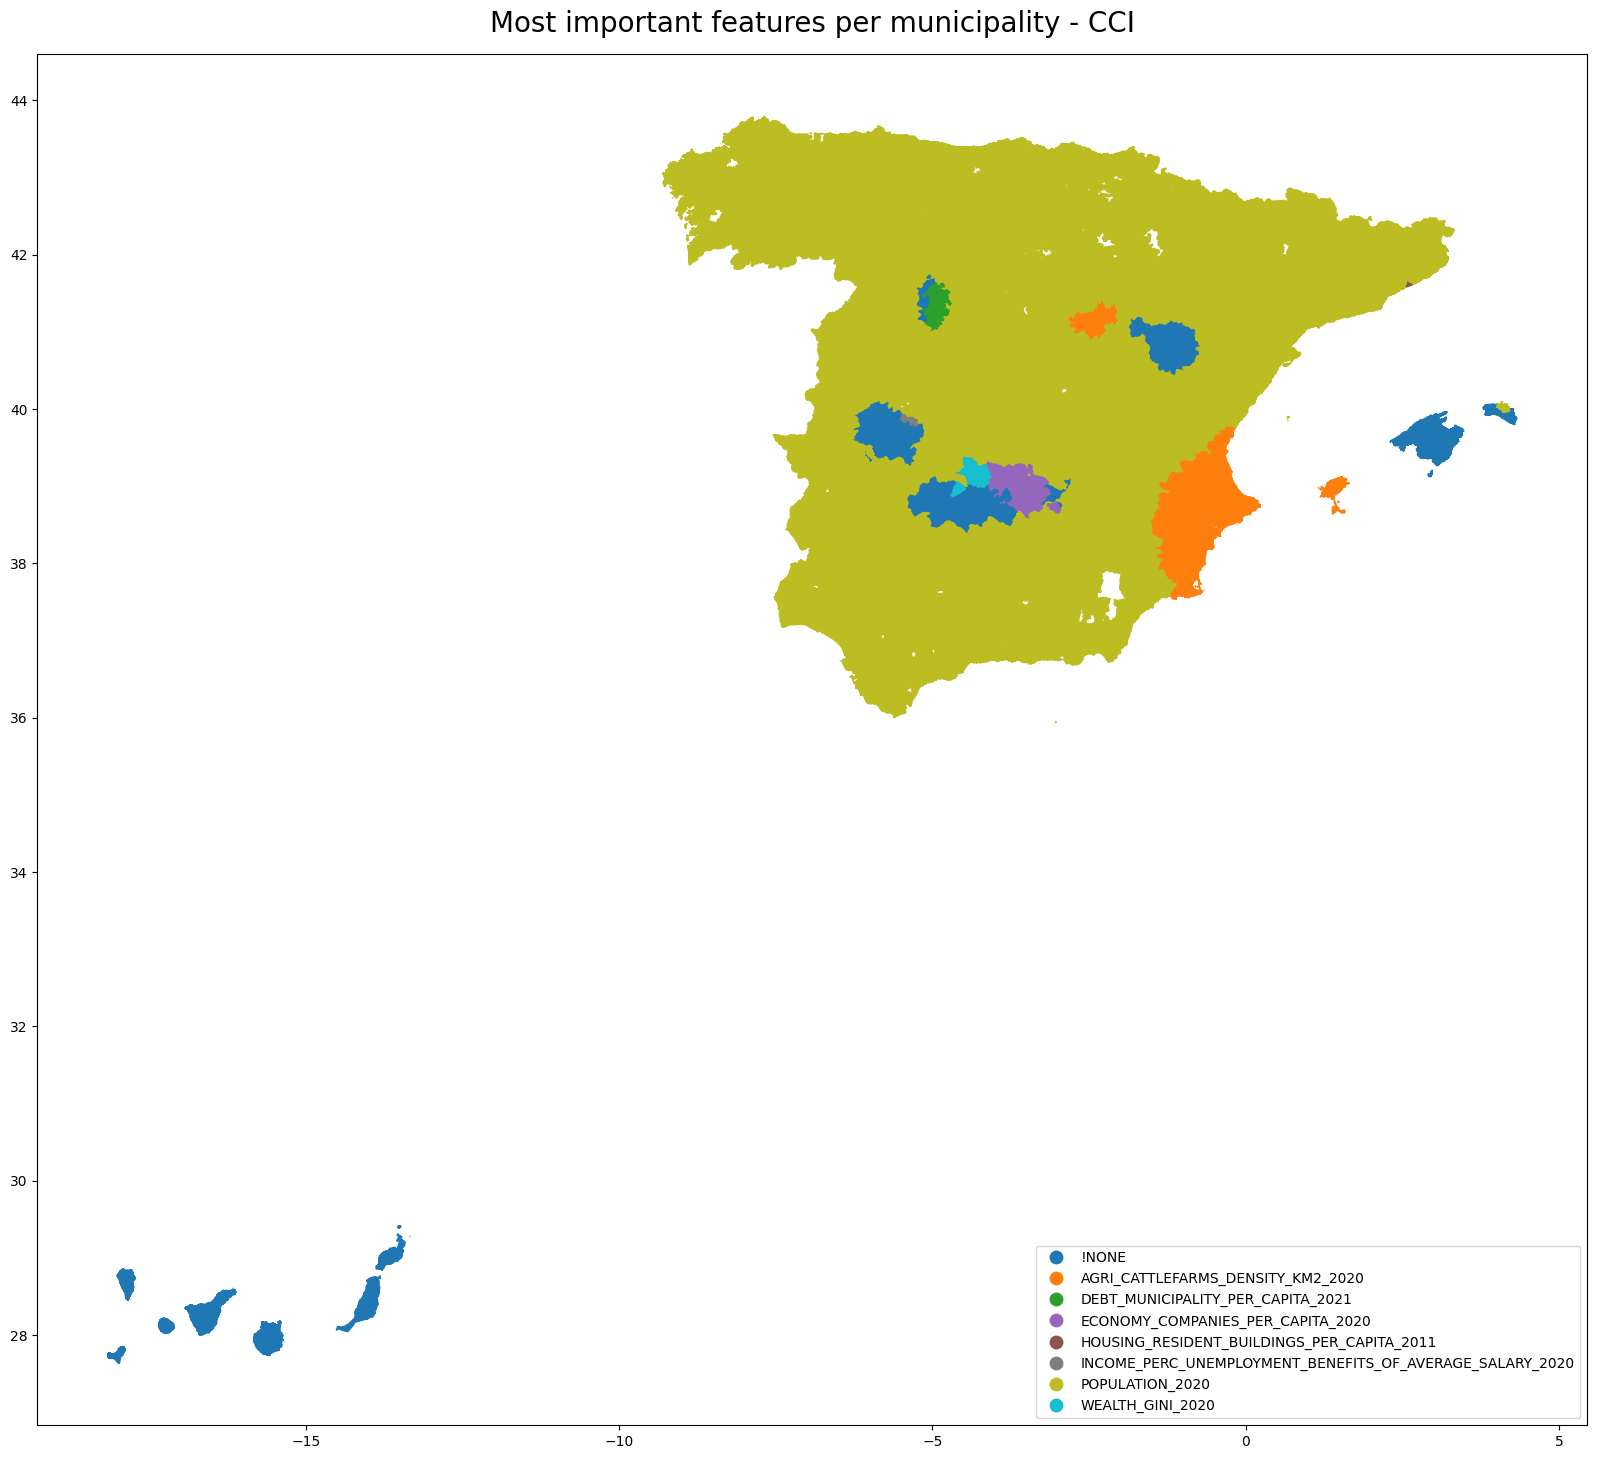

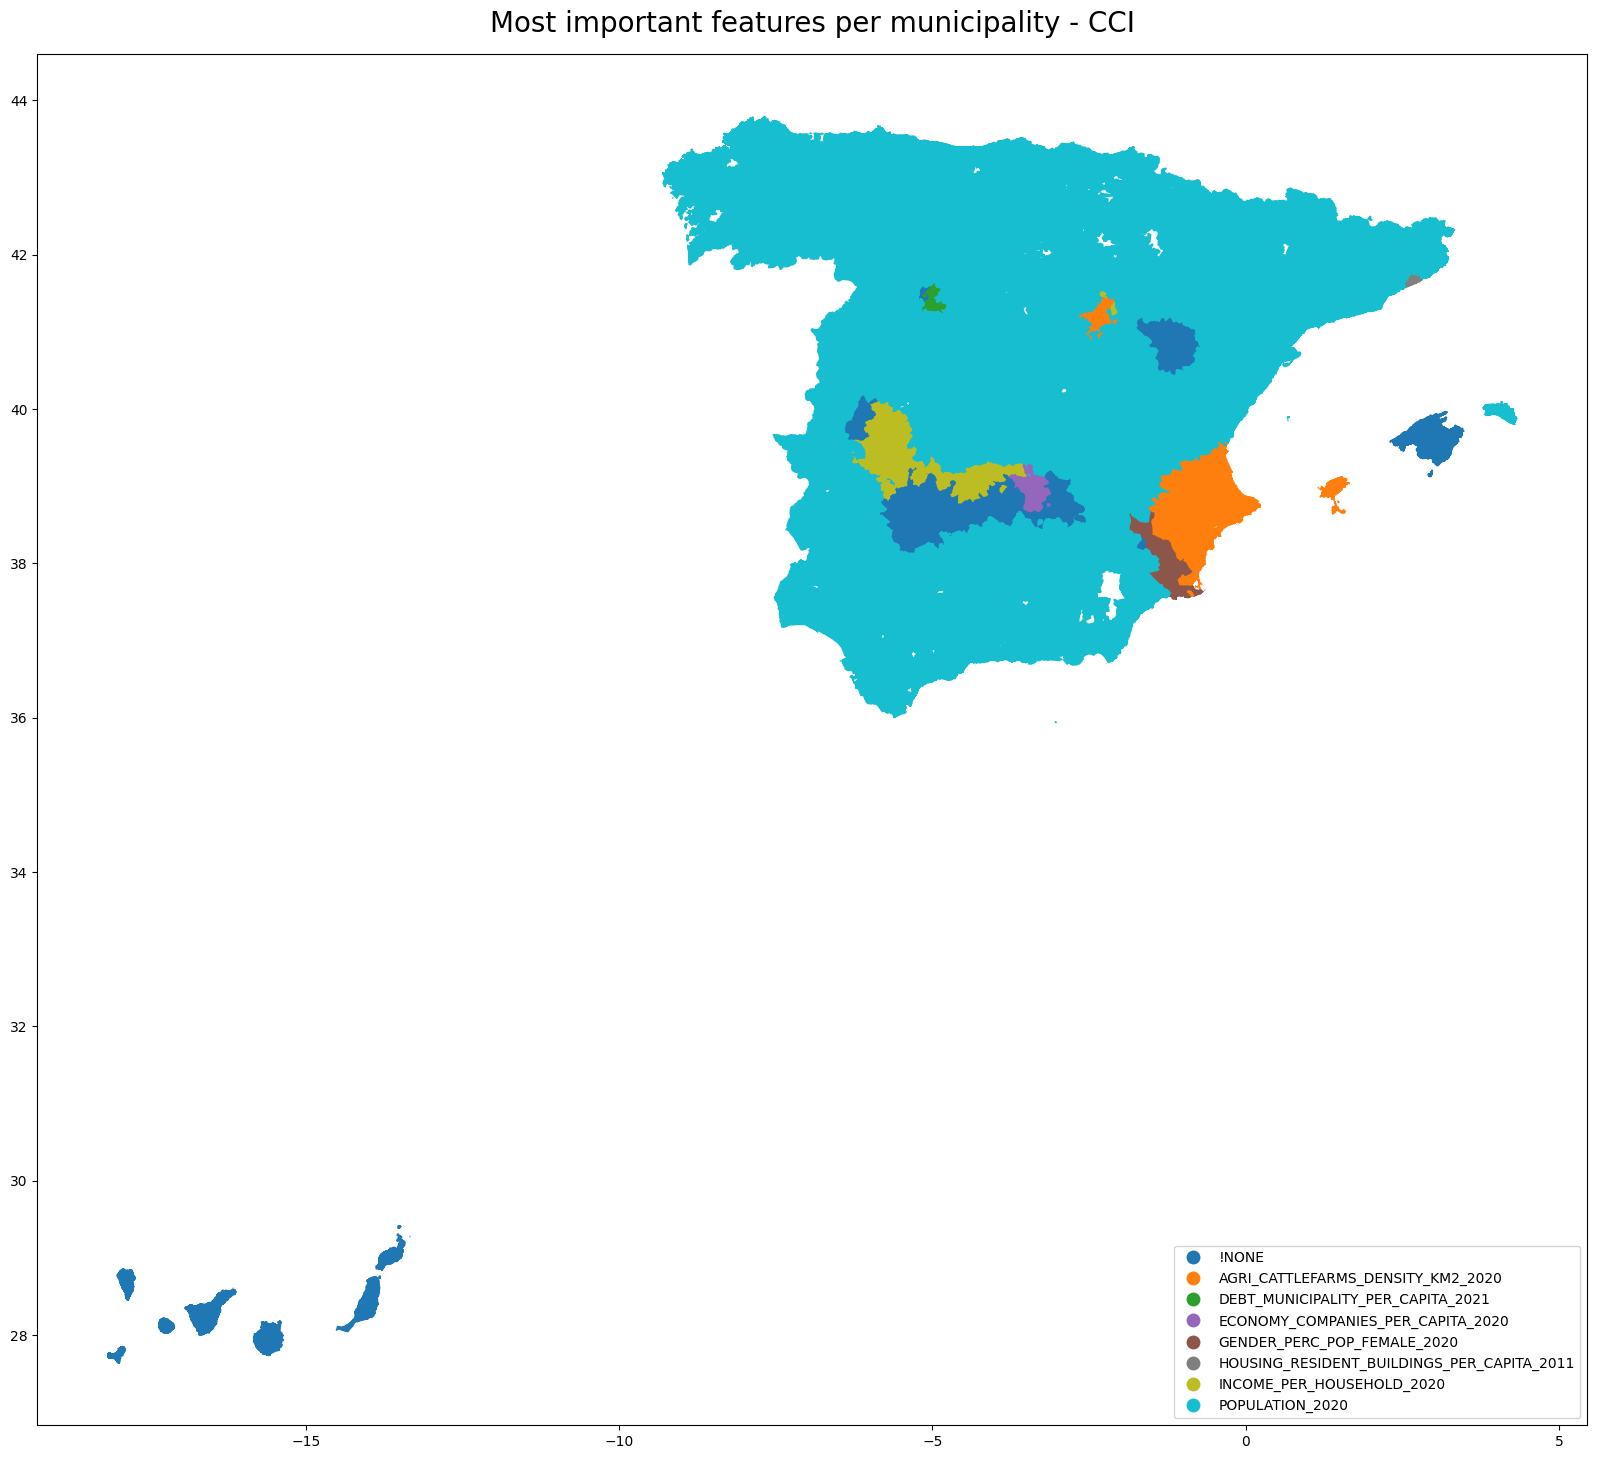

In [62]:
# Plot most important feature per municipality
fig, ax = plt.subplots(figsize=(20, 20))
geo_info.plot(
    ax=ax,
    edgecolor=line_color(AREA_TO_PREDICT),
    column="Chosen_Most_Important",
    legend=True,
    legend_kwds={'loc':'lower right'},
)

ax.set_title(
    "Most important features per municipality - {}".format(VARIABLE_TO_PREDICT),
    fontsize=20,
    y=1.01,
)

if SAVE_FIGS:
    plt.savefig(DIR_GWR + "important_features.svg", format="svg")


plt.show()

## Model comparison: linear vs GWR

In [63]:
# Create lists to append model comparison data and names
comparison = []
comparison_names = []

# Append data of GWR and Linear regression to lists 
for col in significant_coefs_gwr.columns:
    comparison.append(significant_coefs_gwr[col].dropna().values)
    comparison.append(linear_coefs[col].values)
    comparison_names.append("GWR - {}".format(col))
    comparison_names.append("Linear - {}".format(col))


df_comparison = pd.DataFrame(comparison).T
df_comparison.columns = [col for col in comparison_names]

limit_value = (
    max(
        np.nanmin(abs(df_comparison.to_numpy())),
        np.nanmax(abs(df_comparison.to_numpy())),
    )
    * 1.05
)

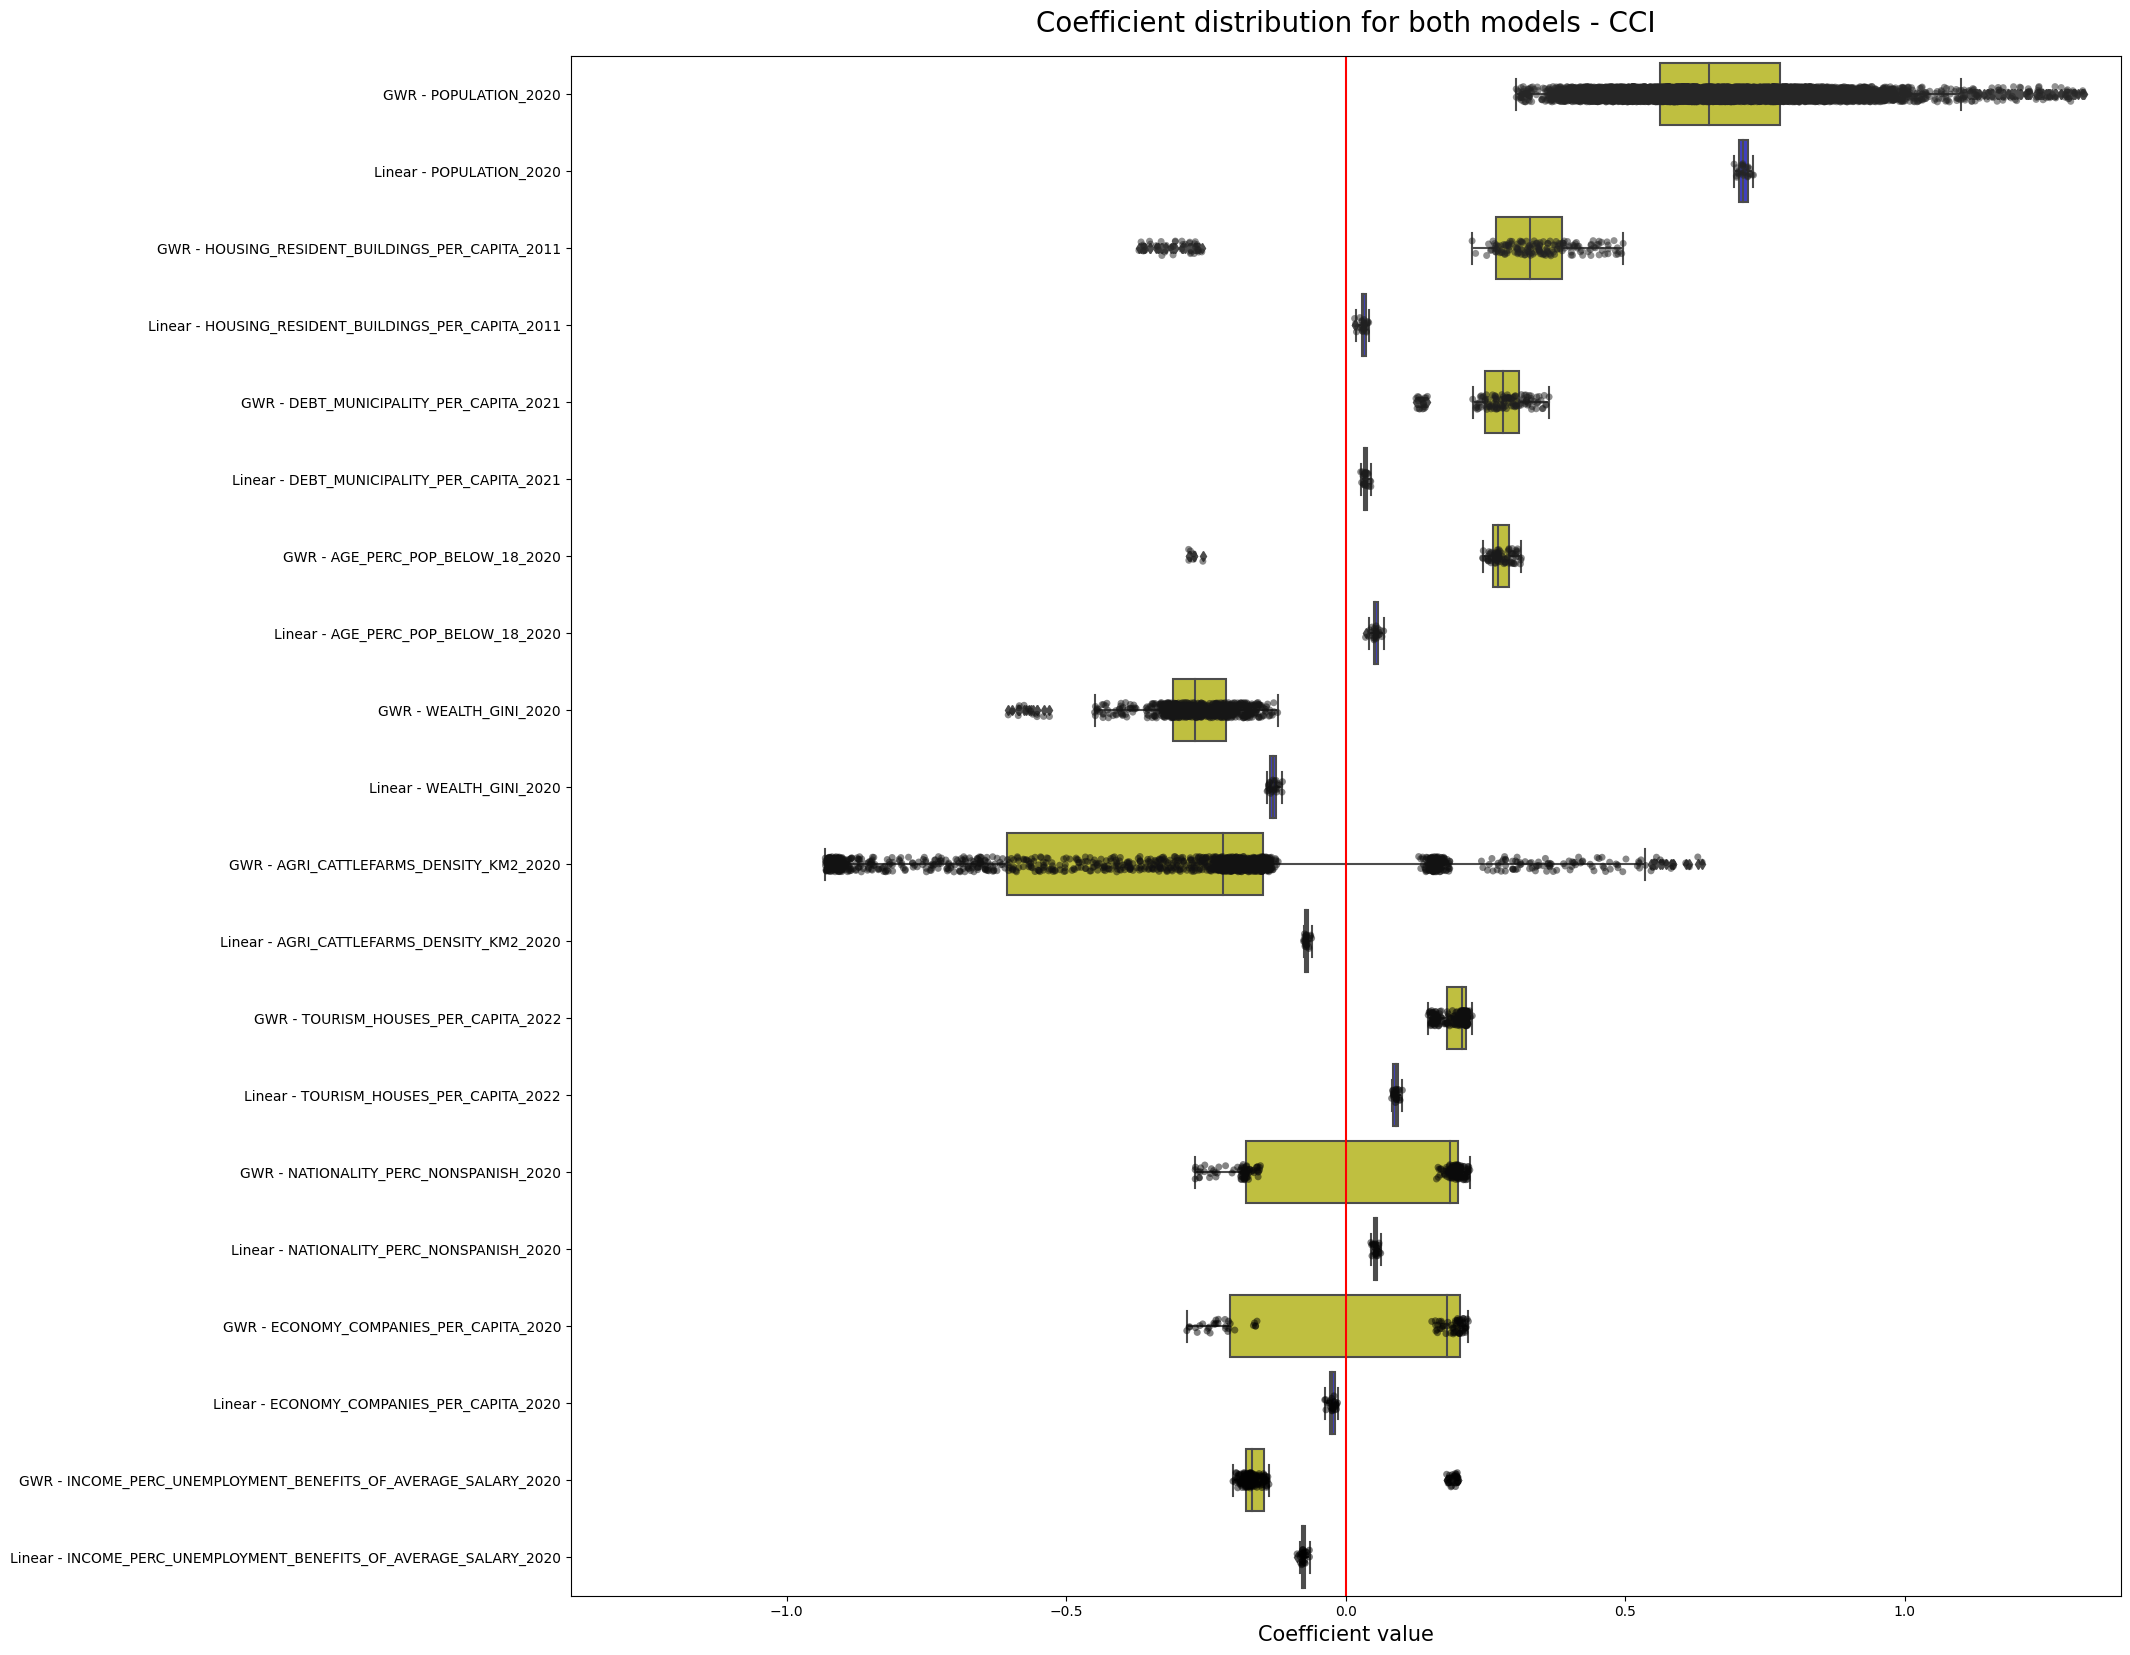

SyntaxError: EOL while scanning string literal (2824973745.py, line 27)

In [64]:
# Plot model comparison of GWR and linear regression
fig, ax = plt.subplots(figsize=(20, 20))

sns.stripplot(
    ax=ax,
    data=df_comparison,
    orient="h",
    color="k",
    alpha=0.5,
)

pal = {
    col: "yellow" if col.startswith("GWR") else "blue" for col in df_comparison.columns
}

sns.boxplot(
    ax=ax,
    data=df_comparison,
    orient="h",
    palette=pal,
    saturation=0.5,
)

plt.axvline(x=0, color="red")

ax.set_title(
    "Comparative Analysis - GWR vs Second Linear Regression\nSensitivity Analysis - Coefficient Robustness"
    fontsize=20,
    y=1.01,
)
ax.set_xlim(-limit_value, limit_value)
ax.set_xlabel("Coefficient value", fontsize=15)

if SAVE_FIGS:
    plt.savefig(DIR_GWR + "model_comparison_linear_GWR.svg", format="svg")
#     plt.savefig(DIR_GWR / "model_comparison_linear_GWR.jpg")


plt.show()

In [ ]:
df_gwr_bw_str = str(int(gwr_bw))
df_gwr_bw_str = pd.dataframe(df_gwr_bw_str)
df_gwr_bw_str.to_csv(DIR_GWR + "gwr_bw_str.csv")

df_gwr_bw = pd.dataframe(gwr_bw)
df_gwr_bw.to_csv(DIR_GWR + "gwr_bw.csv")

SyntaxError: unmatched ')' (162612165.py, line 1)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f11c3f49-2b5e-4e69-9186-d202c2d21fb7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>